In [ ]:
'''
Student Names + (IDs): 

Abdelrahman Mohamed Kamal Abdelaziz (1220255)
Mazen Ahmed Fouad Abdelwahab (1220269)
Mohamed Hesham Ibrahim Hassanain (1220278)
Ahmed Walaa Abdlelkhalek Abdelrahman (1220216)

'''
#Import(s)


import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import cv2
from skimage.feature import canny
from skimage.color import rgb2gray

In [ ]:
def show_images(images,titles=None):
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

In [ ]:
# Plate Localization

#-------------------------------------------------------------------------------------------------------------------------------

Path1 = 'Localization Test/One Step All Angles No Headlights/Straight.jpeg'
Path2 = 'Localization Test/Two Step All Angles No Headlights/Straight.jpeg'
Path3 = 'Localization Test/Three Step All Angles No Headlights/Straight.jpeg'
Path4 = 'Localization Test/One Step All Angles With Headlights/Straight.jpeg'
Path5 = 'Localization Test/Two Step All Angles With Headlights/Straight.jpeg'

Path11 = 'Localization Test/One Step All Angles No Headlights/Elevated.jpeg'
Path12 = 'Localization Test/Two Step All Angles No Headlights/Elevated.jpeg'
Path13 = 'Localization Test/Three Step All Angles No Headlights/Elevated.jpeg'
Path14 = 'Localization Test/One Step All Angles With Headlights/Elevated.jpeg'
Path15 = 'Localization Test/Two Step All Angles With Headlights/Elevated.jpeg'

Path111 = 'Localization Test/One Step All Angles No Headlights/Slight Right.jpeg'
Path112 = 'Localization Test/Two Step All Angles No Headlights/Slight Right.jpeg'
Path113 = 'Localization Test/Three Step All Angles No Headlights/Slight Right.jpeg'

Path1111 = 'Localization Test/One Step All Angles No Headlights/Slight Left.jpeg'
Path1112 = 'Localization Test/Two Step All Angles No Headlights/Slight Left.jpeg'
Path1113 = 'Localization Test/Three Step All Angles No Headlights/Slight Left.jpeg'
Path1114 = 'Localization Test/One Step All Angles With Headlights/Left.jpeg'

Path11111 = 'Localization Test/One Step All Angles No Headlights/Extreme Left.jpeg'
Path11112 = 'Localization Test/One Step All Angles No Headlights/Extreme Right.jpeg'
Path11113 = 'Localization Test/Two Step All Angles No Headlights/Extreme Left.jpeg'
Path11114 = 'Localization Test/Two Step All Angles No Headlights/Extreme Right.jpeg'
Path11115 = 'Localization Test/Three Step All Angles No Headlights/Extreme Left.jpeg'
Path11116 = 'Localization Test/Three Step All Angles No Headlights/Extreme Right.jpeg'
   
#-------------------------------------------------------------------------------------------------------------------------------

def Plate_Detection(image_path):

    # Original Image
    Original_Img = io.imread(image_path)[:,:,:3]
    Height, Width, _ = Original_Img.shape

    # Read Image and convert to grayscale
    img = cv2.imread(image_path)[:,:,:3]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE to improve local contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray_clahe = clahe.apply(gray)

    # Apply Gaussian Blur to reduce noise
    gray_blur = cv2.GaussianBlur(gray_clahe, (5,5), 0)

    # Adaptive Thresholding to handle dark and bright regions
    thresh = cv2.adaptiveThreshold(gray_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 19, 9)

    # Morphological closing to connect fragmented regions
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    plate_candidates = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / h
        area_ratio = (w * h) / (Height * Width)
        if (1.8 < aspect_ratio < 3.7) and (0.01 < area_ratio < 0.3):
            plate_candidates.append((x, y, w, h))

    if not plate_candidates:
        print("No plate candidate found.")
        return None

    # Choose the best candidate
    Best_Score = -1
    Best_Candidate = None

    for (x, y, w, h) in plate_candidates:

        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

        Current_Image = Original_Img[y:y+h, x:x+w]

        # --- Edge Density ---
        CannyEdges = canny(rgb2gray(Current_Image), sigma=1.0)
        edge_ratio = np.count_nonzero(CannyEdges) / (h * w)

        # --- Color / brightness variance ---
        # use brightness (mean over channels) as a simple measure
        brightness = Current_Image.mean(axis=2)
        brightness_var = np.var(brightness)

        # show_images([Current_Image], [f"Candidate Plate Edge Ratio: {edge_ratio:.4f} , Brightness Var: {brightness_var:.4f}"])

        # --- Combined score ---
        # Edge density is still the main factor, color helps down-weight bad ones
        score = brightness_var

        if score > Best_Score:
            Best_Score = score
            Best_Candidate = (x, y, w, h)


    # Crop the best candidate
    x, y, w, h = Best_Candidate
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # show_images([img], ["Best Plate Candidate"])
    plate_img = Original_Img[y:y+h, x:x+w] 
    
    return plate_img

#-------------------------------------------------------------------------------------------------------------------------------
# Testing the Plate Detection Function on Different Images
#-------------------------------------------------------------------------------------------------------------------------------

Origignal_Img1 = io.imread(Path1)
Detected_Plate1 = Plate_Detection(Path1)
if Detected_Plate1 is not None:
    show_images([Origignal_Img1, Detected_Plate1], ["One Step No Headlights", "Plate Image"])

Origignal_Img2 = io.imread(Path2)
Detected_Plate2 = Plate_Detection(Path2)
if Detected_Plate2 is not None:
    show_images([Origignal_Img2, Detected_Plate2], ["Two Steps No Headlights", "Plate Image"])

Origignal_Img3 = io.imread(Path3)
Detected_Plate3 = Plate_Detection(Path3)
if Detected_Plate3 is not None:
    show_images([Origignal_Img3, Detected_Plate3], ["Three Steps No Headlights", "Plate Image"])

Origignal_Img4 = io.imread(Path4)
Detected_Plate4 = Plate_Detection(Path4)
if Detected_Plate4 is not None:
    show_images([Origignal_Img4, Detected_Plate4], ["One Step Headlights", "Plate Image"])

Origignal_Img5 = io.imread(Path5)
Detected_Plate5 = Plate_Detection(Path5)
if Detected_Plate5 is not None:
    show_images([Origignal_Img5, Detected_Plate5], ["Two Steps Headlights", "Plate Image"])

#-------------------------------------------------------------------------------------------------------------------------------

Origignal_Img11 = io.imread(Path11)
Detected_Plate11 = Plate_Detection(Path11)
if Detected_Plate11 is not None:
    show_images([Origignal_Img11, Detected_Plate11], ["One Step Elevated No Headlights", "Plate Image"]) 

Origignal_Img12 = io.imread(Path12)
Detected_Plate12 = Plate_Detection(Path12)
if Detected_Plate12 is not None:
    show_images([Origignal_Img12, Detected_Plate12], ["Two Step Elevated No Headlights", "Plate Image"])

Origignal_Img13 = io.imread(Path13)
Detected_Plate13 = Plate_Detection(Path13)
if Detected_Plate13 is not None:
    show_images([Origignal_Img13, Detected_Plate13], ["Three Step Elevated No Headlights", "Plate Image"])

Origignal_Img14 = io.imread(Path14)
Detected_Plate14 = Plate_Detection(Path14) 
if Detected_Plate14 is not None:
    show_images([Origignal_Img14, Detected_Plate14], ["One Step Elevated Headlights", "Plate Image"])

Origignal_Img15 = io.imread(Path15)
Detected_Plate15 = Plate_Detection(Path15)  
if Detected_Plate15 is not None:
    show_images([Origignal_Img15, Detected_Plate15], ["Two Step Elevated Headlights", "Plate Image"])

#-------------------------------------------------------------------------------------------------------------------------------

Origignal_Img111 = io.imread(Path111)
Detected_Plate111 = Plate_Detection(Path111)
if Detected_Plate111 is not None:
    show_images([Origignal_Img111, Detected_Plate111], ["One Step Slight Right No Headlights", "Plate Image"])

Origignal_Img112 = io.imread(Path112)
Detected_Plate112 = Plate_Detection(Path112)
if Detected_Plate112 is not None:
    show_images([Origignal_Img112, Detected_Plate112], ["Two Step Slight Right No Headlights", "Plate Image"])

Origignal_Img113 = io.imread(Path113)
Detected_Plate113 = Plate_Detection(Path113)
if Detected_Plate113 is not None:
    show_images([Origignal_Img113, Detected_Plate113], ["Three Step Slight Right No Headlights", "Plate Image"])

# Origignal_Img114 = io.imread(Path114)
# Detected_Plate114 = Plate_Detection(Path114)
# if Detected_Plate114 is not None:
#     show_images([Origignal_Img114, Detected_Plate114], ["One Step Slight Right Headlights", "Plate Image"])

# Origignal_Img115 = io.imread(Path115)
# Detected_Plate115 = Plate_Detection(Path115)
# if Detected_Plate115 is not None:
#     show_images([Origignal_Img115, Detected_Plate115], ["Two Step Slight Right Headlights", "Plate Image"])

#-------------------------------------------------------------------------------------------------------------------------------

Origignal_Img1111 = io.imread(Path1111)
Detected_Plate1111 = Plate_Detection(Path1111)
if Detected_Plate1111 is not None:
    show_images([Origignal_Img1111, Detected_Plate1111], ["One Step Slight Left No Headlights", "Plate Image"])

Origignal_Img1112 = io.imread(Path1112)
Detected_Plate1112 = Plate_Detection(Path1112)
if Detected_Plate1112 is not None:
    show_images([Origignal_Img1112, Detected_Plate1112], ["Two Step Slight Left No Headlights", "Plate Image"])

Origignal_Img1113 = io.imread(Path1113)
Detected_Plate1113 = Plate_Detection(Path1113)
if Detected_Plate1113 is not None:
    show_images([Origignal_Img1113, Detected_Plate1113], ["Three Step Slight Left No Headlights", "Plate Image"])

Origignal_Img1114 = io.imread(Path1114)
Detected_Plate1114 = Plate_Detection(Path1114)
if Detected_Plate1114 is not None:
    show_images([Origignal_Img1114, Detected_Plate1114], ["One Step Slight Left Headlights", "Plate Image"])

# Origignal_Img1115 = io.imread(Path1115)
# Detected_Plate1115 = Plate_Detection(Path1115)
# if Detected_Plate1115 is not None:
#     show_images([Origignal_Img1115, Detected_Plate1115], ["Two Step Slight Left Headlights", "Plate Image"])

#-------------------------------------------------------------------------------------------------------------------------------

Original_Img11111 = io.imread(Path11111)
Detected_Plate11111 = Plate_Detection(Path11111)
if Detected_Plate11111 is not None:
    show_images([Original_Img11111, Detected_Plate11111], ["One Step Extreme Left No Headlights", "Plate Image"])

Original_Img11112 = io.imread(Path11112)
Detected_Plate11112 = Plate_Detection(Path11112)
if Detected_Plate11112 is not None:
    show_images([Original_Img11112, Detected_Plate11112], ["One Step Extreme Right No Headlights", "Plate Image"])

Original_Img11113 = io.imread(Path11113)
Detected_Plate11113 = Plate_Detection(Path11113)
if Detected_Plate11113 is not None:
    show_images([Original_Img11113, Detected_Plate11113], ["Two Step Extreme Left No Headlights", "Plate Image"])

Original_Img11114 = io.imread(Path11114)
Detected_Plate11114 = Plate_Detection(Path11114)
if Detected_Plate11114 is not None:
    show_images([Original_Img11114, Detected_Plate11114], ["Two Step Extreme Right No Headlights", "Plate Image"])

Original_Img11115 = io.imread(Path11115)
Detected_Plate11115 = Plate_Detection(Path11115)
if Detected_Plate11115 is not None:
    show_images([Original_Img11115, Detected_Plate11115], ["Three Step Extreme Left No Headlights", "Plate Image"])

Original_Img11116 = io.imread(Path11116)
Detected_Plate11116 = Plate_Detection(Path11116)
if Detected_Plate11116 is not None:
    show_images([Original_Img11116, Detected_Plate11116], ["Three Step Extreme Right No Headlights", "Plate Image"])

#-------------------------------------------------------------------------------------------------------------------------------

Original_Img11117 = io.imread('trella.png')[:,:,:3]
Detected_Plate11117 = Plate_Detection('trella.png')
if Detected_Plate11117 is not None:
    show_images([Original_Img11117, Detected_Plate11117], ["Trella", "Plate Image"])

# import os

# BASE_PATH = "Localization Test/Vehicles"

# START_ID = 1
# END_ID   = 2087

# for i in range(START_ID, END_ID + 1):
#     fname = f"{i:04d}.jpg"        # 0001.jpg, 0002.jpg, ...
#     fpath = os.path.join(BASE_PATH, fname)

#     if not os.path.exists(fpath):
#         print(f"[SKIP] Missing: {fpath}")
#         continue

#     try:
#         img = io.imread(fpath)    # RGB (as you want)
#         title = f"Vehicle_{fname}"
#         print(f"[RUN] {title}")
#         Detected_Plate11116=Plate_Detection(fpath)
#         if Detected_Plate11116 is not None:
#             show_images([img, Detected_Plate11116], ["img", "detect"])

#     except Exception as e:
#         print(f"[ERROR] {fname}: {e}")

In [ ]:
# import cv2
# import numpy as np
# import random
# import matplotlib.pyplot as plt
# import numpy as np






# # ================================================================
# #  TIERS (ALL COLORS)
# #  NOTE: OpenCV HSV Hue is in [0..179]
# # ================================================================

# # ----------------
# # BLUE
# # ----------------
# BLUE_PARAMS_STRICT = dict(BLUE_SAT_THRESH=140, BLUE_VAL_THRESH=110, BLUE_HUE_MIN=85,  BLUE_HUE_MAX=135, BLUE_DELTA=10)
# BLUE_PARAMS_MID    = dict(BLUE_SAT_THRESH=115, BLUE_VAL_THRESH=95,  BLUE_HUE_MIN=80,  BLUE_HUE_MAX=140, BLUE_DELTA=12)
# BLUE_PARAMS_LENIENT= dict(BLUE_SAT_THRESH=60,  BLUE_VAL_THRESH=80,  BLUE_HUE_MIN=70,  BLUE_HUE_MAX=150, BLUE_DELTA=16)
# BLUE_PARAMS_VERY_LENIENT = dict(BLUE_SAT_THRESH=30, BLUE_VAL_THRESH=60, BLUE_HUE_MIN=60, BLUE_HUE_MAX=160, BLUE_DELTA=20)

# BLUE_PARAMS_ULTRA_LENIENT = dict(
#     BLUE_SAT_THRESH=18,
#     BLUE_VAL_THRESH=45,
#     BLUE_HUE_MIN=50,
#     BLUE_HUE_MAX=170,
#     BLUE_DELTA=24
# )

# BLUE_PARAMS_MAX_LENIENT = dict(
#     BLUE_SAT_THRESH=8,
#     BLUE_VAL_THRESH=35,
#     BLUE_HUE_MIN=40,
#     BLUE_HUE_MAX=179,
#     BLUE_DELTA=30
# )

# BLUE_PARAMS_NUCLEAR = dict(
#     BLUE_SAT_THRESH=3,
#     BLUE_VAL_THRESH=25,
#     BLUE_HUE_MIN=30,
#     BLUE_HUE_MAX=179,
#     BLUE_DELTA=36
# )

# BLUE_PARAM_TIERS = [
#     ("STRICT",        BLUE_PARAMS_STRICT),
#     ("MID",           BLUE_PARAMS_MID),
#     ("LENIENT",       BLUE_PARAMS_LENIENT),
#     ("VERY_LENIENT",  BLUE_PARAMS_VERY_LENIENT),
#     ("ULTRA_LENIENT", BLUE_PARAMS_ULTRA_LENIENT),
#     ("MAX_LENIENT",   BLUE_PARAMS_MAX_LENIENT),
#     ("NUCLEAR",       BLUE_PARAMS_NUCLEAR),
# ]

# BLUE_HUE_CENTER = 110
# BLUE_HUE_SIGMA  = 18.0


# # ----------------
# # GREEN
# # ----------------
# GREEN_PARAMS_STRICT = dict(GREEN_SAT_THRESH=140, GREEN_VAL_THRESH=110, GREEN_HUE_MIN=40, GREEN_HUE_MAX=80,  GREEN_DELTA=10)
# GREEN_PARAMS_MID    = dict(GREEN_SAT_THRESH=115, GREEN_VAL_THRESH=95,  GREEN_HUE_MIN=38, GREEN_HUE_MAX=82,  GREEN_DELTA=12)
# GREEN_PARAMS_LENIENT= dict(GREEN_SAT_THRESH=60,  GREEN_VAL_THRESH=80,  GREEN_HUE_MIN=35, GREEN_HUE_MAX=90,  GREEN_DELTA=16)
# GREEN_PARAMS_VERY_LENIENT = dict(GREEN_SAT_THRESH=30, GREEN_VAL_THRESH=60, GREEN_HUE_MIN=30, GREEN_HUE_MAX=95, GREEN_DELTA=20)

# GREEN_PARAMS_ULTRA_LENIENT = dict(
#     GREEN_SAT_THRESH=18,
#     GREEN_VAL_THRESH=45,
#     GREEN_HUE_MIN=25,
#     GREEN_HUE_MAX=105,
#     GREEN_DELTA=24
# )

# GREEN_PARAMS_MAX_LENIENT = dict(
#     GREEN_SAT_THRESH=8,
#     GREEN_VAL_THRESH=35,
#     GREEN_HUE_MIN=20,
#     GREEN_HUE_MAX=120,
#     GREEN_DELTA=30
# )

# GREEN_PARAMS_NUCLEAR = dict(
#     GREEN_SAT_THRESH=3,
#     GREEN_VAL_THRESH=25,
#     GREEN_HUE_MIN=15,
#     GREEN_HUE_MAX=135,
#     GREEN_DELTA=36
# )

# GREEN_PARAM_TIERS = [
#     ("STRICT",        GREEN_PARAMS_STRICT),
#     ("MID",           GREEN_PARAMS_MID),
#     ("LENIENT",       GREEN_PARAMS_LENIENT),
#     ("VERY_LENIENT",  GREEN_PARAMS_VERY_LENIENT),
#     ("ULTRA_LENIENT", GREEN_PARAMS_ULTRA_LENIENT),
#     ("MAX_LENIENT",   GREEN_PARAMS_MAX_LENIENT),
#     ("NUCLEAR",       GREEN_PARAMS_NUCLEAR),
# ]

# GREEN_HUE_CENTER = 60
# GREEN_HUE_SIGMA  = 18.0


# # ----------------
# # YELLOW
# # ----------------
# YELLOW_PARAMS_STRICT = dict(YELLOW_SAT_THRESH=135, YELLOW_VAL_THRESH=110, YELLOW_HUE_MIN=20, YELLOW_HUE_MAX=40,  YELLOW_DELTA=8)
# YELLOW_PARAMS_MID    = dict(YELLOW_SAT_THRESH=110, YELLOW_VAL_THRESH=95,  YELLOW_HUE_MIN=18, YELLOW_HUE_MAX=42,  YELLOW_DELTA=10)
# YELLOW_PARAMS_LENIENT= dict(YELLOW_SAT_THRESH=70,  YELLOW_VAL_THRESH=80,  YELLOW_HUE_MIN=15, YELLOW_HUE_MAX=48,  YELLOW_DELTA=14)
# YELLOW_PARAMS_VERY_LENIENT = dict(YELLOW_SAT_THRESH=40, YELLOW_VAL_THRESH=65, YELLOW_HUE_MIN=12, YELLOW_HUE_MAX=55, YELLOW_DELTA=18)

# YELLOW_PARAMS_ULTRA_LENIENT = dict(
#     YELLOW_SAT_THRESH=25,
#     YELLOW_VAL_THRESH=50,
#     YELLOW_HUE_MIN=10,
#     YELLOW_HUE_MAX=60,
#     YELLOW_DELTA=22
# )

# YELLOW_PARAMS_MAX_LENIENT = dict(
#     YELLOW_SAT_THRESH=12,
#     YELLOW_VAL_THRESH=38,
#     YELLOW_HUE_MIN=8,
#     YELLOW_HUE_MAX=70,
#     YELLOW_DELTA=28
# )

# YELLOW_PARAMS_NUCLEAR = dict(
#     YELLOW_SAT_THRESH=5,
#     YELLOW_VAL_THRESH=28,
#     YELLOW_HUE_MIN=5,
#     YELLOW_HUE_MAX=80,
#     YELLOW_DELTA=36
# )

# YELLOW_PARAM_TIERS = [
#     ("STRICT",        YELLOW_PARAMS_STRICT),
#     ("MID",           YELLOW_PARAMS_MID),
#     ("LENIENT",       YELLOW_PARAMS_LENIENT),
#     ("VERY_LENIENT",  YELLOW_PARAMS_VERY_LENIENT),
#     ("ULTRA_LENIENT", YELLOW_PARAMS_ULTRA_LENIENT),
#     ("MAX_LENIENT",   YELLOW_PARAMS_MAX_LENIENT),
#     ("NUCLEAR",       YELLOW_PARAMS_NUCLEAR),
# ]

# YELLOW_HUE_CENTER = 30
# YELLOW_HUE_SIGMA  = 18.0


# # ----------------
# # ORANGE
# # ----------------
# ORANGE_PARAMS_STRICT = dict(ORANGE_SAT_THRESH=135, ORANGE_VAL_THRESH=110, ORANGE_HUE_MIN=8,  ORANGE_HUE_MAX=25, ORANGE_DELTA=7)
# ORANGE_PARAMS_MID    = dict(ORANGE_SAT_THRESH=110, ORANGE_VAL_THRESH=95,  ORANGE_HUE_MIN=6,  ORANGE_HUE_MAX=28, ORANGE_DELTA=9)
# ORANGE_PARAMS_LENIENT= dict(ORANGE_SAT_THRESH=70,  ORANGE_VAL_THRESH=80,  ORANGE_HUE_MIN=4,  ORANGE_HUE_MAX=32, ORANGE_DELTA=12)
# ORANGE_PARAMS_VERY_LENIENT = dict(ORANGE_SAT_THRESH=40, ORANGE_VAL_THRESH=65, ORANGE_HUE_MIN=2, ORANGE_HUE_MAX=36, ORANGE_DELTA=16)

# ORANGE_PARAMS_ULTRA_LENIENT = dict(
#     ORANGE_SAT_THRESH=25,
#     ORANGE_VAL_THRESH=50,
#     ORANGE_HUE_MIN=0,
#     ORANGE_HUE_MAX=40,
#     ORANGE_DELTA=20
# )

# ORANGE_PARAMS_MAX_LENIENT = dict(
#     ORANGE_SAT_THRESH=12,
#     ORANGE_VAL_THRESH=38,
#     ORANGE_HUE_MIN=0,
#     ORANGE_HUE_MAX=50,
#     ORANGE_DELTA=26
# )

# ORANGE_PARAMS_NUCLEAR = dict(
#     ORANGE_SAT_THRESH=5,
#     ORANGE_VAL_THRESH=28,
#     ORANGE_HUE_MIN=0,
#     ORANGE_HUE_MAX=65,
#     ORANGE_DELTA=34
# )

# ORANGE_PARAM_TIERS = [
#     ("STRICT",        ORANGE_PARAMS_STRICT),
#     ("MID",           ORANGE_PARAMS_MID),
#     ("LENIENT",       ORANGE_PARAMS_LENIENT),
#     ("VERY_LENIENT",  ORANGE_PARAMS_VERY_LENIENT),
#     ("ULTRA_LENIENT", ORANGE_PARAMS_ULTRA_LENIENT),
#     ("MAX_LENIENT",   ORANGE_PARAMS_MAX_LENIENT),
#     ("NUCLEAR",       ORANGE_PARAMS_NUCLEAR),
# ]

# ORANGE_HUE_CENTER = 16
# ORANGE_HUE_SIGMA  = 18.0


# # ----------------
# # RED (WRAP-AROUND)
# # ----------------
# RED_PARAMS_STRICT = dict(RED_SAT_THRESH=135, RED_VAL_THRESH=110, RED_HUE_MAX_LOW=10,  RED_HUE_MIN_HIGH=170, RED_DELTA=8)
# RED_PARAMS_MID    = dict(RED_SAT_THRESH=110, RED_VAL_THRESH=95,  RED_HUE_MAX_LOW=14,  RED_HUE_MIN_HIGH=166, RED_DELTA=10)
# RED_PARAMS_LENIENT= dict(RED_SAT_THRESH=70,  RED_VAL_THRESH=80,  RED_HUE_MAX_LOW=18,  RED_HUE_MIN_HIGH=160, RED_DELTA=14)
# RED_PARAMS_VERY_LENIENT = dict(RED_SAT_THRESH=40, RED_VAL_THRESH=65, RED_HUE_MAX_LOW=24, RED_HUE_MIN_HIGH=154, RED_DELTA=18)

# RED_PARAMS_ULTRA_LENIENT = dict(
#     RED_SAT_THRESH=25,
#     RED_VAL_THRESH=50,
#     RED_HUE_MAX_LOW=30,
#     RED_HUE_MIN_HIGH=148,
#     RED_DELTA=22
# )

# RED_PARAMS_MAX_LENIENT = dict(
#     RED_SAT_THRESH=12,
#     RED_VAL_THRESH=38,
#     RED_HUE_MAX_LOW=38,
#     RED_HUE_MIN_HIGH=140,
#     RED_DELTA=28
# )

# RED_PARAMS_NUCLEAR = dict(
#     RED_SAT_THRESH=5,
#     RED_VAL_THRESH=28,
#     RED_HUE_MAX_LOW=50,
#     RED_HUE_MIN_HIGH=128,
#     RED_DELTA=36
# )

# RED_PARAM_TIERS = [
#     ("STRICT",        RED_PARAMS_STRICT),
#     ("MID",           RED_PARAMS_MID),
#     ("LENIENT",       RED_PARAMS_LENIENT),
#     ("VERY_LENIENT",  RED_PARAMS_VERY_LENIENT),
#     ("ULTRA_LENIENT", RED_PARAMS_ULTRA_LENIENT),
#     ("MAX_LENIENT",   RED_PARAMS_MAX_LENIENT),
#     ("NUCLEAR",       RED_PARAMS_NUCLEAR),
# ]

# RED_HUE_CENTER = 0
# RED_HUE_SIGMA  = 18.0


# # ================================================================
# #  COLOR TABLE (minimal dispatcher; avoids rewriting your whole logic)
# # ================================================================
# COLOR_TABLE = {
#     "BLUE": dict(
#         PARAM_TIERS=BLUE_PARAM_TIERS,
#         HUE_CENTER=BLUE_HUE_CENTER,
#         HUE_SIGMA=BLUE_HUE_SIGMA,
#         SAT_KEY="BLUE_SAT_THRESH",
#         VAL_KEY="BLUE_VAL_THRESH",
#         HMIN_KEY="BLUE_HUE_MIN",
#         HMAX_KEY="BLUE_HUE_MAX",
#         DELTA_KEY="BLUE_DELTA",
#         IS_WRAP=False
#     ),
#     "GREEN": dict(
#         PARAM_TIERS=GREEN_PARAM_TIERS,
#         HUE_CENTER=GREEN_HUE_CENTER,
#         HUE_SIGMA=GREEN_HUE_SIGMA,
#         SAT_KEY="GREEN_SAT_THRESH",
#         VAL_KEY="GREEN_VAL_THRESH",
#         HMIN_KEY="GREEN_HUE_MIN",
#         HMAX_KEY="GREEN_HUE_MAX",
#         DELTA_KEY="GREEN_DELTA",
#         IS_WRAP=False
#     ),
#     "YELLOW": dict(
#         PARAM_TIERS=YELLOW_PARAM_TIERS,
#         HUE_CENTER=YELLOW_HUE_CENTER,
#         HUE_SIGMA=YELLOW_HUE_SIGMA,
#         SAT_KEY="YELLOW_SAT_THRESH",
#         VAL_KEY="YELLOW_VAL_THRESH",
#         HMIN_KEY="YELLOW_HUE_MIN",
#         HMAX_KEY="YELLOW_HUE_MAX",
#         DELTA_KEY="YELLOW_DELTA",
#         IS_WRAP=False
#     ),
#     "ORANGE": dict(
#         PARAM_TIERS=ORANGE_PARAM_TIERS,
#         HUE_CENTER=ORANGE_HUE_CENTER,
#         HUE_SIGMA=ORANGE_HUE_SIGMA,
#         SAT_KEY="ORANGE_SAT_THRESH",
#         VAL_KEY="ORANGE_VAL_THRESH",
#         HMIN_KEY="ORANGE_HUE_MIN",
#         HMAX_KEY="ORANGE_HUE_MAX",
#         DELTA_KEY="ORANGE_DELTA",
#         IS_WRAP=False
#     ),
#     "RED": dict(
#         PARAM_TIERS=RED_PARAM_TIERS,
#         HUE_CENTER=RED_HUE_CENTER,
#         HUE_SIGMA=RED_HUE_SIGMA,
#         SAT_KEY="RED_SAT_THRESH",
#         VAL_KEY="RED_VAL_THRESH",
#         HMAXLOW_KEY="RED_HUE_MAX_LOW",
#         HMINHIGH_KEY="RED_HUE_MIN_HIGH",
#         DELTA_KEY="RED_DELTA",
#         IS_WRAP=True
#     ),
# }

# TIER_BONUS = {
#     "STRICT": 0.18,
#     "MID": 0.12,
#     "LENIENT": 0.06,
#     "VERY_LENIENT": 0.00,
#     "ULTRA_LENIENT": -0.06,
#     "MAX_LENIENT":   -0.10,
#     "NUCLEAR":       -0.10,
# }


# # ================================================================
# #  DEBUG VIEW
# # ================================================================
# def _show_mask_debug(mask, title):
#     plt.figure(figsize=(4, 2))
#     plt.imshow(mask, cmap="gray")
#     plt.title(title)
#     plt.axis("off")
#     plt.show()

# # ======================================================================
# #  HELPER: draw candidate rectangles on debug image
# # ======================================================================
# def draw_candidates_debug(img, candidates, best_idx):
#     debug_img = img.copy()

#     for i, c in enumerate(candidates):
#         color = (0,255,0) if i==best_idx else \
#                 (random.randint(50,255), random.randint(50,255), random.randint(50,255))

#         x0, y0, x1, y1 = c["x0"], c["y0"], c["x1"], c["y1"]
#         cv2.rectangle(debug_img, (x0,y0), (x1,y1), color, 2)
#         cv2.putText(debug_img, f"{c['score']:.2f}", (x0, y0-4),
#                     cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

#     return debug_img

# def _order_quad_tl_tr_br_bl(pts4):
#     pts = np.array(pts4, dtype=np.float32)
#     s = pts.sum(axis=1)              # x+y
#     d = pts[:,0] - pts[:,1]          # x-y
#     tl = pts[np.argmin(s)]
#     br = pts[np.argmax(s)]
#     tr = pts[np.argmax(d)]
#     bl = pts[np.argmin(d)]
#     return np.array([tl, tr, br, bl], dtype=np.float32)


# def _replicate_index(i, n):
#     if i < 0:
#         return 0
#     if i >= n:
#         return n - 1
#     return i


# def _hue_distance_circular(h, center):
#     d = np.abs(h.astype(np.float32) - float(center))
#     return np.minimum(d, 180.0 - d)


# def strip_corners_from_mask_edges(comp01, debug=False):
#     """
#     comp01: binary mask (H,W) of ONLY the strip component (0/1 or 0/255)
#     Returns: (4,2) float32 corners in FULL image coords:
#              [tl, tr, br, bl]  (already ordered)
#     """

#     comp = (comp01 > 0)
#     H, W = comp.shape

#     ys, xs = np.where(comp)
#     if xs.size < 30:
#         return None

#     # x-span where the strip exists
#     x_left  = int(np.percentile(xs, 2))
#     x_right = int(np.percentile(xs, 98))
#     if x_right <= x_left + 5:
#         return None

#     # For each x, find top and bottom y in that column
#     top_pts = []
#     bot_pts = []

#     for x in range(x_left, x_right + 1):
#         col = np.where(comp[:, x])[0]
#         if col.size == 0:
#             continue
#         top_pts.append([x, float(col[0])])      # smallest y
#         bot_pts.append([x, float(col[-1])])     # largest y

#     top_pts = np.array(top_pts, dtype=np.float32)
#     bot_pts = np.array(bot_pts, dtype=np.float32)

#     if top_pts.shape[0] < 20 or bot_pts.shape[0] < 20:
#         return None

#     # robust trimming to ignore jagged ends / noise
#     def _trim_points(pts, keep=0.80):
#         n = pts.shape[0]
#         k0 = int((1.0-keep)*0.5*n)
#         k1 = int(n - k0)
#         return pts[k0:k1]

#     top_pts = _trim_points(top_pts, keep=0.80)
#     bot_pts = _trim_points(bot_pts, keep=0.80)

#     # Fit y = a*x + b using least squares (cv2.fitLine is OK too, but keep it simple)
#     def _fit_line_y(ax_pts):
#         x = ax_pts[:, 0]
#         y = ax_pts[:, 1]
#         A = np.stack([x, np.ones_like(x)], axis=1)
#         a, b = np.linalg.lstsq(A, y, rcond=None)[0]
#         return float(a), float(b)

#     a_top, b_top = _fit_line_y(top_pts)
#     a_bot, b_bot = _fit_line_y(bot_pts)

#     # Evaluate at x_left/x_right
#     tl = np.array([x_left,  a_top*x_left  + b_top], dtype=np.float32)
#     tr = np.array([x_right, a_top*x_right + b_top], dtype=np.float32)
#     bl = np.array([x_left,  a_bot*x_left  + b_bot], dtype=np.float32)
#     br = np.array([x_right, a_bot*x_right + b_bot], dtype=np.float32)

#     quad = np.array([tl, tr, br, bl], dtype=np.float32)

#     # sanity: clamp y into image
#     quad[:, 1] = np.clip(quad[:, 1], 0, H-1)

#     # final order (safe)
#     quad = _order_quad_tl_tr_br_bl(quad)

#     if debug:
#         area = abs(cv2.contourArea(quad))
#         print(f"[mask-edge corners] xL={x_left} xR={x_right} area={area:.1f} "
#               f"top: y={tl[1]:.1f}->{tr[1]:.1f}, bot: y={bl[1]:.1f}->{br[1]:.1f}")

#     return quad


# def cv2_getPerspectiveTransform_like(src_pts, dst_pts):
#     """
#     Drop-in replacement for cv2.getPerspectiveTransform(src, dst)
#     where src and dst are (4,2).

#     Returns:
#         H (3,3) float64
#     """
#     src = np.asarray(src_pts, dtype=np.float64).reshape(4, 2)
#     dst = np.asarray(dst_pts, dtype=np.float64).reshape(4, 2)

#     # Solve for homography with h33 = 1
#     A = np.zeros((8, 8), dtype=np.float64)
#     b = np.zeros((8,), dtype=np.float64)

#     for i in range(4):
#         x, y = src[i]
#         u, v = dst[i]

#         # u = (h11*x + h12*y + h13) / (h31*x + h32*y + 1)
#         A[2*i, 0] = x
#         A[2*i, 1] = y
#         A[2*i, 2] = 1
#         A[2*i, 6] = -u * x
#         A[2*i, 7] = -u * y
#         b[2*i] = u

#         # v = (h21*x + h22*y + h23) / (h31*x + h32*y + 1)
#         A[2*i+1, 3] = x
#         A[2*i+1, 4] = y
#         A[2*i+1, 5] = 1
#         A[2*i+1, 6] = -v * x
#         A[2*i+1, 7] = -v * y
#         b[2*i+1] = v

#     p = np.linalg.solve(A, b)

#     H = np.array([
#         [p[0], p[1], p[2]],
#         [p[3], p[4], p[5]],
#         [p[6], p[7], 1.0]
#     ], dtype=np.float64)

#     return H




# def cv2_warpPerspective_like(img, H, dsize, flags=None, borderMode=None, borderValue=0):
#     """
#     Drop-in replacement for cv2.warpPerspective(img, H, dsize, flags=..., borderMode=...)

#     Implements:
#       - inverse mapping (like OpenCV default)
#       - INTER_LINEAR
#       - BORDER_REPLICATE

#     Args:
#       img: (H,W) or (H,W,C)
#       H: (3,3) homography mapping src->dst (like cv2)
#       dsize: (outW, outH)
#       flags: ignored except assumed INTER_LINEAR
#       borderMode: ignored except assumed BORDER_REPLICATE
#     """
#     src = np.asarray(img)
#     outW, outH = int(dsize[0]), int(dsize[1])

#     Hm = np.asarray(H, dtype=np.float64)
#     Hinv = np.linalg.inv(Hm)  # OpenCV does inverse mapping internally

#     inH, inW = src.shape[:2]
#     hasC = (src.ndim == 3)
#     C = src.shape[2] if hasC else 1

#     # work in float for interpolation, then cast back
#     src_f = src.astype(np.float64)

#     if not hasC:
#         out = np.empty((outH, outW), dtype=np.float64)
#     else:
#         out = np.empty((outH, outW, C), dtype=np.float64)

#     # For speed: precompute row terms that depend on v
#     for v in range(outH):
#         a0 = Hinv[0, 0]
#         a1 = Hinv[0, 1] * v + Hinv[0, 2]
#         b0 = Hinv[1, 0]
#         b1 = Hinv[1, 1] * v + Hinv[1, 2]
#         c0 = Hinv[2, 0]
#         c1 = Hinv[2, 1] * v + Hinv[2, 2]

#         for u in range(outW):
#             denom = c0 * u + c1
#             if denom == 0:
#                 if not hasC:
#                     out[v, u] = src_f[0, 0]
#                 else:
#                     out[v, u, :] = src_f[0, 0, :]
#                 continue

#             x = (a0 * u + a1) / denom
#             y = (b0 * u + b1) / denom

#             x0 = int(np.floor(x))
#             y0 = int(np.floor(y))
#             x1 = x0 + 1
#             y1 = y0 + 1

#             ax = x - x0
#             ay = y - y0

#             x0c = _replicate_index(x0, inW)
#             x1c = _replicate_index(x1, inW)
#             y0c = _replicate_index(y0, inH)
#             y1c = _replicate_index(y1, inH)

#             if not hasC:
#                 p00 = src_f[y0c, x0c]
#                 p10 = src_f[y0c, x1c]
#                 p01 = src_f[y1c, x0c]
#                 p11 = src_f[y1c, x1c]

#                 top = (1 - ax) * p00 + ax * p10
#                 bot = (1 - ax) * p01 + ax * p11
#                 out[v, u] = (1 - ay) * top + ay * bot
#             else:
#                 p00 = src_f[y0c, x0c, :]
#                 p10 = src_f[y0c, x1c, :]
#                 p01 = src_f[y1c, x0c, :]
#                 p11 = src_f[y1c, x1c, :]

#                 top = (1 - ax) * p00 + ax * p10
#                 bot = (1 - ax) * p01 + ax * p11
#                 out[v, u, :] = (1 - ay) * top + ay * bot

#     if np.issubdtype(src.dtype, np.integer):
#         info = np.iinfo(src.dtype)
#         out = np.clip(out, info.min, info.max).astype(src.dtype)
#     else:
#         out = out.astype(src.dtype)

#     return out






# def deskew_stage2B_strip_perspective_if_needed(
#     img_rgb,
#     strip_corners_xy,     # 4x2 corners IN img_rgb coords
#     debug=False,
#     trap_ratio_thr=0.08,  # how trapezoid before we apply
#     min_strip_area=80.0   # ignore tiny / unstable quads
# ):
#     """
#     Stage 2B: Projective correction using ONLY the 4 corners of the strip.
#     Returns dict with 'rgb' and 'did_apply'.
#     """

#     if strip_corners_xy is None:
#         return {"rgb": img_rgb, "did_apply": False, "reason": "no_corners"}

#     quad = np.array(strip_corners_xy, dtype=np.float32)
#     if quad.shape != (4, 2):
#         return {"rgb": img_rgb, "did_apply": False, "reason": "bad_shape"}

#     quad = _order_quad_tl_tr_br_bl(quad)

#     area = float(abs(cv2.contourArea(quad)))
#     if area < min_strip_area:
#         return {"rgb": img_rgb, "did_apply": False, "reason": "tiny_quad"}

#     tl, tr, br, bl = quad

#     def _dist(a, b):
#         return float(np.hypot(a[0]-b[0], a[1]-b[1]))

#     top_w    = _dist(tl, tr)
#     bot_w    = _dist(bl, br)
#     left_h   = _dist(tl, bl)
#     right_h  = _dist(tr, br)

#     w_ratio = (top_w + 1e-6) / (bot_w + 1e-6)
#     h_ratio = (left_h + 1e-6) / (right_h + 1e-6)

#     need = (abs(w_ratio - 1.0) > trap_ratio_thr) or (abs(h_ratio - 1.0) > trap_ratio_thr)

#     if debug:
#         print(f"[2B] area={area:.1f} top/bot={w_ratio:.3f} left/right={h_ratio:.3f} -> apply={need}")

#     if not need:
#         return {"rgb": img_rgb, "did_apply": False, "reason": "already_rect"}

#     dst_w = int(max(top_w, bot_w))
#     dst_h = int(max(left_h, right_h))
#     dst_w = max(dst_w, 10)
#     dst_h = max(dst_h, 6)

#     dst = np.array([
#         [0,      0],
#         [dst_w-1,0],
#         [dst_w-1,dst_h-1],
#         [0,      dst_h-1]
#     ], dtype=np.float32)

#     Himg, Wimg = img_rgb.shape[:2]
#     Hm = cv2_getPerspectiveTransform_like(quad, dst)
#     warped = cv2_warpPerspective_like(img_rgb, Hm, (Wimg, Himg))   #,flags=cv2.INTER_LINEAR,borderMode=cv2.BORDER_REPLICATE
#     return {"rgb": warped, "did_apply": True, "reason": "warped"}


# # ================================================================
# #  ADAPTIVE MASK (COLOR-SELECTED)
# # ================================================================

# def _adaptive_strip_mask_with_params(img_rgb, params, strip_color="BLUE", debug=False, tag=""):
#     """
#     Equivalent exchange note:
#     This replaces multiple *_with_params functions with one dispatcher.
#     Same operations; only reads different keys per color.
#     """
#     strip_color = str(strip_color).upper()
#     cfg = COLOR_TABLE[strip_color]

#     hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
#     H, S, V = cv2.split(hsv)

#     sat_thr = params[cfg["SAT_KEY"]]
#     val_thr = params[cfg["VAL_KEY"]]
#     delta   = params[cfg["DELTA_KEY"]]

#     colored = (S > sat_thr) & (V > val_thr)
#     H_colored = H[colored]

#     if not cfg["IS_WRAP"]:
#         hue_min = params[cfg["HMIN_KEY"]]
#         hue_max = params[cfg["HMAX_KEY"]]
#         hue_mask = (H_colored >= hue_min) & (H_colored <= hue_max)
#         hues = H_colored[hue_mask]
#     else:
#         hue_max_low  = params[cfg["HMAXLOW_KEY"]]
#         hue_min_high = params[cfg["HMINHIGH_KEY"]]
#         hue_mask = (H_colored <= hue_max_low) | (H_colored >= hue_min_high)
#         hues = H_colored[hue_mask]

#     if hues.size == 0:
#         if debug:
#             print(f"[{tag}] No {strip_color} hues found in candidate window.")
#         return np.zeros_like(H, dtype=np.uint8), None, None

#     hist, bin_edges = np.histogram(hues, bins=36, range=(0, 180))
#     peak_bin = int(np.argmax(hist))
#     h_peak = 0.5 * (bin_edges[peak_bin] + bin_edges[peak_bin + 1])

#     h_low  = int(h_peak - delta)
#     h_high = int(h_peak + delta)

#     # Equivalent exchange note:
#     # For non-wrap colors, inRange is directly used (same as before).
#     # For RED wrap-around, if the window wraps, we OR two masks (exact same meaning).
#     lower = None
#     upper = None

#     if (h_low >= 0) and (h_high <= 179):
#         lower = np.array([max(0, h_low),  sat_thr, val_thr], dtype=np.uint8)
#         upper = np.array([min(179, h_high), 255,   255],    dtype=np.uint8)
#         mask = cv2.inRange(hsv, lower, upper)
#     else:
#         # wrap case
#         h_low_wrap  = (h_low + 180) % 180
#         h_high_wrap = (h_high + 180) % 180

#         lowerA = np.array([0, sat_thr, val_thr], dtype=np.uint8)
#         upperA = np.array([min(179, h_high_wrap), 255, 255], dtype=np.uint8)

#         lowerB = np.array([max(0, h_low_wrap), sat_thr, val_thr], dtype=np.uint8)
#         upperB = np.array([179, 255, 255], dtype=np.uint8)

#         maskA = cv2.inRange(hsv, lowerA, upperA)
#         maskB = cv2.inRange(hsv, lowerB, upperB)
#         mask = cv2.bitwise_or(maskA, maskB)

#     if debug:
#         n = int(mask.sum() // 255)
#         print(f"[{tag}] color={strip_color} Peak={h_peak:.1f}, delta={delta}, S>{sat_thr}, V>{val_thr}, pixels={n}")

#     return mask, lower, upper


# def rescue_strip_rgb_extreme(img_rgb, strip_color="BLUE", debug=False):
#     """
#     Equivalent exchange note:
#     This is your rescue_*_strip_rgb_extreme merged into one function.
#     Same operations; only the seed hue range and pull-center depend on color.
#     """
#     strip_color = str(strip_color).upper()
#     cfg = COLOR_TABLE[strip_color]

#     hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV).astype(np.float32)
#     H = hsv[..., 0]
#     S = hsv[..., 1]
#     V = hsv[..., 2]

#     v1 = np.percentile(V, 1)
#     v2 = np.percentile(V, 99)
#     if v2 > v1 + 1e-3:
#         Vn = (V - v1) * (255.0 / (v2 - v1))
#         Vn = np.clip(Vn, 0, 255)
#     else:
#         Vn = V.copy()

#     V8 = Vn.astype(np.uint8)
#     clahe = cv2.createCLAHE(clipLimit=6.0, tileGridSize=(5, 5))
#     Vc = clahe.apply(V8).astype(np.float32)

#     gamma = 0.3
#     Vg = 255.0 * np.power(np.clip(Vc / 255.0, 0, 1), gamma)
#     Vg = np.clip(Vg + 10.0, 0, 255)

#     hsv2 = hsv.copy()
#     hsv2[..., 2] = Vg
#     hsv2_u8 = hsv2.astype(np.uint8)

#     # seed hue range per color (broad + forgiving)
#     if strip_color == "BLUE":
#         lower_seed = np.array([70,  0,  0], dtype=np.uint8)
#         upper_seed = np.array([150, 255, 255], dtype=np.uint8)
#         seed0 = cv2.inRange(hsv2_u8, lower_seed, upper_seed)

#     elif strip_color == "GREEN":
#         lower_seed = np.array([25,  0,  0], dtype=np.uint8)
#         upper_seed = np.array([105, 255, 255], dtype=np.uint8)
#         seed0 = cv2.inRange(hsv2_u8, lower_seed, upper_seed)

#     elif strip_color == "YELLOW":
#         lower_seed = np.array([12,  0,  0], dtype=np.uint8)
#         upper_seed = np.array([55, 255, 255], dtype=np.uint8)
#         seed0 = cv2.inRange(hsv2_u8, lower_seed, upper_seed)

#     elif strip_color == "ORANGE":
#         lower_seed = np.array([0,  0,  0], dtype=np.uint8)
#         upper_seed = np.array([45, 255, 255], dtype=np.uint8)
#         seed0 = cv2.inRange(hsv2_u8, lower_seed, upper_seed)

#     elif strip_color == "RED":
#         # red wrap seed = OR of low + high
#         seedA = cv2.inRange(hsv2_u8, np.array([0,   0, 0], dtype=np.uint8), np.array([30, 255, 255], dtype=np.uint8))
#         seedB = cv2.inRange(hsv2_u8, np.array([150, 0, 0], dtype=np.uint8), np.array([179,255, 255], dtype=np.uint8))
#         seed0 = cv2.bitwise_or(seedA, seedB)

#     else:
#         seed0 = np.zeros(hsv2_u8.shape[:2], dtype=np.uint8)

#     S_min_after = 15
#     seed0 = seed0 & ((hsv2_u8[..., 1] >= S_min_after).astype(np.uint8) * 255)

#     seed0 = cv2.medianBlur(seed0, 5)

#     seed1 = cv2.morphologyEx(
#         seed0, cv2.MORPH_OPEN,
#         cv2.getStructuringElement(cv2.MORPH_RECT, (15, 3)),
#         iterations=1
#     )

#     seed1 = cv2.morphologyEx(
#         seed1, cv2.MORPH_CLOSE,
#         cv2.getStructuringElement(cv2.MORPH_RECT, (25, 5)),
#         iterations=1
#     )

#     seed01 = (seed1 > 0)

#     S2 = S.copy()
#     V2 = Vg.copy()

#     S2[seed01] = np.clip(S2[seed01] * 2.8 + 80, 0, 255)
#     V2[seed01] = np.clip(V2[seed01] * 1.35 + 35, 0, 255)

#     S2[seed01] = np.maximum(S2[seed01], 255)
#     V2[seed01] = np.maximum(V2[seed01], 230)

#     H2 = H.copy()
#     pull = 0.55
#     hue_center = float(cfg["HUE_CENTER"])

#     # Equivalent exchange note:
#     # Same hue-pull method for all colors (including red); the scoring uses circular distance anyway.
#     H2[seed01] = (1 - pull) * H2[seed01] + pull * hue_center
#     H2 = np.clip(H2, 0, 179)

#     hsv_out = np.stack([H2, S2, V2], axis=-1).astype(np.uint8)
#     out_rgb = cv2.cvtColor(hsv_out, cv2.COLOR_HSV2RGB)

#     if debug:
#         print(f"[RESCUE {strip_color} EXTREME] seed_pixels={int(seed01.sum())} gamma={gamma} pull={pull}")

#     return out_rgb

# WHITE_S_MAX = 90
# WHITE_V_MIN = 120

# W_CC_DOM   = 0.22
# W_ROW_BAND = 0.18
# W_BLUE     = 0.26
# W_SAT      = 0.10
# W_BELOW    = 0.18
# W_TOP_PRIOR= 0.06

# def _score_component_color(mask, hsv, comp_mask, bbox, tier_name, strip_color="BLUE", debug=False):
#     """
#     Equivalent exchange note:
#     This replaces multiple _score_component_* functions.
#     Same score terms; only hue center/sigma depend on color.
#     """
#     strip_color = str(strip_color).upper()
#     cfg = COLOR_TABLE[strip_color]

#     Himg, Wimg = mask.shape[:2]
#     x, y, w, h = bbox

#     area  = float(comp_mask.sum())
#     total = float((mask > 0).sum()) + 1e-6
#     cc_dom = area / total

#     y_center  = y + 0.5 * h
#     top_prior = 1.0 - np.clip(y_center / (0.65 * Himg + 1e-6), 0.0, 1.0)

#     sub = (mask[y:y+h, x:x+w] > 0)
#     if sub.size == 0:
#         return -1e9, {}

#     row_counts = sub.sum(axis=1).astype(np.float32)
#     if row_counts.max() <= 0:
#         row_band = 0.0
#     else:
#         peak = row_counts.max()
#         mean = row_counts.mean() + 1e-6
#         peakiness = float(peak / mean)
#         thr = 0.6 * peak
#         strong = row_counts >= thr

#         longest = 0
#         cur = 0
#         for v in strong:
#             if v:
#                 cur += 1
#                 longest = max(longest, cur)
#             else:
#                 cur = 0

#         run_frac = float(longest / (h + 1e-6))
#         row_band = np.tanh((peakiness - 1.5) / 2.0) * 0.6 + run_frac * 0.4
#         row_band = float(np.clip(row_band, 0.0, 1.0))

#     Hc = hsv[..., 0][comp_mask]
#     Sc = hsv[..., 1][comp_mask]
#     if Hc.size == 0:
#         color_score = 0.0
#         sat_score   = 0.0
#     else:
#         d = _hue_distance_circular(Hc, cfg["HUE_CENTER"])
#         mean_d = float(d.mean())
#         color_score = float(np.exp(- (mean_d**2) / (2.0 * (float(cfg["HUE_SIGMA"])**2))))
#         sat_score = float(np.clip(Sc.mean() / 255.0, 0.0, 1.0))

#     y0 = int(y + h)
#     y1 = int(min(Himg, y + h + 1.5 * h))
#     if y1 <= y0 + 2:
#         below_white = 0.0
#     else:
#         below = hsv[y0:y1, x:x+w]
#         S_b = below[..., 1].astype(np.uint8)
#         V_b = below[..., 2].astype(np.uint8)
#         white = (S_b < WHITE_S_MAX) & (V_b > WHITE_V_MIN)
#         below_white = float(white.mean())

#     tier_bonus = TIER_BONUS.get(tier_name, 0.0)

#     score = (
#         W_CC_DOM    * cc_dom +
#         W_ROW_BAND  * row_band +
#         W_BLUE      * color_score +   # ✅ keep your existing weight slot (color weight)
#         W_SAT       * sat_score +
#         W_BELOW     * below_white +
#         W_TOP_PRIOR * top_prior +
#         tier_bonus
#     )

#     if debug:
#         print(f"    [{tier_name}] color={strip_color} bbox={x,y,w,h} "
#               f"score={score:.3f} | cc={cc_dom:.2f} row={row_band:.2f} color={color_score:.2f} "
#               f"sat={sat_score:.2f} belowW={below_white:.2f} top={top_prior:.2f} +bonus={tier_bonus:.2f}")

#     return float(score), dict(bbox=(x, y, w, h))


# def adaptive_blue_mask(img_rgb, debug=False, strip_color="BLUE"):
#     """
#     Equivalent exchange note:
#     This keeps the same role as your adaptive_blue_mask,
#     but adds strip_color to choose which color tiers to use.
#     IMPORTANT CHANGE (requested earlier): even if rescue is used,
#     we return the ORIGINAL image at the end (img_rgb), not the rescued one.
#     """
#     strip_color = str(strip_color).upper()
#     Himg, Wimg = img_rgb.shape[:2]

#     RESCUE_WHITE_THR = 200
#     did_rescue = False

#     # Probe STRICT + MID (same idea)
#     params_strict = COLOR_TABLE[strip_color]["PARAM_TIERS"][0][1]
#     params_mid    = COLOR_TABLE[strip_color]["PARAM_TIERS"][1][1]

#     maskS, _, _ = _adaptive_strip_mask_with_params(img_rgb, params_strict, strip_color=strip_color, debug=False, tag="PROBE_STRICT")
#     maskM, _, _ = _adaptive_strip_mask_with_params(img_rgb, params_mid,    strip_color=strip_color, debug=False, tag="PROBE_MID")

#     nS = int(maskS.sum() // 255) if maskS is not None else 0
#     nM = int(maskM.sum() // 255) if maskM is not None else 0

#     # We process on img_work (rescued or not), but we RETURN img_rgb at the end (requested).
#     img_work = img_rgb

#     if (nS < RESCUE_WHITE_THR) and (nM < RESCUE_WHITE_THR):
#         did_rescue = True
#         if debug:
#             print(f"[RESCUE TRIGGER] color={strip_color} STRICT={nS} MID={nM} < {RESCUE_WHITE_THR} -> calling rescue_strip_rgb_extreme()")

#         img_rescued = rescue_strip_rgb_extreme(img_rgb, strip_color=strip_color, debug=True)

#         if debug:
#             plt.figure(figsize=(10,4))
#             plt.subplot(1,2,1); plt.imshow(img_rgb);     plt.title("Original (before rescue)"); plt.axis("off")
#             plt.subplot(1,2,2); plt.imshow(img_rescued); plt.title(f"After rescue ({strip_color})"); plt.axis("off")
#             plt.tight_layout()
#             plt.show()

#         img_work = img_rescued

#     hsv = cv2.cvtColor(img_work, cv2.COLOR_RGB2HSV)

#     best = dict(
#         score=-1e9,
#         mask=None, lb=None, ub=None, tier=None, bbox=None,
#         did_rescue=did_rescue,
#         best_comp_id=None,
#         best_labels=None
#     )

#     for tier_name, params in COLOR_TABLE[strip_color]["PARAM_TIERS"]:
#         mask, lb, ub = _adaptive_strip_mask_with_params(img_work, params, strip_color=strip_color, debug=debug, tag=tier_name)

#         # keep your dilation exactly as-is
#         mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3)), iterations=1)

#         if debug:
#             _show_mask_debug(mask, f"{tier_name} mask (raw+dilated)")

#         # Equivalent exchange note:
#         # For RED wrap-around, lb/ub can be None even when mask is valid, so gate on mask.sum().
#         if mask is None or mask.sum() == 0:
#             continue

#         bin_mask = (mask > 0).astype(np.uint8)
#         num, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_mask, connectivity=8)

#         for comp_id in range(1, num):
#             x, y, w, h, area = stats[comp_id]
#             if area < 20:
#                 continue

#             comp_mask = (labels == comp_id)
#             score, _ = _score_component_color(mask, hsv, comp_mask, (x, y, w, h), tier_name, strip_color=strip_color, debug=debug)

#             if score > best["score"]:
#                 best.update(
#                     score=score,
#                     mask=mask, lb=lb, ub=ub, tier=tier_name, bbox=(x,y,w,h),
#                     best_comp_id=comp_id,
#                     best_labels=labels
#                 )

#     if best["mask"] is None:
#         # IMPORTANT CHANGE (requested earlier): return ORIGINAL img_rgb not rescued
#         return np.zeros((Himg, Wimg), dtype=np.uint8), None, None, None, None, None, img_rgb

#     strip_corners = None
#     strip_corners_src = "none"

#     if best["best_labels"] is not None and best["best_comp_id"] is not None:
#         comp = (best["best_labels"] == best["best_comp_id"]).astype(np.uint8) * 255

#         strip_corners = strip_corners_from_mask_edges(comp, debug=debug)
#         if strip_corners is not None:
#             strip_corners_src = "mask_edges"
#         else:
#             contours, _ = cv2.findContours(comp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#             if contours:
#                 cnt = max(contours, key=cv2.contourArea)
#                 peri = cv2.arcLength(cnt, True)
#                 approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)

#                 if len(approx) == 4:
#                     strip_corners = approx.reshape(4, 2).astype(np.float32)
#                     strip_corners_src = "approx4"
#                 else:
#                     rect = cv2.minAreaRect(cnt)
#                     strip_corners = cv2.boxPoints(rect).astype(np.float32)
#                     strip_corners_src = f"minAreaRect(len={len(approx)})"

#     if debug:
#         x,y,w,h = best["bbox"]
#         print(f"\n✅ CHOSEN OVERALL: color={strip_color} tier={best['tier']} score={best['score']:.3f} bbox={(x,y,w,h)} rescue_used={did_rescue}\n")
#         if strip_corners is not None:
#             print(f"[STRIP CORNERS] src={strip_corners_src}\n", strip_corners)

#     # IMPORTANT CHANGE (requested earlier): return ORIGINAL img_rgb not rescued
#     return best["mask"], best["lb"], best["ub"], best["tier"], best["bbox"], strip_corners, img_rgb


# # ================================================================
# #  CROP STAGE (COLOR-SELECTED)
# # ================================================================

# def crop_left_right_by_blue_adaptive(img_rgb, debug=False, enable_perspective=True, strip_color="BLUE"):
#     """
#     Equivalent exchange note:
#     This keeps your crop_left_right_by_* style and name,
#     but adds strip_color so the SAME crop logic can run on any strip color.
#     """
#     strip_color = str(strip_color).upper()
#     H, W = img_rgb.shape[:2]

#     mask, lb, ub, tier, bbox, strip_corners, img_return = adaptive_blue_mask(img_rgb, debug=False, strip_color=strip_color)

#     if debug:
#         print("✅ Tier used:", tier, "| color:", strip_color)

#     # For RED wrap-around, lb can be None even when mask is valid -> gate on mask pixels.
#     if mask is None or mask.sum() == 0:
#         if debug:
#             print(f"❌ No {strip_color} detected")
#         return None, None, mask, None

#     # IMPORTANT: use ORIGINAL image for rest of pipeline if you want (requested earlier)
#     # Equivalent exchange note: hsv computed from img_return (which is the original).
#     hsv = cv2.cvtColor(img_return, cv2.COLOR_RGB2HSV)

#     row_counts = mask.sum(axis=1) // 255
#     max_row = row_counts.max()
#     if max_row == 0:
#         return None, None, mask, None

#     row_thresh = 0.30 * max_row
#     strip_rows = row_counts > row_thresh

#     bands = []
#     cur_start = None
#     for y, flag in enumerate(strip_rows):
#         if flag and cur_start is None:
#             cur_start = y
#         elif not flag and cur_start is not None:
#             bands.append((cur_start, y))
#             cur_start = None
#     if cur_start is not None:
#         bands.append((cur_start, len(strip_rows)))

#     PASS1_MIN_BAND_H_FRAC = 0.02
#     PASS1_MIN_BAND_W_FRAC = 0.10
#     PASS2_MIN_BAND_H_FRAC = 0.008
#     PASS2_MIN_BAND_W_FRAC = 0.05

#     def _collect_candidates(min_band_h_frac, min_band_w_frac):
#         candidates = []

#         for (y0_band, y1_band) in bands:
#             band_h = y1_band - y0_band
#             if band_h < min_band_h_frac * H:
#                 continue

#             submask = mask[y0_band:y1_band, :]
#             ys2, xs2 = np.where(submask > 0)
#             if xs2.size == 0:
#                 continue

#             x0_band = int(np.percentile(xs2, 1))
#             x1_band = int(np.percentile(xs2, 99))
#             band_w  = x1_band - x0_band

#             if band_w < min_band_w_frac * W or band_w > 0.95 * W:
#                 continue

#             ar_band = band_w / (band_h + 1e-6)
#             s_ar_band = np.tanh((ar_band - 2.0) / 2.0)
#             s_ar_band = float(np.clip(s_ar_band, 0.0, 1.0))

#             region_hsv = hsv[:, x0_band:x1_band]
#             _, Sc, Vc = cv2.split(region_hsv)

#             S_MAX = 130
#             V_MIN = 80
#             white_mask = (Sc < S_MAX) & (Vc > V_MIN)
#             white_ratio = float(white_mask.mean())

#             s_white = white_ratio

#             k = 3.0
#             y0_pl = max(0,   int(y0_band - 0.2 * band_h))
#             y1_pl = min(H-1, int(y0_band + k * band_h))
#             plate_h = y1_pl - y0_pl
#             ar_plate = band_w / (plate_h + 1e-6)

#             expected_ar = 2.0
#             sigma = 0.8
#             s_ar_plate = float(np.exp(-((ar_plate - expected_ar)**2) / (2 * sigma**2)))

#             score = 0.20 * s_ar_band + 0.50 * s_white + 0.30 * s_ar_plate

#             candidates.append({
#                 "x0": x0_band, "y0": y0_band,
#                 "x1": x1_band, "y1": y1_band,
#                 "width": band_w,
#                 "height": band_h,
#                 "score": float(score),
#                 "white_ratio": white_ratio,
#                 "s_white": s_white,
#                 "s_ar_band": s_ar_band,
#                 "s_ar_plate": s_ar_plate
#             })

#         return candidates

#     candidates = _collect_candidates(PASS1_MIN_BAND_H_FRAC, PASS1_MIN_BAND_W_FRAC)
#     if not candidates:
#         candidates = _collect_candidates(PASS2_MIN_BAND_H_FRAC, PASS2_MIN_BAND_W_FRAC)
#         if debug and candidates:
#             print("[2-PASS] Pass1 empty -> using lenient gates for far/small plate case")

#     if not candidates:
#         return img_return, (0, 0, W-1, H-1), mask, img_return

#     candidates_sorted = sorted(
#         candidates,
#         key=lambda c: (c["score"], c["white_ratio"], c["width"], c["height"]),
#         reverse=True
#     )

#     best = candidates_sorted[0]
#     best_idx = candidates.index(best)

#     margin = int(0.02 * W)
#     x0 = max(0, best["x0"] - margin)
#     x1 = min(W-1, best["x1"] + margin)

#     y_strip_top = int(best["y0"])
#     strip_h     = int(best["height"])

#     plate_h = int(3.5 * strip_h)

#     y_top = max(0, y_strip_top)
#     y_bottom = min(H - 1, y_top + plate_h + int(0.10 * strip_h))

#     cropped = img_return[y_top:y_bottom+1, x0:x1]

#     if enable_perspective and (strip_corners is not None):
#         strip_corners_crop = strip_corners.copy().astype(np.float32)
#         strip_corners_crop[:, 0] -= float(x0)
#         strip_corners_crop[:, 1] -= float(y_top)

#         out2b = deskew_stage2B_strip_perspective_if_needed(cropped, strip_corners_crop, debug=debug)
#         if out2b["did_apply"]:
#             cropped = out2b["rgb"]
#             if debug:
#                 print("[2B] applied:", out2b.get("reason", ""))

#     debug_img = draw_candidates_debug(img_return, candidates, best_idx)
#     return cropped, (best["x0"], best["y0"], best["x1"], best["y1"]), mask, debug_img


# # ================================================================
# #  DEBUG ENTRY POINT (NOW WITH COLOR PARAM)
# # ================================================================

# def debug_blue_crop(plate_img, title, enable_perspective=True, strip_color="BLUE"):
#     """
#     Minimal necessary change:
#     Added strip_color parameter to choose which strip color pipeline runs.
#     All the rest stays the same.
#     """
#     if plate_img is None:
#         print(f"{title}: plate_img is None, skipping.")
#         return None

#     cropped, bbox, mask, debug_img = crop_left_right_by_blue_adaptive(
#         plate_img, debug=False, enable_perspective=enable_perspective, strip_color=strip_color
#     )

#     images = [plate_img]
#     titles = [f"{title} - Original"]

#     if mask is not None:
#         images.append(mask)
#         titles.append(f"{strip_color} mask")

#     if debug_img is not None:
#         images.append(debug_img)
#         titles.append("All candidates")
#     else:
#         print(f"{title}: debug_img is None (likely no candidates / no strip).")

#     if cropped is not None:
#         images.append(cropped)
#         titles.append("Final crop")
#     else:
#         print(f"{title}: cropped is None (no strip detected).")

#     show_images(images, titles)
#     plt.close('all')

#     return cropped



# # ================================================================
# #  YOUR TEST CALLS (UNCHANGED EXCEPT OPTIONAL strip_color)
# # ================================================================
# New_Origignal_Img1111 = io.imread("Localization Test/NewTestCases/white car harsh right angle.jpg")
# New_Origigna2_Img1111 = io.imread("Localization Test/NewTestCases/white car harshest angle.jpg")
# New_Origigna3_Img1111 = io.imread("Localization Test/NewTestCases/white car slight angle .jpg")
# New_Origigna4_Img1111 = io.imread("Localization Test/NewTestCases/white car straight.jpg")
# New_Origigna5_Img1111 = io.imread("Localization Test/NewTestCases/white car very elevated angle.jpg")
# New_Origigna6_Img1111 = io.imread("Localization Test/NewTestCases/white car very harsh left angle with alot of noise.jpg")

# # New_Origigna7_Img1111 = io.imread("Localization Test/NewTestCases/angle no bright.jpeg")
# New_Origigna8_Img1111 = io.imread("Localization Test/NewTestCases/blury gedan.jpeg")
# New_Origigna9_Img1111 = io.imread("Localization Test/NewTestCases/bright with angle.jpeg")
# New_Origigna12_Img1111 = io.imread("Localization Test/NewTestCases/very dirty and noisy.jpeg")
# New_Origigna13_Img1111 = io.imread("Localization Test/NewTestCases/very light bright.jpeg")
# New_Origigna14_Img1111 = io.imread("Localization Test/NewTestCases/veryyyy far.jpeg")
# New_Origigna14_Img11141111sad1 = io.imread("GREEN.jpg")

# New_Origigna14_Img111411111 = io.imread("WhatsApp Image 2025-12-18 at 1.32.03 PM.jpeg")


# cropped_Plate1=debug_blue_crop(New_Origigna14_Img111411111,"Detected_New_Origignal_Img1111") 
# cropped_Plate1=debug_blue_crop(cropped_Plate1,"Detected_New_Origignal_Img1111",False)



# cropped_Plate1=debug_blue_crop(New_Origigna14_Img11141111sad1,"Detected_New_Origignal_Img1111") 
# cropped_Plate1=debug_blue_crop(cropped_Plate1,"Detected_New_Origignal_Img1111",False)

# # cropped_Plate1=debug_blue_crop(New_Origigna14_Img111111211,"Detected_New_Origignal_Img1111") 
# # cropped_Plate1=debug_blue_crop(cropped_Plate1,"Detected_New_Origignal_Img1111",False)

# cropped_Plate1=debug_blue_crop(New_Origigna14_Img111411111,"Detected_New_Origignal_Img1111") 
# cropped_Plate1=debug_blue_crop(cropped_Plate1,"Detected_New_Origignal_Img1111",False)

# cropped_Plate1=debug_blue_crop(New_Origignal_Img1111,"Detected_New_Origignal_Img1111")
# cropped_Plate1=debug_blue_crop(cropped_Plate1,"Detected_New_Origignal_Img1111",False) 

# cropped_Plate2=debug_blue_crop(New_Origigna2_Img1111,"Detected_New_Origigna2_Img1111")    
# cropped_Plate2=debug_blue_crop(cropped_Plate2,"Detected_New_Origigna2_Img1111",False)  

# cropped_Plate3=debug_blue_crop(New_Origigna3_Img1111,"Detected_New_Origigna3_Img1111")    
# cropped_Plate3=debug_blue_crop(cropped_Plate3,"Detected_New_Origigna3_Img1111",False)    

# cropped_Plate4=debug_blue_crop(New_Origigna4_Img1111,"Detected_New_Origigna4_Img1111")    
# cropped_Plate4=debug_blue_crop(cropped_Plate4,"Detected_New_Origigna4_Img1111",False) 
# cropped_Plate5=debug_blue_crop(New_Origigna5_Img1111,"Detected_New_Origigna5_Img1111")    
# cropped_Plate5=debug_blue_crop(cropped_Plate5,"Detected_New_Origigna5_Img1111",False)     
# cropped_Plate6=debug_blue_crop(New_Origigna6_Img1111,"Detected_New_Origigna6_Img1111")
# cropped_Plate6=debug_blue_crop(cropped_Plate6,"Detected_New_Origigna6_Img1111",False)  

# cropped_Plate7=debug_blue_crop(Origignal_Img1,"Detected_New_Origignal_Img1111")    
# cropped_Plate7=debug_blue_crop(cropped_Plate7,"Detected_New_Origignal_Img1111",False)    
# cropped_Plate8=debug_blue_crop(Origignal_Img2,"Detected_New_Origigna2_Img1111")    
# cropped_Plate8=debug_blue_crop(cropped_Plate8,"Detected_New_Origigna2_Img1111",False)    
# cropped_Plate9=debug_blue_crop(Origignal_Img3,"Detected_New_Origigna3_Img1111")    
# cropped_Plate9=debug_blue_crop(cropped_Plate9,"Detected_New_Origigna3_Img1111",False)     
# cropped_Plate10=debug_blue_crop(Origignal_Img4,"Detected_New_Origigna4_Img1111")    
# cropped_Plate10=debug_blue_crop(cropped_Plate10,"Detected_New_Origigna4_Img1111",False)      
# cropped_Plate11=debug_blue_crop(Origignal_Img5,"Detected_New_Origigna5_Img1111")
# cropped_Plate11=debug_blue_crop(cropped_Plate11,"Detected_New_Origigna5_Img1111",False)


# cropped_Plate12=debug_blue_crop(Origignal_Img11,"Detected_New_Origigna6_Img1111") 
# cropped_Plate12=debug_blue_crop(cropped_Plate12,"Detected_New_Origigna6_Img1111",False)  
# cropped_Plate13=debug_blue_crop(Origignal_Img12,"Detected_New_Origignal_Img1111")    
# cropped_Plate13=debug_blue_crop(cropped_Plate13,"Detected_New_Origignal_Img1111",False)    
# cropped_Plate14=debug_blue_crop(Origignal_Img13,"Detected_New_Origigna2_Img1111")    
# cropped_Plate14=debug_blue_crop(cropped_Plate14,"Detected_New_Origigna2_Img1111",False)      
# cropped_Plate15=debug_blue_crop(Origignal_Img14,"Detected_New_Origigna3_Img1111")    
# cropped_Plate15=debug_blue_crop(cropped_Plate15,"Detected_New_Origigna3_Img1111",False)    
# cropped_Plate16=debug_blue_crop(Origignal_Img15,"Detected_New_Origigna4_Img1111")
# cropped_Plate16=debug_blue_crop(cropped_Plate16,"Detected_New_Origigna4_Img1111",False)

# cropped_Plate17=debug_blue_crop(Origignal_Img111,"Detected_New_Origigna5_Img1111")    
# cropped_Plate17=debug_blue_crop(cropped_Plate17,"Detected_New_Origigna5_Img1111",False)     
# cropped_Plate18=debug_blue_crop(Origignal_Img112,"Detected_New_Origigna6_Img1111") 
# cropped_Plate18=debug_blue_crop(cropped_Plate18,"Detected_New_Origigna6_Img1111",False) 
# cropped_Plate19=debug_blue_crop(Origignal_Img113,"Detected_New_Origignal_Img1111")    
# cropped_Plate19=debug_blue_crop(cropped_Plate19,"Detected_New_Origignal_Img1111",False)    

# cropped_Plate22=debug_blue_crop(Origignal_Img1111,"Detected_New_Origigna4_Img1111")    
# cropped_Plate22=debug_blue_crop(cropped_Plate22,"Detected_New_Origigna4_Img1111",False)   
# cropped_Plate23=debug_blue_crop(Origignal_Img1112,"Detected_New_Origigna5_Img1111")    
# cropped_Plate23=debug_blue_crop(cropped_Plate23,"Detected_New_Origigna5_Img1111",False)    
# cropped_Plate24=debug_blue_crop(Origignal_Img1113,"Detected_New_Origigna6_Img1111") 
# cropped_Plate24=debug_blue_crop(cropped_Plate24,"Detected_New_Origigna6_Img1111",False)   
# cropped_Plate25=debug_blue_crop(Origignal_Img1114,"Detected_New_Origignal_Img1111")    
# cropped_Plate25=debug_blue_crop(cropped_Plate25,"Detected_New_Origignal_Img1111",False)      
 

# cropped_Plate27=debug_blue_crop(Original_Img11111,"Detected_New_Origigna4_Img1111")    
# cropped_Plate27=debug_blue_crop(cropped_Plate27,"Detected_New_Origigna4_Img1111",False)    
# cropped_Plate28=debug_blue_crop(Original_Img11112,"Detected_New_Origigna5_Img1111")    
# cropped_Plate28=debug_blue_crop(cropped_Plate28,"Detected_New_Origigna5_Img1111",False)     
# cropped_Plate29=debug_blue_crop(Original_Img11113,"Detected_New_Origigna6_Img1111") 
# cropped_Plate29=debug_blue_crop(cropped_Plate29,"Detected_New_Origigna6_Img1111",False)  
# cropped_Plate30=debug_blue_crop(Original_Img11114,"Detected_New_Origignal_Img1111")    
# cropped_Plate30=debug_blue_crop(cropped_Plate30,"Detected_New_Origignal_Img1111",False)    
# cropped_Plate31=debug_blue_crop(Original_Img11115,"Detected_New_Origigna2_Img1111") 
# cropped_Plate31=debug_blue_crop(cropped_Plate31,"Detected_New_Origigna2_Img1111",False)   

# # cropped_Plate32=debug_blue_crop(New_Origigna7_Img1111,"Detected_New_Origigna4_Img1111")    
# # cropped_Plate32=debug_blue_crop(cropped_Plate32,"Detected_New_Origigna4_Img1111",False)   
# cropped_Plate33=debug_blue_crop(New_Origigna8_Img1111,"Detected_New_Origigna5_Img1111")    
# cropped_Plate33=debug_blue_crop(cropped_Plate33,"Detected_New_Origigna5_Img1111",False)      
# cropped_Plate34=debug_blue_crop(New_Origigna9_Img1111,"Detected_New_Origigna6_Img1111") 
# cropped_Plate34=debug_blue_crop(cropped_Plate34,"Detected_New_Origigna6_Img1111",False)   
# cropped_Plate37=debug_blue_crop(New_Origigna12_Img1111,"Detected_New_Origigna4_Img1111")    
# cropped_Plate37=debug_blue_crop(cropped_Plate37,"Detected_New_Origigna4_Img1111",False)    
# cropped_Plate38=debug_blue_crop(New_Origigna13_Img1111,"Detected_New_Origigna5_Img1111")    
# cropped_Plate38=debug_blue_crop(cropped_Plate38,"Detected_New_Origigna5_Img1111",False)    
# cropped_Plate39=debug_blue_crop(New_Origigna14_Img1111,"Detected_New_Origigna6_Img1111") 
# cropped_Plate39=debug_blue_crop(cropped_Plate39,"Detected_New_Origigna6_Img1111",False)



# # import os
# # from skimage import io

# # BASE_PATH = "Localization Test/Vehicles"

# # START_ID = 1
# # END_ID   = 2087

# # for i in range(START_ID, END_ID,1):
# #     import matplotlib.pyplot as plt
# #     plt.ioff()  # disable interactive rendering
# #     fname = f"{i:04d}.jpg"        # 0001.jpg, 0002.jpg, ...
# #     fpath = os.path.join(BASE_PATH, fname)

# #     if not os.path.exists(fpath):
# #         print(f"[SKIP] Missing: {fpath}")
# #         continue

# #     try:
# #         img = io.imread(fpath)    # RGB (as you want)
# #         title = f"Vehicle_{fname}"
# #         print(f"[RUN] {title}")
# #         img1=debug_blue_crop(img, title)
# #         img2=debug_blue_crop(img1, title,False)

# #     except Exception as e:
# #         print(f"[ERROR] {fname}: {e}")




# # import os
# # from skimage import io
# # import matplotlib.pyplot as plt

# # BASE_PATH = "Localization Test/Vehicles"
# # OUT_DIR   = "Localization Test/FinalCrops"
# # os.makedirs(OUT_DIR, exist_ok=True)

# # IDS = [
# #     2087, 2084, 2083, 2082, 2081, 2080, 2079, 2078,
# #     2076, 2073, 2072, 2070, 2069, 2068, 2066, 2065,
# #     2063, 2062, 2060, 2058, 2057, 2056, 2055, 2054,
# #     2051, 2049, 2047, 2044, 2043, 2041,
# #     2039, 2038, 2037, 2036, 2035, 2034,
# #     2033, 2031, 2030, 2029, 2026, 2025,

# #     1, 2, 6, 10, 13, 14, 15, 16, 25, 33, 34, 35,
# #     39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
# #     51, 52, 57, 58, 59, 60, 61, 62, 63, 64, 65,
# #     124
# # ]

# # plt.ioff()

# # for i in IDS:
# #     fname = f"{i:04d}.jpg"
# #     fpath = os.path.join(BASE_PATH, fname)

# #     if not os.path.exists(fpath):
# #         print(f"[SKIP] Missing: {fname}")
# #         continue

# #     try:
# #         img = io.imread(fpath)
# #         title = f"Vehicle_{fname}"
# #         print(f"[RUN] {title}")

# #         img1 = debug_blue_crop(img, title, enable_perspective=True)
# #         img2 = debug_blue_crop(img1, title, enable_perspective=False)

# #         if img2 is not None:
# #             out_path = os.path.join(OUT_DIR, f"{i:04d}_final.png")
# #             io.imsave(out_path, img2)
# #             print(f"[SAVE] {out_path}")

# #     except Exception as e:
# #         print(f"[ERROR] {fname}: {e}")


# # Example: choose strip_color="GREEN" / "BLUE" / "RED" / "YELLOW" / "ORANGE"
# # cropped_Plate1 = debug_blue_crop(New_Origigna14_Img11141111sad1, "Detected_New_Origignal_Img1111", True,  strip_color="GREEN")
# # cropped_Plate1 = debug_blue_crop(cropped_Plate1,               "Detected_New_Origignal_Img1111", False, strip_color="GREEN")


In [ ]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np


def strip_corners_from_mask_edges(comp01, debug=False):
    """
    comp01: binary mask (H, W) containing ONLY the strip component (0/1 or 0/255)
    Returns: (4, 2) float32 corners in mask coords:
             [tl, tr, br, bl]  (ordered)
    """

    # Normalize input to a boolean mask (equivalent to any "mask > 0" conversion)
    strip_mask = (comp01 > 0)

    mask_h, mask_w = strip_mask.shape

    # Collect all "on" pixels (y, x)
    ys, xs = np.where(strip_mask)

    # If the strip is too tiny, corner estimation will be unstable
    if xs.size < 30:
        return None

    # ------------------------------------------------------------------
    # Estimate the left/right extent of the strip by robust percentiles.
    # (Equivalent exchange: you could also use min(xs)/max(xs), but
    # percentiles are more robust to outliers/noisy pixels.)
    # ------------------------------------------------------------------
    x_left  = int(np.percentile(xs, 2))
    x_right = int(np.percentile(xs, 98))

    # If the strip has almost no width, bail out
    if x_right <= x_left + 5:
        return None

    # ------------------------------------------------------------------
    # For each x-column between x_left..x_right:
    #   - top edge point  = smallest y where mask is on
    #   - bottom edge point = largest y where mask is on
    # This gives us two noisy "edge traces" we can fit lines to.
    # ------------------------------------------------------------------
    top_edge_points = []
    bottom_edge_points = []

    for x in range(x_left, x_right + 1):
        y_indices = np.where(strip_mask[:, x])[0]
        if y_indices.size == 0:
            continue

        # smallest y -> top-most pixel in that column
        top_edge_points.append([x, float(y_indices[0])])

        # largest y -> bottom-most pixel in that column
        bottom_edge_points.append([x, float(y_indices[-1])])

    top_edge_points = np.array(top_edge_points, dtype=np.float32)
    bottom_edge_points = np.array(bottom_edge_points, dtype=np.float32)

    # Need enough columns to make a reliable line fit
    if top_edge_points.shape[0] < 20 or bottom_edge_points.shape[0] < 20:
        return None

    # ------------------------------------------------------------------
    # Trim away ends (where noise / jagged boundaries are common).
    # Equivalent exchange: you could trim by x-percentiles directly too,
    # but trimming by keeping the middle K% of already-sorted-by-x points
    # is effectively the same idea here.
    # ------------------------------------------------------------------
    def _trim_middle(points_xy, keep=0.80):
        n = points_xy.shape[0]
        drop = int((1.0 - keep) * 0.5 * n)
        return points_xy[drop : n - drop]

    top_edge_points = _trim_middle(top_edge_points, keep=0.80)
    bottom_edge_points = _trim_middle(bottom_edge_points, keep=0.80)

    # ------------------------------------------------------------------
    # Fit each edge as a line: y = a*x + b using least squares.
    # Equivalent exchange: cv2.fitLine could be used; least-squares is
    # a direct, simple equivalent for this linear model.
    # ------------------------------------------------------------------
    def _fit_y_as_ax_plus_b(points_xy):
        x = points_xy[:, 0]
        y = points_xy[:, 1]
        design = np.stack([x, np.ones_like(x)], axis=1)   # [x, 1]
        a, b = np.linalg.lstsq(design, y, rcond=None)[0]
        return float(a), float(b)

    a_top, b_top = _fit_y_as_ax_plus_b(top_edge_points)
    a_bot, b_bot = _fit_y_as_ax_plus_b(bottom_edge_points)

    # ------------------------------------------------------------------
    # Evaluate the fitted lines at x_left/x_right to get the 4 corners:
    #   TL/TR from top line, BL/BR from bottom line.
    # ------------------------------------------------------------------
    tl = np.array([x_left,  a_top * x_left  + b_top], dtype=np.float32)
    tr = np.array([x_right, a_top * x_right + b_top], dtype=np.float32)
    bl = np.array([x_left,  a_bot * x_left  + b_bot], dtype=np.float32)
    br = np.array([x_right, a_bot * x_right + b_bot], dtype=np.float32)

    quad = np.array([tl, tr, br, bl], dtype=np.float32)

    # Keep y inside the mask bounds (equivalent to any clamp/saturate)
    quad[:, 1] = np.clip(quad[:, 1], 0, mask_h - 1)

    # Final ordering safeguard (depends on your helper)
    quad = _order_quad_tl_tr_br_bl(quad)

    if debug:
        area = abs(cv2.contourArea(quad))
        print(
            f"[mask-edge corners] xL={x_left} xR={x_right} area={area:.1f} "
            f"top: y={tl[1]:.1f}->{tr[1]:.1f}, bot: y={bl[1]:.1f}->{br[1]:.1f}"
        )

    return quad



def cv2_getPerspectiveTransform_like(src_pts, dst_pts):
    """
    Drop-in replacement for cv2.getPerspectiveTransform(src, dst)

    Args:
        src_pts: 4x2 source points (any array-like). Each row is (x, y).
        dst_pts: 4x2 destination points (any array-like). Each row is (u, v).

    Returns:
        H: (3,3) homography matrix (float64) mapping src -> dst, with H[2,2] fixed to 1.
    """

    # Convert inputs to a clean (4,2) float64 form (OpenCV works in float; we do the same)
    src_points = np.asarray(src_pts, dtype=np.float64).reshape(4, 2)
    dst_points = np.asarray(dst_pts, dtype=np.float64).reshape(4, 2)

    # ------------------------------------------------------------------
    # We solve the homography system with the common normalization h33 = 1.
    # That leaves 8 unknowns:
    #   h11 h12 h13
    #   h21 h22 h23
    #   h31 h32  1
    #
    # For each correspondence (x,y) -> (u,v) we add two equations.
    # Total: 4 points * 2 eq = 8 equations -> solve an 8x8 linear system.
    # ------------------------------------------------------------------

    system_matrix = np.zeros((8, 8), dtype=np.float64)
    system_rhs    = np.zeros((8,),   dtype=np.float64)

    for idx in range(4):
        x, y = src_points[idx]
        u, v = dst_points[idx]

        row_u = 2 * idx
        row_v = row_u + 1

        # --------------------------------------------------------------
        # Equivalent exchange note:
        # Your original code fills A and b directly with index math.
        # Here we use row_u/row_v variables for readability only.
        # The equations and coefficients are identical.
        # --------------------------------------------------------------

        # u = (h11*x + h12*y + h13) / (h31*x + h32*y + 1)
        # Rearranged:
        #   h11*x + h12*y + h13 - u*h31*x - u*h32*y = u
        system_matrix[row_u, 0] = x
        system_matrix[row_u, 1] = y
        system_matrix[row_u, 2] = 1.0
        system_matrix[row_u, 6] = -u * x
        system_matrix[row_u, 7] = -u * y
        system_rhs[row_u] = u

        # v = (h21*x + h22*y + h23) / (h31*x + h32*y + 1)
        # Rearranged:
        #   h21*x + h22*y + h23 - v*h31*x - v*h32*y = v
        system_matrix[row_v, 3] = x
        system_matrix[row_v, 4] = y
        system_matrix[row_v, 5] = 1.0
        system_matrix[row_v, 6] = -v * x
        system_matrix[row_v, 7] = -v * y
        system_rhs[row_v] = v

    # Solve the linear system for the 8 unknown homography parameters
    params = np.linalg.solve(system_matrix, system_rhs)

    # Rebuild the full 3x3 homography (with h33 fixed to 1)
    H = np.array(
        [
            [params[0], params[1], params[2]],
            [params[3], params[4], params[5]],
            [params[6], params[7], 1.0],
        ],
        dtype=np.float64
    )

    return H



def _replicate_index(i, n):
    if i < 0:
        return 0
    if i >= n:
        return n - 1
    return i


def cv2_warpPerspective_like(img, H, dsize, flags=None, borderMode=None, borderValue=0):
    """
    Drop-in replacement for cv2.warpPerspective(img, H, dsize, flags=..., borderMode=...)

    Implements:
      - inverse mapping (like OpenCV default)
      - INTER_LINEAR
      - BORDER_REPLICATE

    Args:
        img: (H,W) or (H,W,C)
        H: (3,3) homography mapping src->dst (like cv2)
        dsize: (outW, outH)
        flags: ignored except assumed INTER_LINEAR
        borderMode: ignored except assumed BORDER_REPLICATE
    """
    src = np.asarray(img)
    outW, outH = int(dsize[0]), int(dsize[1])

    Hm = np.asarray(H, dtype=np.float64)
    Hinv = np.linalg.inv(Hm)  # OpenCV does inverse mapping internally

    inH, inW = src.shape[:2]
    hasC = (src.ndim == 3)
    C = src.shape[2] if hasC else 1

    # work in float for interpolation, then cast back
    src_f = src.astype(np.float64)

    if not hasC:
        out = np.empty((outH, outW), dtype=np.float64)
    else:
        out = np.empty((outH, outW, C), dtype=np.float64)

    # For speed: precompute row terms that depend on v
    for v in range(outH):
        # These are coefficients for u in numerator/denom
        a0 = Hinv[0, 0]
        a1 = Hinv[0, 1] * v + Hinv[0, 2]

        b0 = Hinv[1, 0]
        b1 = Hinv[1, 1] * v + Hinv[1, 2]

        c0 = Hinv[2, 0]
        c1 = Hinv[2, 1] * v + Hinv[2, 2]

        for u in range(outW):
            denom = c0 * u + c1
            if denom == 0:
                # replicate border -> clamp to nearest valid (choose 0,0)
                if not hasC:
                    out[v, u] = src_f[0, 0]
                else:
                    out[v, u, :] = src_f[0, 0, :]
                continue

            x = (a0 * u + a1) / denom
            y = (b0 * u + b1) / denom

            # bilinear sampling with BORDER_REPLICATE
            x0 = int(np.floor(x))
            y0 = int(np.floor(y))
            x1 = x0 + 1
            y1 = y0 + 1

            ax = x - x0
            ay = y - y0

            x0c = _replicate_index(x0, inW)
            x1c = _replicate_index(x1, inW)
            y0c = _replicate_index(y0, inH)
            y1c = _replicate_index(y1, inH)

            if not hasC:
                p00 = src_f[y0c, x0c]
                p10 = src_f[y0c, x1c]
                p01 = src_f[y1c, x0c]
                p11 = src_f[y1c, x1c]

                top = (1 - ax) * p00 + ax * p10
                bot = (1 - ax) * p01 + ax * p11
                out[v, u] = (1 - ay) * top + ay * bot
            else:
                p00 = src_f[y0c, x0c, :]
                p10 = src_f[y0c, x1c, :]
                p01 = src_f[y1c, x0c, :]
                p11 = src_f[y1c, x1c, :]

                top = (1 - ax) * p00 + ax * p10
                bot = (1 - ax) * p01 + ax * p11
                out[v, u, :] = (1 - ay) * top + ay * bot

    # cast back to original dtype like cv2
    if np.issubdtype(src.dtype, np.integer):
        info = np.iinfo(src.dtype)
        out = np.clip(out, info.min, info.max).astype(src.dtype)
    else:
        out = out.astype(src.dtype)

    return out


# ================================================================
# DEBUG VIEW
# ================================================================
def _show_mask_debug(mask, title):
    plt.figure(figsize=(4, 2))
    plt.imshow(mask, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()


# ======================================================================
# HELPER: draw candidate rectangles on debug image
# ======================================================================
def draw_candidates_debug(img, candidates, best_idx):
    debug_img = img.copy()

    for i, c in enumerate(candidates):
        color = (0, 255, 0) if i == best_idx else (
            random.randint(50, 255),
            random.randint(50, 255),
            random.randint(50, 255),
        )

        x0, y0, x1, y1 = c["x0"], c["y0"], c["x1"], c["y1"]
        cv2.rectangle(debug_img, (x0, y0), (x1, y1), color, 2)
        cv2.putText(
            debug_img,
            f"{c['score']:.2f}",
            (x0, y0 - 4),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            color,
            1,
        )

    return debug_img


def _order_quad_tl_tr_br_bl(pts4):
    pts = np.array(pts4, dtype=np.float32)
    s = pts.sum(axis=1)        # x+y
    d = pts[:, 0] - pts[:, 1]  # x-y

    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmax(d)]
    bl = pts[np.argmin(d)]

    return np.array([tl, tr, br, bl], dtype=np.float32)


def deskew_stage2B_strip_perspective_if_needed(
    img_rgb,
    strip_corners_xy,   # 4x2 corners IN img_rgb coords
    debug=False,
    trap_ratio_thr=0.08,  # how trapezoid before we apply
    min_strip_area=80.0,  # ignore tiny / unstable quads
):
    """
    Stage 2B: Projective correction using ONLY the 4 corners of the blue strip.
    Returns dict with 'rgb' and 'did_apply'.
    """
    if strip_corners_xy is None:
        return {"rgb": img_rgb, "did_apply": False, "reason": "no_corners"}

    quad = np.array(strip_corners_xy, dtype=np.float32)
    if quad.shape != (4, 2):
        return {"rgb": img_rgb, "did_apply": False, "reason": "bad_shape"}

    quad = _order_quad_tl_tr_br_bl(quad)

    # quick sanity: area of quad
    area = float(abs(cv2.contourArea(quad)))
    if area < min_strip_area:
        return {"rgb": img_rgb, "did_apply": False, "reason": "tiny_quad"}

    tl, tr, br, bl = quad

    def _dist(a, b):
        return float(np.hypot(a[0] - b[0], a[1] - b[1]))

    top_w = _dist(tl, tr)
    bot_w = _dist(bl, br)
    left_h = _dist(tl, bl)
    right_h = _dist(tr, br)

    # trapezoid-ness measures (1.0 is perfect rectangle)
    w_ratio = (top_w + 1e-6) / (bot_w + 1e-6)
    h_ratio = (left_h + 1e-6) / (right_h + 1e-6)

    need = (abs(w_ratio - 1.0) > trap_ratio_thr) or (abs(h_ratio - 1.0) > trap_ratio_thr)

    if debug:
        print(f"[2B] area={area:.1f} top/bot={w_ratio:.3f} left/right={h_ratio:.3f} -> apply={need}")

    if not need:
        return {"rgb": img_rgb, "did_apply": False, "reason": "already_rect"}

    # target rectangle size based on measured strip size
    dst_w = int(max(top_w, bot_w))
    dst_h = int(max(left_h, right_h))
    dst_w = max(dst_w, 10)
    dst_h = max(dst_h, 6)

    dst = np.array(
        [
            [0, 0],
            [dst_w - 1, 0],
            [dst_w - 1, dst_h - 1],
            [0, dst_h - 1],
        ],
        dtype=np.float32,
    )

    Himg, Wimg = img_rgb.shape[:2]
    Hm = cv2_getPerspectiveTransform_like(quad, dst)
    warped = cv2_warpPerspective_like(img_rgb, Hm, (Wimg, Himg))  # ,flags=cv2.INTER_LINEAR,borderMode=cv2.BORDER_REPLICATE HERE !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    return {"rgb": warped, "did_apply": True, "reason": "warped"}


# ================================================================
# TIERS
# ================================================================
BLUE_PARAMS_STRICT = dict(
    BLUE_SAT_THRESH=140,
    BLUE_VAL_THRESH=110,
    BLUE_HUE_MIN=80,
    BLUE_HUE_MAX=120,
    BLUE_DELTA=12,
)
BLUE_PARAMS_MID = dict(
    BLUE_SAT_THRESH=115,
    BLUE_VAL_THRESH=95,
    BLUE_HUE_MIN=80,
    BLUE_HUE_MAX=120,
    BLUE_DELTA=14,
)
BLUE_PARAMS_LENIENT = dict(
    BLUE_SAT_THRESH=60,
    BLUE_VAL_THRESH=80,
    BLUE_HUE_MIN=75,
    BLUE_HUE_MAX=125,
    BLUE_DELTA=18,
)
BLUE_PARAMS_VERY_LENIENT = dict(
    BLUE_SAT_THRESH=30,
    BLUE_VAL_THRESH=60,
    BLUE_HUE_MIN=70,
    BLUE_HUE_MAX=135,
    BLUE_DELTA=22,
)
BLUE_PARAMS_ULTRA_LENIENT = dict(
    BLUE_SAT_THRESH=18,
    BLUE_VAL_THRESH=45,
    BLUE_HUE_MIN=65,
    BLUE_HUE_MAX=145,
    BLUE_DELTA=26,
)
BLUE_PARAMS_MAX_LENIENT = dict(
    BLUE_SAT_THRESH=8,
    BLUE_VAL_THRESH=35,
    BLUE_HUE_MIN=55,
    BLUE_HUE_MAX=160,
    BLUE_DELTA=32,
)
BLUE_PARAMS_NUCLEAR = dict(
    BLUE_SAT_THRESH=3,
    BLUE_VAL_THRESH=25,
    BLUE_HUE_MIN=45,
    BLUE_HUE_MAX=170,
    BLUE_DELTA=40,
)

BLUE_PARAM_TIERS = [
    ("STRICT", BLUE_PARAMS_STRICT),
    ("MID", BLUE_PARAMS_MID),
    ("LENIENT", BLUE_PARAMS_LENIENT),
    ("VERY_LENIENT", BLUE_PARAMS_VERY_LENIENT),
    ("ULTRA_LENIENT", BLUE_PARAMS_ULTRA_LENIENT),
    ("MAX_LENIENT", BLUE_PARAMS_MAX_LENIENT),
    ("NUCLEAR", BLUE_PARAMS_NUCLEAR),
]

TIER_BONUS = {
    "STRICT": 0.18,
    "MID": 0.12,
    "LENIENT": 0.06,
    "VERY_LENIENT": 0.00,
    "ULTRA_LENIENT": -0.06,
    "MAX_LENIENT": -0.10,
    "NUCLEAR": -0.10,
}

# ================================================================
# SCORING HYPERPARAMS
# ================================================================
HUE_CENTER = 100
HUE_SIGMA = 18.0

WHITE_S_MAX = 90
WHITE_V_MIN = 120

W_CC_DOM = 0.22
W_ROW_BAND = 0.18
W_BLUE = 0.26
W_SAT = 0.10
W_BELOW = 0.18
W_TOP_PRIOR = 0.06


# ================================================================
def _adaptive_blue_mask_with_params(img_rgb, params, debug=False, tag=""):
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    H, S, V = cv2.split(hsv)

    sat_thr = params["BLUE_SAT_THRESH"]
    val_thr = params["BLUE_VAL_THRESH"]
    hue_min = params["BLUE_HUE_MIN"]
    hue_max = params["BLUE_HUE_MAX"]
    delta = params["BLUE_DELTA"]

    colored = (S > sat_thr) & (V > val_thr)
    H_colored = H[colored]

    hue_mask = (H_colored >= hue_min) & (H_colored <= hue_max)
    blue_hues = H_colored[hue_mask]

    if blue_hues.size == 0:
        if debug:
            print(f"[{tag}] No blue hues found in candidate window.")
        return np.zeros_like(H, dtype=np.uint8), None, None

    hist, bin_edges = np.histogram(blue_hues, bins=36, range=(0, 180))
    peak_bin = int(np.argmax(hist))
    h_peak = 0.5 * (bin_edges[peak_bin] + bin_edges[peak_bin + 1])

    h_low = max(0, int(h_peak - delta))
    h_high = min(179, int(h_peak + delta))

    lower_blue = np.array([h_low, sat_thr, val_thr], dtype=np.uint8)
    upper_blue = np.array([h_high, 255, 255], dtype=np.uint8)

    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    if debug:
        n = int(mask.sum() // 255)
        print(
            f"[{tag}] Peak={h_peak:.1f}, H=({h_low},{h_high}), S>{sat_thr}, V>{val_thr}, pixels={n}"
        )

    return mask, lower_blue, upper_blue


def _hue_distance_circular(h, center):
    d = np.abs(h.astype(np.float32) - float(center))
    return np.minimum(d, 180.0 - d)


def _score_component(mask, hsv, comp_mask, bbox, tier_name, debug=False):
    Himg, Wimg = mask.shape[:2]
    x, y, w, h = bbox

    area = float(comp_mask.sum())
    total = float((mask > 0).sum()) + 1e-6
    cc_dom = area / total

    y_center = y + 0.5 * h
    top_prior = 1.0 - np.clip(y_center / (0.65 * Himg + 1e-6), 0.0, 1.0)

    sub = mask[y:y + h, x:x + w] > 0
    if sub.size == 0:
        return -1e9, {}

    row_counts = sub.sum(axis=1).astype(np.float32)
    if row_counts.max() <= 0:
        row_band = 0.0
    else:
        peak = row_counts.max()
        mean = row_counts.mean() + 1e-6
        peakiness = float(peak / mean)

        thr = 0.6 * peak
        strong = row_counts >= thr

        longest = 0
        cur = 0
        for v in strong:
            if v:
                cur += 1
                longest = max(longest, cur)
            else:
                cur = 0

        run_frac = float(longest / (h + 1e-6))
        row_band = np.tanh((peakiness - 1.5) / 2.0) * 0.6 + run_frac * 0.4
        row_band = float(np.clip(row_band, 0.0, 1.0))

    Hc = hsv[..., 0][comp_mask]
    Sc = hsv[..., 1][comp_mask]

    if Hc.size == 0:
        blue_score = 0.0
        sat_score = 0.0
    else:
        d = _hue_distance_circular(Hc, HUE_CENTER)
        mean_d = float(d.mean())
        blue_score = float(np.exp(-(mean_d ** 2) / (2.0 * (HUE_SIGMA ** 2))))
        sat_score = float(np.clip(Sc.mean() / 255.0, 0.0, 1.0))

    y0 = int(y + h)
    y1 = int(min(Himg, y + h + 1.5 * h))
    if y1 <= y0 + 2:
        below_white = 0.0
    else:
        below = hsv[y0:y1, x:x + w]
        _, S_b, V_b = cv2.split(below)
        S_b = S_b.astype(np.uint8)
        V_b = V_b.astype(np.uint8)
        white = (S_b < WHITE_S_MAX) & (V_b > WHITE_V_MIN)
        below_white = float(white.mean())

    tier_bonus = TIER_BONUS.get(tier_name, 0.0)

    score = (
        W_CC_DOM * cc_dom
        + W_ROW_BAND * row_band
        + W_BLUE * blue_score
        + W_SAT * sat_score
        + W_BELOW * below_white
        + W_TOP_PRIOR * top_prior
        + tier_bonus
    )

    if debug:
        print(
            f" [{tier_name}] bbox={x,y,w,h} "
            f"score={score:.3f} | cc={cc_dom:.2f} row={row_band:.2f} blue={blue_score:.2f} "
            f"sat={sat_score:.2f} belowW={below_white:.2f} top={top_prior:.2f} +bonus={tier_bonus:.2f}"
        )

    return float(score), dict(bbox=(x, y, w, h))


def adaptive_blue_mask(img_rgb, debug=False):
    # NOTE: keep everything minimal
    img_h, img_w = img_rgb.shape[:2]

    # ------------------------------------------------------------
    # Probe STRICT + MID. If both are "near empty", use rescue
    # ONLY to help detect the strip (mask/corners), not to change output image.
    # ------------------------------------------------------------
    RESCUE_WHITE_THR = 200
    did_rescue = False

    # Quick probe on ORIGINAL image
    probe_mask_strict, _, _ = _adaptive_blue_mask_with_params(
        img_rgb, BLUE_PARAMS_STRICT, debug=False, tag="PROBE_STRICT"
    )
    probe_mask_mid, _, _ = _adaptive_blue_mask_with_params(
        img_rgb, BLUE_PARAMS_MID, debug=False, tag="PROBE_MID"
    )

    strict_pixels = int(probe_mask_strict.sum() // 255) if probe_mask_strict is not None else 0
    mid_pixels    = int(probe_mask_mid.sum() // 255)    if probe_mask_mid is not None else 0

    # ------------------------------------------------------------
    # IMPORTANT CHANGE:
    # We keep TWO images:
    #   1) detection_img: may be rescued, used ONLY for blue detection
    #   2) output_img   : always the original img_rgb (what you want returned)
    #
    # Equivalent exchange note:
    # Previously you used img_work everywhere and returned it.
    # Now we split it into detection_img + output_img, but the detection logic
    # is unchanged (still operates on the same pixels when rescue triggers).
    # ------------------------------------------------------------
    output_img = img_rgb
    detection_img = img_rgb

    if (strict_pixels < RESCUE_WHITE_THR) and (mid_pixels < RESCUE_WHITE_THR):
        did_rescue = True
        if debug:
            print(
                f"[RESCUE TRIGGER] STRICT={strict_pixels} MID={mid_pixels} < {RESCUE_WHITE_THR} "
                f"-> calling rescue_blue_strip_rgb_extreme()"
            )

        rescued_img = rescue_blue_strip_rgb_extreme(img_rgb, debug=True)

        if debug:
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(img_rgb)
            plt.title("Original (before rescue)")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(rescued_img)
            plt.title("After rescue_blue_strip_rgb_extreme")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

        # Use rescued image ONLY for detection
        detection_img = rescued_img

    # Run the normal detection pipeline on detection_img
    hsv = cv2.cvtColor(detection_img, cv2.COLOR_RGB2HSV)

    best = dict(
        score=-1e9,
        mask=None,
        lb=None,
        ub=None,
        tier=None,
        bbox=None,
        did_rescue=did_rescue,
        best_comp_id=None,
        best_labels=None,
    )

    for tier_name, tier_params in BLUE_PARAM_TIERS:
        mask, lb, ub = _adaptive_blue_mask_with_params(
            detection_img, tier_params, debug=debug, tag=tier_name
        )

        # Keep your dilation exactly as-is
        mask = cv2.dilate(
            mask,
            cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3)),
            iterations=1
        )

        if debug:
            _show_mask_debug(mask, f"{tier_name} mask (raw+dilated)")

        if lb is None or mask.sum() == 0:
            continue

        binary_mask = (mask > 0).astype(np.uint8)
        num, labels, stats, centroids = cv2.connectedComponentsWithStats(
            binary_mask, connectivity=8
        )

        for comp_id in range(1, num):
            x, y, w, h, area = stats[comp_id]
            if area < 20:
                continue

            comp_mask = (labels == comp_id)
            score, _ = _score_component(
                mask, hsv, comp_mask, (x, y, w, h), tier_name, debug=debug
            )

            if score > best["score"]:
                best.update(
                    score=score,
                    mask=mask,
                    lb=lb,
                    ub=ub,
                    tier=tier_name,
                    bbox=(x, y, w, h),
                    best_comp_id=comp_id,
                    best_labels=labels
                )

    # If no valid detection: return empty mask + ORIGINAL output image
    if best["mask"] is None:
        empty = np.zeros((img_h, img_w), dtype=np.uint8)
        return empty, None, None, None, None, None, output_img

    # ------------------------------------------------------------
    # Compute strip corners from the chosen component
    # (corners are in detection_img coords, same size as output_img)
    # ------------------------------------------------------------
    strip_corners = None
    strip_corners_src = "none"

    if best["best_labels"] is not None and best["best_comp_id"] is not None:
        comp = (best["best_labels"] == best["best_comp_id"]).astype(np.uint8) * 255

        # Primary method: mask edge lines -> trapezoid corners
        strip_corners = strip_corners_from_mask_edges(comp, debug=debug)
        if strip_corners is not None:
            strip_corners_src = "mask_edges"
        else:
            # Fallback: approxPolyDP -> 4 points
            contours, _ = cv2.findContours(comp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                cnt = max(contours, key=cv2.contourArea)
                peri = cv2.arcLength(cnt, True)
                approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)

                if len(approx) == 4:
                    strip_corners = approx.reshape(4, 2).astype(np.float32)
                    strip_corners_src = "approx4"
                else:
                    # Last fallback: minAreaRect (rectangle)
                    rect = cv2.minAreaRect(cnt)
                    strip_corners = cv2.boxPoints(rect).astype(np.float32)
                    strip_corners_src = f"minAreaRect(len={len(approx)})"

    if debug:
        x, y, w, h = best["bbox"]
        print(
            f"\n✅ CHOSEN OVERALL: tier={best['tier']} score={best['score']:.3f} "
            f"bbox={(x, y, w, h)} rescue_used={did_rescue}\n"
        )
        if strip_corners is not None:
            print(f"[STRIP CORNERS] src={strip_corners_src}\n", strip_corners)

    # ------------------------------------------------------------
    # KEY BEHAVIOR YOU REQUESTED:
    # Return output_img (ORIGINAL), even if rescue was used for detection.
    # ------------------------------------------------------------
    return best["mask"], best["lb"], best["ub"], best["tier"], best["bbox"], strip_corners, output_img



# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
def crop_left_right_by_blue_adaptive(img_bgr, debug=False, enable_perspective=True):
    H, W = img_bgr.shape[:2]

    mask, lb, ub, tier, bbox, strip_corners, img_work = adaptive_blue_mask(img_bgr, False)  # HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    if debug:
        print("✅ Tier used:", tier)

    if lb is None:
        if debug:
            print("❌ No blue detected")
        return None, None, mask, None

    # IMPORTANT: continue on img_work (original or rescued)
    hsv = cv2.cvtColor(img_work, cv2.COLOR_RGB2HSV)

    row_counts = mask.sum(axis=1) // 255
    max_row = row_counts.max()
    if max_row == 0:
        return None, None, mask, None

    row_thresh = 0.30 * max_row
    blue_rows = row_counts > row_thresh

    bands = []
    cur_start = None
    for y, flag in enumerate(blue_rows):
        if flag and cur_start is None:
            cur_start = y
        elif (not flag) and cur_start is not None:
            bands.append((cur_start, y))
            cur_start = None

    if cur_start is not None:
        bands.append((cur_start, len(blue_rows)))

    # =====================================================
    # ✅ NEW: two-pass gating thresholds (only used for filtering)
    # =====================================================
    PASS1_MIN_BAND_H_FRAC = 0.02
    PASS1_MIN_BAND_W_FRAC = 0.10

    PASS2_MIN_BAND_H_FRAC = 0.008
    PASS2_MIN_BAND_W_FRAC = 0.05

    def _collect_candidates(min_band_h_frac, min_band_w_frac):
        candidates = []
        for (y0_band, y1_band) in bands:
            band_h = y1_band - y0_band
            if band_h < min_band_h_frac * H:
                continue

            submask = mask[y0_band:y1_band, :]
            ys2, xs2 = np.where(submask > 0)
            if xs2.size == 0:
                continue

            x0_band = int(np.percentile(xs2, 1))
            x1_band = int(np.percentile(xs2, 99))

            band_w = x1_band - x0_band
            if band_w < min_band_w_frac * W or band_w > 0.95 * W:
                continue

            ar_band = band_w / (band_h + 1e-6)
            s_ar_band = np.tanh((ar_band - 2.0) / 2.0)
            s_ar_band = float(np.clip(s_ar_band, 0.0, 1.0))

            region_hsv = hsv[:, x0_band:x1_band]
            _, Sc, Vc = cv2.split(region_hsv)

            S_MAX = 130
            V_MIN = 80
            white_mask = (Sc < S_MAX) & (Vc > V_MIN)
            white_ratio = float(white_mask.mean())
            s_white = white_ratio

            k = 3.0
            y0_pl = max(0, int(y0_band - 0.2 * band_h))
            y1_pl = min(H - 1, int(y0_band + k * band_h))
            plate_h = y1_pl - y0_pl

            ar_plate = band_w / (plate_h + 1e-6)
            expected_ar = 2.0
            sigma = 0.8
            s_ar_plate = float(np.exp(-((ar_plate - expected_ar) ** 2) / (2 * sigma ** 2)))

            score = (0.20 * s_ar_band + 0.50 * s_white + 0.30 * s_ar_plate)

            candidates.append(
                {
                    "x0": x0_band,
                    "y0": y0_band,
                    "x1": x1_band,
                    "y1": y1_band,
                    "width": band_w,
                    "height": band_h,
                    "score": float(score),
                    "white_ratio": white_ratio,
                    "s_white": s_white,
                    "s_ar_band": s_ar_band,
                    "s_ar_plate": s_ar_plate,
                }
            )

        return candidates

    candidates = _collect_candidates(PASS1_MIN_BAND_H_FRAC, PASS1_MIN_BAND_W_FRAC)
    if not candidates:
        candidates = _collect_candidates(PASS2_MIN_BAND_H_FRAC, PASS2_MIN_BAND_W_FRAC)
        if debug and candidates:
            print("[2-PASS] Pass1 empty -> using lenient gates for far/small plate case")

    if not candidates:
        return img_work, (0, 0, W - 1, H - 1), mask, img_work

    candidates_sorted = sorted(
        candidates,
        key=lambda c: (c["score"], c["white_ratio"], c["width"], c["height"]),
        reverse=True,
    )
    best = candidates_sorted[0]
    best_idx = candidates.index(best)

    margin = int(0.02 * W)
    x0 = max(0, best["x0"] - margin)
    x1 = min(W - 1, best["x1"] + margin)

    y_strip_top = int(best["y0"])
    strip_h = int(best["height"])

    plate_h = int(3.5 * strip_h)
    y_top = max(0, y_strip_top)
    y_bottom = y_top + plate_h + int(0.10 * strip_h)
    y_bottom = min(H - 1, y_bottom)

    # =====================================================
    # ✅ NEW: tiny safety padding (top/left/right) so we don't cut plate edges MAW OK OR NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
    # =====================================================
    # PAD_X_FRAC = 0.010  # ~1% of image width
    # PAD_TOP_FRAC = 0.010  # ~1% of image height
    # PAD_X_PX_MIN = 2
    # PAD_TOP_PX_MIN = 2
    # pad_x = max(PAD_X_PX_MIN, int(PAD_X_FRAC * W))
    # # pad_ty = max(PAD_TOP_PX_MIN, int(PAD_TOP_FRAC * H))
    # pad_ty = max(2, int(0.15 * strip_h))  # e.g., 15% of strip height
    # # expand crop slightly
    # x0 = max(0, x0 - pad_x)  # left
    # x1 = min(W - 1, x1 + pad_x)  # right
    # y_top = max(0, y_top - pad_ty)  # top only (keep bottom as-is)
    # # (optional) keep bottom inside bounds (already clamped, but safe)
    # y_bottom = min(H - 1, y_bottom)

    cropped = img_work[y_top:y_bottom + 1, x0:x1]

    # ===================== DEBUG: Stage 2B inspection =====================
    if debug:
        print("\n================= [DEBUG 2B] =================")
        print("[DEBUG 2B] img_work used instead of original:", (img_work is not img_bgr))
        print("[DEBUG 2B] crop x0,x1,y_top,y_bottom:", x0, x1, y_top, y_bottom)
        print("[DEBUG 2B] cropped shape:", cropped.shape)

        if strip_corners is None:
            print("[DEBUG 2B] strip_corners = None (no corners computed!)")
        else:
            print("[DEBUG 2B] strip_corners (FULL coords):\n", strip_corners)

        # convert to cropped coords
        strip_corners_crop = strip_corners.copy().astype(np.float32)
        strip_corners_crop[:, 0] -= float(x0)
        strip_corners_crop[:, 1] -= float(y_top)
        print("[DEBUG 2B] strip_corners (CROPPED coords):\n", strip_corners_crop)

        # order and compute trapezoid measures like Stage 2B
        quad = _order_quad_tl_tr_br_bl(strip_corners_crop)
        tl, tr, br, bl = quad

        def _dist(a, b):
            return float(np.hypot(a[0] - b[0], a[1] - b[1]))

        top_w = _dist(tl, tr)
        bot_w = _dist(bl, br)
        left_h = _dist(tl, bl)
        right_h = _dist(tr, br)

        w_ratio = (top_w + 1e-6) / (bot_w + 1e-6)
        h_ratio = (left_h + 1e-6) / (right_h + 1e-6)

        # =====================================================
        # ✅ NEW: cap extreme ratios (if too crazy -> skip perspective)
        # =====================================================
        MAX_RATIO_CAP = 2.0  # your requested cap

        w_ratio_sym = max(w_ratio, 1.0 / (w_ratio + 1e-6))  # symmetric ratio >= 1
        h_ratio_sym = max(h_ratio, 1.0 / (h_ratio + 1e-6))  # symmetric ratio >= 1

        if (w_ratio_sym > MAX_RATIO_CAP) or (h_ratio_sym > MAX_RATIO_CAP):
            if debug:
                print(f"[2B] SKIP: extreme ratio (w_sym={w_ratio_sym:.3f}, h_sym={h_ratio_sym:.3f}) > {MAX_RATIO_CAP}")
            enable_perspective = False

        area = float(abs(cv2.contourArea(quad)))
        print(f"[DEBUG 2B] quad area={area:.1f} top_w={top_w:.1f} bot_w={bot_w:.1f} w_ratio={w_ratio:.3f}")
        print(f"[DEBUG 2B] left_h={left_h:.1f} right_h={right_h:.1f} h_ratio={h_ratio:.3f}")

        # draw overlay on cropped image
        overlay = cropped.copy()
        qint = np.round(quad).astype(np.int32)
        cv2.polylines(overlay, [qint], True, (255, 0, 0), 2)  # blue polygon

        # label corners
        pts = {"TL": tl, "TR": tr, "BR": br, "BL": bl}
        for name, p in pts.items():
            px, py = int(round(p[0])), int(round(p[1]))
            cv2.circle(overlay, (px, py), 4, (0, 255, 0), -1)
            cv2.putText(overlay, name, (px + 5, py - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(cropped)
        plt.title("Cropped (before 2B)")
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(overlay)
        plt.title("Cropped + strip corners")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

        print("================================================\n")

    # =================== END DEBUG: Stage 2B inspection ===================

    # =====================================================
    # ✅ NEW: Stage 2B plug-in (using strip corners only)
    # Convert strip_corners from FULL img_work coords -> CROPPED coords
    # =====================================================
    if enable_perspective and (strip_corners is not None):
        strip_corners_crop = strip_corners.copy()
        strip_corners_crop[:, 0] -= float(x0)
        strip_corners_crop[:, 1] -= float(y_top)

        out2b = deskew_stage2B_strip_perspective_if_needed(
            cropped,
            strip_corners_crop,
            debug=debug,
        )

        if out2b["did_apply"]:
            cropped = out2b["rgb"]
            if debug:
                print("[2B] applied:", out2b.get("reason", ""))

    debug_img = draw_candidates_debug(img_work, candidates, best_idx)
    return cropped, (best["x0"], best["y0"], best["x1"], best["y1"]), mask, debug_img


def debug_blue_crop(plate_img, title, enable_perspective=True):
    if plate_img is None:
        print(f"{title}: plate_img is None, skipping.")
        return None

    cropped, bbox, mask, debug_img = crop_left_right_by_blue_adaptive(
        plate_img,
        debug=True,
        enable_perspective=enable_perspective,
    )

    images = [plate_img]
    titles = [f"{title} - Original"]

    if mask is not None:
        images.append(mask)
        titles.append("Blue mask")

    if debug_img is not None:
        images.append(debug_img)
        titles.append("All candidates")
    else:
        print(f"{title}: debug_img is None (likely no candidates / no blue).")

    if cropped is not None:
        images.append(cropped)
        titles.append("Final crop")
    else:
        print(f"{title}: cropped is None (no blue detected).")

    show_images(images, titles)
    plt.close("all")
    return cropped


def rescue_blue_strip_rgb_extreme(img_rgb, debug=False):
    """
    MUCH harsher rescue:
      - normalize + CLAHE + stronger gamma on V
      - build a better seed (prefers blue-ish + horizontal band)
      - inside seed: PUSH S/V strongly toward target (S~100, V~90+)
      - optional stronger hue pull toward blue center
    """
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV).astype(np.float32)
    H = hsv[..., 0]
    S = hsv[..., 1]
    V = hsv[..., 2]

    # -----------------------------
    # (1) Robust normalize V (stronger)
    # -----------------------------
    v1 = np.percentile(V, 1)
    v2 = np.percentile(V, 99)
    if v2 > v1 + 1e-3:
        Vn = (V - v1) * (255.0 / (v2 - v1))
        Vn = np.clip(Vn, 0, 255)
    else:
        Vn = V.copy()

    V8 = Vn.astype(np.uint8)

    clahe = cv2.createCLAHE(clipLimit=6.0, tileGridSize=(5, 5))
    Vc = clahe.apply(V8).astype(np.float32)

    gamma = 0.3  # was 0.65, now harsher
    Vg = 255.0 * np.power(np.clip(Vc / 255.0, 0, 1), gamma)

    # slight extra lift to midtones
    Vg = np.clip(Vg + 10.0, 0, 255)

    hsv2 = hsv.copy()
    hsv2[..., 2] = Vg

    # -----------------------------
    hsv2_u8 = hsv2.astype(np.uint8)

    lower_seed = np.array([70, 0, 0], dtype=np.uint8)
    upper_seed = np.array([135, 255, 255], dtype=np.uint8)
    seed0 = cv2.inRange(hsv2_u8, lower_seed, upper_seed)

    S_min_after = 15
    seed0 = seed0 & ((hsv2_u8[..., 1] >= S_min_after).astype(np.uint8) * 255)

    # cleanup seed0
    seed0 = cv2.medianBlur(seed0, 5)

    # horizontal emphasis: open with long horizontal kernel
    seed1 = cv2.morphologyEx(
        seed0,
        cv2.MORPH_OPEN,
        cv2.getStructuringElement(cv2.MORPH_RECT, (15, 3)),
        iterations=1,
    )

    # connect horizontally
    seed1 = cv2.morphologyEx(
        seed1,
        cv2.MORPH_CLOSE,
        cv2.getStructuringElement(cv2.MORPH_RECT, (25, 5)),
        iterations=1,
    )

    seed01 = (seed1 > 0)

    # -----------------------------
    # (5) EXTREME push of S/V inside seed
    # target-ish: S ~ 95-100, V ~ 80-100
    # -----------------------------
    S2 = S.copy()
    V2 = Vg.copy()

    # Push S upward HARD:
    # - If S is tiny, multiplication does nothing, so we also ADD a lot
    S2[seed01] = np.clip(S2[seed01] * 2.8 + 80, 0, 255)

    # Push V upward HARD (but still capped):
    V2[seed01] = np.clip(V2[seed01] * 1.35 + 35, 0, 255)

    # Optional: clamp seed area to minimum "good" S/V
    # (forces your desired style)
    S2[seed01] = np.maximum(S2[seed01], 255)  # ~90% of 255
    V2[seed01] = np.maximum(V2[seed01], 230)  # ~75% of 255

    # -----------------------------
    # (6) Stronger hue pull toward blue center
    # -----------------------------
    H2 = H.copy()
    blue_center = 100.0

    pull = 0.55  # was 0.25, now harsher
    good = seed01  # since we already enforced S_min_after

    H2[good] = (1 - pull) * H2[good] + pull * blue_center
    H2 = np.clip(H2, 0, 179)

    hsv_out = np.stack([H2, S2, V2], axis=-1).astype(np.uint8)
    out_rgb = cv2.cvtColor(hsv_out, cv2.COLOR_HSV2RGB)

    if debug:
        nseed = int(seed01.sum())
        print(f"[RESCUE EXTREME] seed_pixels={nseed} gamma={gamma} clahe=4.0 pull={pull}")

    return out_rgb


New_Origignal_Img1111 = io.imread("Localization Test/NewTestCases/white car harsh right angle.jpg")
New_Origigna2_Img1111 = io.imread("Localization Test/NewTestCases/white car harshest angle.jpg")
New_Origigna3_Img1111 = io.imread("Localization Test/NewTestCases/white car slight angle .jpg")
New_Origigna4_Img1111 = io.imread("Localization Test/NewTestCases/white car straight.jpg")
New_Origigna5_Img1111 = io.imread("Localization Test/NewTestCases/white car very elevated angle.jpg")
New_Origigna6_Img1111 = io.imread("Localization Test/NewTestCases/white car very harsh left angle with alot of noise.jpg")
# New_Origigna7_Img1111 = io.imread("Localization Test/NewTestCases/angle no bright.jpeg")
New_Origigna8_Img1111 = io.imread("Localization Test/NewTestCases/blury gedan.jpeg")
New_Origigna9_Img1111 = io.imread("Localization Test/NewTestCases/bright with angle.jpeg")
New_Origigna12_Img1111 = io.imread("Localization Test/NewTestCases/very dirty and noisy.jpeg")
New_Origigna13_Img1111 = io.imread("Localization Test/NewTestCases/very light bright.jpeg")
New_Origigna14_Img1111 = io.imread("Localization Test/NewTestCases/veryyyy far.jpeg")
New_Origigna14_Img111411111 = io.imread("WhatsApp Image 2025-12-18 at 1.32.03 PM.jpeg")

# cropped_Plate1=debug_blue_crop(New_Origigna14_Img111111111,"Detected_New_Origignal_Img1111")
# cropped_Plate1=debug_blue_crop(cropped_Plate1,"Detected_New_Origignal_Img1111",False)
# cropped_Plate1=debug_blue_crop(New_Origigna14_Img111111211,"Detected_New_Origignal_Img1111")
# cropped_Plate1=debug_blue_crop(cropped_Plate1,"Detected_New_Origignal_Img1111",False)
cropped_Plate1=debug_blue_crop(New_Origigna14_Img111411111,"Detected_New_Origignal_Img1111")
cropped_Plate1=debug_blue_crop(cropped_Plate1,"Detected_New_Origignal_Img1111",False)
cropped_Plate1=debug_blue_crop(New_Origignal_Img1111,"Detected_New_Origignal_Img1111")
cropped_Plate1=debug_blue_crop(cropped_Plate1,"Detected_New_Origignal_Img1111",False)
cropped_Plate2=debug_blue_crop(New_Origigna2_Img1111,"Detected_New_Origigna2_Img1111")
cropped_Plate2=debug_blue_crop(cropped_Plate2,"Detected_New_Origigna2_Img1111",False)
cropped_Plate3=debug_blue_crop(New_Origigna3_Img1111,"Detected_New_Origigna3_Img1111")
cropped_Plate3=debug_blue_crop(cropped_Plate3,"Detected_New_Origigna3_Img1111",False)
cropped_Plate4=debug_blue_crop(New_Origigna4_Img1111,"Detected_New_Origigna4_Img1111")
cropped_Plate4=debug_blue_crop(cropped_Plate4,"Detected_New_Origigna4_Img1111",False)
cropped_Plate5=debug_blue_crop(New_Origigna5_Img1111,"Detected_New_Origigna5_Img1111")
cropped_Plate5=debug_blue_crop(cropped_Plate5,"Detected_New_Origigna5_Img1111",False)
cropped_Plate6=debug_blue_crop(New_Origigna6_Img1111,"Detected_New_Origigna6_Img1111")
cropped_Plate6=debug_blue_crop(cropped_Plate6,"Detected_New_Origigna6_Img1111",False)
cropped_Plate7=debug_blue_crop(Origignal_Img1,"Detected_New_Origignal_Img1111")
cropped_Plate7=debug_blue_crop(cropped_Plate7,"Detected_New_Origignal_Img1111",False)
cropped_Plate8=debug_blue_crop(Origignal_Img2,"Detected_New_Origigna2_Img1111")
cropped_Plate8=debug_blue_crop(cropped_Plate8,"Detected_New_Origigna2_Img1111",False)
cropped_Plate9=debug_blue_crop(Origignal_Img3,"Detected_New_Origigna3_Img1111")
cropped_Plate9=debug_blue_crop(cropped_Plate9,"Detected_New_Origigna3_Img1111",False)
cropped_Plate10=debug_blue_crop(Origignal_Img4,"Detected_New_Origigna4_Img1111")
cropped_Plate10=debug_blue_crop(cropped_Plate10,"Detected_New_Origigna4_Img1111",False)
cropped_Plate11=debug_blue_crop(Origignal_Img5,"Detected_New_Origigna5_Img1111")
cropped_Plate11=debug_blue_crop(cropped_Plate11,"Detected_New_Origigna5_Img1111",False)
cropped_Plate12=debug_blue_crop(Origignal_Img11,"Detected_New_Origigna6_Img1111")
cropped_Plate12=debug_blue_crop(cropped_Plate12,"Detected_New_Origigna6_Img1111",False)
cropped_Plate13=debug_blue_crop(Origignal_Img12,"Detected_New_Origignal_Img1111")
cropped_Plate13=debug_blue_crop(cropped_Plate13,"Detected_New_Origignal_Img1111",False)
cropped_Plate14=debug_blue_crop(Origignal_Img13,"Detected_New_Origigna2_Img1111")
cropped_Plate14=debug_blue_crop(cropped_Plate14,"Detected_New_Origigna2_Img1111",False)
cropped_Plate15=debug_blue_crop(Origignal_Img14,"Detected_New_Origigna3_Img1111")
cropped_Plate15=debug_blue_crop(cropped_Plate15,"Detected_New_Origigna3_Img1111",False)
cropped_Plate16=debug_blue_crop(Origignal_Img15,"Detected_New_Origigna4_Img1111")
cropped_Plate16=debug_blue_crop(cropped_Plate16,"Detected_New_Origigna4_Img1111",False)
cropped_Plate17=debug_blue_crop(Origignal_Img111,"Detected_New_Origigna5_Img1111")
cropped_Plate17=debug_blue_crop(cropped_Plate17,"Detected_New_Origigna5_Img1111",False)
cropped_Plate18=debug_blue_crop(Origignal_Img112,"Detected_New_Origigna6_Img1111")
cropped_Plate18=debug_blue_crop(cropped_Plate18,"Detected_New_Origigna6_Img1111",False)
cropped_Plate19=debug_blue_crop(Origignal_Img113,"Detected_New_Origignal_Img1111")
cropped_Plate19=debug_blue_crop(cropped_Plate19,"Detected_New_Origignal_Img1111",False)
cropped_Plate22=debug_blue_crop(Origignal_Img1111,"Detected_New_Origigna4_Img1111")
cropped_Plate22=debug_blue_crop(cropped_Plate22,"Detected_New_Origigna4_Img1111",False)
cropped_Plate23=debug_blue_crop(Origignal_Img1112,"Detected_New_Origigna5_Img1111")
cropped_Plate23=debug_blue_crop(cropped_Plate23,"Detected_New_Origigna5_Img1111",False)
cropped_Plate24=debug_blue_crop(Origignal_Img1113,"Detected_New_Origigna6_Img1111")
cropped_Plate24=debug_blue_crop(cropped_Plate24,"Detected_New_Origigna6_Img1111",False)
cropped_Plate25=debug_blue_crop(Origignal_Img1114,"Detected_New_Origignal_Img1111")
cropped_Plate25=debug_blue_crop(cropped_Plate25,"Detected_New_Origignal_Img1111",False)
cropped_Plate27=debug_blue_crop(Original_Img11111,"Detected_New_Origigna4_Img1111")
cropped_Plate27=debug_blue_crop(cropped_Plate27,"Detected_New_Origigna4_Img1111",False)
cropped_Plate28=debug_blue_crop(Original_Img11112,"Detected_New_Origigna5_Img1111")
cropped_Plate28=debug_blue_crop(cropped_Plate28,"Detected_New_Origigna5_Img1111",False)
cropped_Plate29=debug_blue_crop(Original_Img11113,"Detected_New_Origigna6_Img1111")
cropped_Plate29=debug_blue_crop(cropped_Plate29,"Detected_New_Origigna6_Img1111",False)
cropped_Plate30=debug_blue_crop(Original_Img11114,"Detected_New_Origignal_Img1111")
cropped_Plate30=debug_blue_crop(cropped_Plate30,"Detected_New_Origignal_Img1111",False)
cropped_Plate31=debug_blue_crop(Original_Img11115,"Detected_New_Origigna2_Img1111")
cropped_Plate31=debug_blue_crop(cropped_Plate31,"Detected_New_Origigna2_Img1111",False)
# cropped_Plate32=debug_blue_crop(New_Origigna7_Img1111,"Detected_New_Origigna4_Img1111")
# cropped_Plate32=debug_blue_crop(cropped_Plate32,"Detected_New_Origigna4_Img1111",False)
cropped_Plate33=debug_blue_crop(New_Origigna8_Img1111,"Detected_New_Origigna5_Img1111")
cropped_Plate33=debug_blue_crop(cropped_Plate33,"Detected_New_Origigna5_Img1111",False)
cropped_Plate34=debug_blue_crop(New_Origigna9_Img1111,"Detected_New_Origigna6_Img1111")
cropped_Plate34=debug_blue_crop(cropped_Plate34,"Detected_New_Origigna6_Img1111",False)
cropped_Plate37=debug_blue_crop(New_Origigna12_Img1111,"Detected_New_Origigna4_Img1111")
cropped_Plate37=debug_blue_crop(cropped_Plate37,"Detected_New_Origigna4_Img1111",False)
cropped_Plate38=debug_blue_crop(New_Origigna13_Img1111,"Detected_New_Origigna5_Img1111")
cropped_Plate38=debug_blue_crop(cropped_Plate38,"Detected_New_Origigna5_Img1111",False)
cropped_Plate39=debug_blue_crop(New_Origigna14_Img1111,"Detected_New_Origigna6_Img1111")
# cropped_Plate39=debug_blue_crop(cropped_Plate39,"Detected_New_Origigna6_Img1111",False)

# import os
# from skimage import io
# import matplotlib.pyplot as plt

# BASE_PATH = "Localization Test/Vehicles"
# OUT_DIR = "Localization Test/FinalCrops"
# os.makedirs(OUT_DIR, exist_ok=True)

# IDS = [
#     2087, 2084, 2083, 2082, 2081, 2080, 2079, 2078, 2076, 2073, 2072, 2070, 2069,
#     2068, 2066, 2065, 2063, 2062, 2060, 2058, 2057, 2056, 2055, 2054, 2051, 2049,
#     2047, 2044, 2043, 2041, 2039, 2038, 2037, 2036, 2035, 2034, 2033, 2031, 2030,
#     2029, 2026, 2025, 1, 2, 6, 10, 13, 14, 15, 16, 25, 33, 34, 35, 39, 40, 41, 42,
#     43, 44, 45, 46, 47, 48, 49, 51, 52, 57, 58, 59, 60, 61, 62, 63, 64, 65, 124,
# ]

# plt.ioff()

# for i in IDS:
#     fname = f"{i:04d}.jpg"
#     fpath = os.path.join(BASE_PATH, fname)


#     if not os.path.exists(fpath):
#         print(f"[SKIP] Missing: {fname}")
#         continue

#     try:
#         img = io.imread(fpath)
#         title = f"Vehicle_{fname}"

#         print(f"[RUN] {title}")

#         img1 = debug_blue_crop(img, title, enable_perspective=True)
#         img2 = debug_blue_crop(img1, title, enable_perspective=False)

#         if img2 is not None:
#             out_path = os.path.join(OUT_DIR, f"{i:04d}_final.png")
#             io.imsave(out_path, img2)
#             print(f"[SAVE] {out_path}")

#     except Exception as e:
#         print(f"[ERROR] {fname}: {e}")


In [ ]:
'''
import pytesseract
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os
import easyocr
os.environ['TESSDATA_PREFIX'] = os.path.abspath("Dataset")
# os.environ.pop('TESSDATA_PREFIX', None)
def add_padding(img, pad=10):
    return cv2.copyMakeBorder(
        img, pad, pad, pad, pad,
        borderType=cv2.BORDER_CONSTANT,
        value=255
    )

def add_paddingblack(img, pad=200):
    return cv2.copyMakeBorder(
        img, pad, pad, pad, pad,
        borderType=cv2.BORDER_CONSTANT,
        value=0
    )

def recognize_arabic_digit(image_path, show_preprocessed=False):
    """
    Recognize a single Arabic digit from an image.
    
    Args:
        image_path (str): Path to image file.
        show_preprocessed (bool): If True, shows the binary preprocessed image.
    
    Returns:
        str: Detected Arabic digit or empty string if not recognized.
    """
    
    # 1. Load image
    # img = io.imread(image_path)
    # img=add_paddingblack(img)
    # img=add_padding(img)
    img=d_mask
    
    # # 2. Convert to grayscale if needed
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
    
    # # 3. Resize image up to help OCR
    # gray = cv2.resize(gray, None, fx=5, fy=5, interpolation=cv2.INTER_LINEAR)
    
    # # 4. Smooth image to reduce noise
    # blur = cv2.GaussianBlur(gray, (3,3), 0)
    
    # # 5. Threshold to get binary image
    # _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # # 6. Invert if background is dark
    # if np.mean(thresh) < 127:
    #     thresh = cv2.bitwise_not(thresh)
    
    # Optional: show preprocessed image
    if show_preprocessed:
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
    
    # 7. Configure Tesseract for single character + Arabic digits only
    # config = f'--oem 3 --psm 10 -c tessedit_char_whitelist={ARABIC_DIGITS}'
    
    # 8. Run OCR
    # text = pytesseract.image_to_string(thresh, lang='ara')

    reader = easyocr.Reader(['ar'])
    results = reader.readtext(img)
    texts = [text for bbox, text, prob in results]


    # 9. Clean result
    # text = text.strip()
    return texts

# Example usage:
digit = recognize_arabic_digit("letter_0.png", show_preprocessed=True)
print("Detected Arabic digit EASYOCR:", repr(digit))
# print("Detected Arabic digit:", repr(digit))

'''

In [ ]:
"""
MAAW LABUBU — Option A (Rewrite the pipeline correctly)
======================================================
Key redesign vs your previous pipeline:
- NO early digits/letters split using the vertical separator (unreliable in your samples).
- Segment ALL characters together first (stroke-preserving).
- Then split into [digits | letters] using a robust 1D clustering rule: "largest x-gap" with plate constraints.
- Text band crop is NOT a fixed ratio anymore: we locate the densest text rows using black-hat + horizontal projection.
- Thresholding is stroke-preserving (black-hat + Sauvola/adaptive hybrid), tuned for thin Arabic strokes (١,٧, etc).
- Output visualization is ALWAYS in 3 lines per image:
  Line 1: Original | Below-blue (rough) | Text-band (auto) | Enhancement
  Line 2: Gray | Binary | Clean mask | Boxes overlay
  Line 3: Digits boxes | Letters boxes | Digit 1..N | Letter 1..M
"""

# =========================
# Imports
# =========================
import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.filters import threshold_sauvola


# =========================
# MANDATORY visualization function (EXACT)
# =========================
def show_images(images, titles=None):
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


# =========================
# Utilities
# =========================
def bgr_to_rgb(img_bgr):
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

def safe_u8(x):
    x = np.clip(x, 0, 255)
    return x.astype(np.uint8)

def tight_crop_from_mask(img, mask_u8):
    ys, xs = np.where(mask_u8 > 0)
    if len(xs) == 0:
        return img
    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()
    return img[y0:y1+1, x0:x1+1]

def pad_to_square(img, pad_value=0):
    h, w = img.shape[:2]
    if h == w:
        return img
    if h > w:
        p = (h - w) // 2
        return cv2.copyMakeBorder(img, 0, 0, p, h - w - p, cv2.BORDER_CONSTANT, value=pad_value)
    else:
        p = (w - h) // 2
        return cv2.copyMakeBorder(img, p, w - h - p, 0, 0, cv2.BORDER_CONSTANT, value=pad_value)

def rotate_keep_bounds(img, angle_deg, border_value=0):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle_deg, 1.0)
    cos = np.abs(M[0,0]); sin = np.abs(M[0,1])
    new_w = int((h*sin) + (w*cos))
    new_h = int((h*cos) + (w*sin))
    M[0,2] += (new_w/2) - (w/2)
    M[1,2] += (new_h/2) - (h/2)
    return cv2.warpAffine(img, M, (new_w, new_h),
                          flags=cv2.INTER_LINEAR,
                          borderMode=cv2.BORDER_CONSTANT,
                          borderValue=border_value)

def deskew_bin_char(bin_u8):
    # Deskew only if we have enough pixels
    ys, xs = np.where(bin_u8 > 0)
    if len(xs) < 40:
        return bin_u8
    pts = np.stack([xs, ys], axis=1).astype(np.float32)
    rect = cv2.minAreaRect(pts)
    angle = rect[-1]  # [-90,0)
    if angle < -45:
        angle += 90
    # modest correction only (avoid messing up noisy blobs)
    if abs(angle) <= 18:
        rot = rotate_keep_bounds(bin_u8, angle, border_value=0)
        rot = (rot > 0).astype(np.uint8) * 255
        return rot
    return bin_u8


# =========================
# 1) Remove blue header (robust, but permissive)
# =========================
def remove_blue_header(plate_bgr):
    """
    Egyptian plates: blue header at top (EGYPT / مصر).
    We detect it in HSV and crop BELOW it.
    If uncertain, we fall back to a mild geometric crop.
    """
    H, W = plate_bgr.shape[:2]
    hsv = cv2.cvtColor(plate_bgr, cv2.COLOR_BGR2HSV)

    # Blue range (broad for washed-out and saturated)
    lower = np.array([80, 30, 30], dtype=np.uint8)
    upper = np.array([145, 255, 255], dtype=np.uint8)
    blue = cv2.inRange(hsv, lower, upper)

    # Only analyze top half
    top = blue[:int(0.45 * H), :]
    top = cv2.medianBlur(top, 5)
    top = cv2.morphologyEx(top, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5)))

    cnts, _ = cv2.findContours(top, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    y_cut = None

    if cnts:
        cnt = max(cnts, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)
        area = w*h
        # header tends to be wide and not tiny
        if w > 0.45*W and area > 0.02*(H*W):
            # Never allow blue crop to exceed safe limit
            y_cut = y + h
            # HARD SAFETY: never cut more than top 18%
            y_cut = min(y + h, int(0.18 * H))




    if y_cut is None:
        # fallback (very mild): keep lower ~70%
        y_cut = int(0.22 * H)

    # also remove a bit of bottom to avoid bumper
    cropped = plate_bgr[y_cut:int(0.98*H), :]
    return cropped


# =========================
# 2) Auto-crop the true text band using projection (NO fixed ratio)
# =========================
def auto_text_band(bgr_below_blue):
    """
    Find the densest text rows using black-hat on grayscale + row projection.
    This removes bumper edges and keeps the white band containing digits+letters.
    """
    H, W = bgr_below_blue.shape[:2]
    gray = cv2.cvtColor(bgr_below_blue, cv2.COLOR_BGR2GRAY)

    # Contrast normalize
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    g = clahe.apply(gray)

    # Black-hat emphasizes dark text on bright background
    k = max(9, (min(H, W)//25) | 1)  # odd-ish
    bh = cv2.morphologyEx(g, cv2.MORPH_BLACKHAT, cv2.getStructuringElement(cv2.MORPH_RECT, (k, k)))

    # Normalize and binarize blackhat to locate rows containing strokes
    bh_blur = cv2.GaussianBlur(bh, (3,3), 0)
    _, bh_bin = cv2.threshold(bh_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Row projection
    row_sum = (bh_bin > 0).sum(axis=1).astype(np.float32)
    row_sum = cv2.GaussianBlur(row_sum.reshape(-1,1), (1, 21), 0).ravel()

    # Find main band by thresholding projection
    thr = 0.25 * row_sum.max()
    rows = np.where(row_sum > thr)[0]

    if len(rows) < 10:
        # fallback: central region (still safer than fixed ratio)
        y0 = int(0.10*H)
        y1 = int(0.90*H)
    else:
        y0 = max(0, int(rows.min() - 0.06 * H))
        y1 = min(H, int(rows.max() + 0.06 * H))


    band = bgr_below_blue[y0:y1, :]


    # After band extraction
    H2 = band.shape[0]
    # Adaptive vertical padding — protect dots
    top_pad = int(0.02 * H2)
    bot_pad = int(0.03 * H2)

    band = band[top_pad:H2 - bot_pad, :]




    # Return also an "enhancement" visualization for Line 1
    enh_vis = bh  # blackhat view
    return band, g, enh_vis


# =========================
# 3) Stroke-preserving binarization (black-hat + Sauvola/adaptive hybrid)
# =========================
def stroke_binarize(band_bgr):
    gray = cv2.cvtColor(band_bgr, cv2.COLOR_BGR2GRAY)

    # CLAHE (preserves thin Arabic strokes)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    g = clahe.apply(gray)

    # Gaussian blur stabilizes thresholding
    g_blur = cv2.GaussianBlur(g, (3,3), 0)

    # --- Primary: OTSU ---
    _, bin1 = cv2.threshold(
        g_blur, 0, 255,
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    # --- Backup: Adaptive ---
    bin2 = cv2.adaptiveThreshold(
        g, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        31, 7
    )

    # Choose by foreground ratio (CRITICAL)
    def fg_ratio(b): return (b > 0).mean()
    r1, r2 = fg_ratio(bin1), fg_ratio(bin2)

    if 0.04 <= r1 <= 0.35:
        chosen = bin1
    else:
        chosen = bin2

    # Black-hat ONLY for visualization (Line 1)
    k = max(9, (min(g.shape)//22) | 1)
    bh = cv2.morphologyEx(
        g, cv2.MORPH_BLACKHAT,
        cv2.getStructuringElement(cv2.MORPH_RECT, (k, k))
    )

    return g, chosen, bh




# =========================
# 4) Clean mask (Arabic-aware: keep thin strokes, remove bumper noise)
# =========================
def clean_mask(bin_u8):
    """
    Arabic-aware cleaning:
    - Preserve dots (ن، ق، ي)
    - Preserve internal holes (و، ص، ه)
    - Remove only true noise
    """
    H, W = bin_u8.shape

    # Binary → bool
    m = (bin_u8 > 0)

    # --- 1) REMOVE ONLY VERY TINY SPECKLES ---
    # Dots are small but NOT microscopic
    # Preserve Arabic dots explicitly
    # Allow Arabic dots (very small but valid)
    min_area = max(2, int(0.000015 * H * W))

    m = remove_small_objects(m, min_size=min_area)

    # --- 2) VERY LIGHT CLOSE (ONLY reconnect broken strokes) ---
    m8 = (m.astype(np.uint8) * 255)
    m8 = cv2.morphologyEx(
        m8,
        cv2.MORPH_CLOSE,
        cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)),
        iterations=1
    )

    # --- 3) DO NOT globally fill holes ---
    # Instead: fill only MICRO pinholes caused by thresholding
    m = (m8 > 0)
    m = remove_small_holes(
        m,
        area_threshold=max(8, int(0.00005 * H * W))
    )

    return (m.astype(np.uint8) * 255)



# =========================
# 5) Connected components + split merged blobs
# =========================
def split_merged_by_valleys(mask_u8, box, max_splits=2):
    """
    Split a too-wide component using vertical projection valleys.
    Returns a list of sub-boxes in original coordinates.
    """
    x, y, w, h = box
    crop = mask_u8[y:y+h, x:x+w]
    if w < 10:
        return [box]

    proj = (crop > 0).sum(axis=0).astype(np.float32)
    proj = cv2.GaussianBlur(proj.reshape(1,-1), (max(5, (w//10)|1), 1), 0).ravel()

    # valley threshold relative to max stroke density
    thr = 0.22 * proj.max()
    valleys = np.where(proj < thr)[0]

    cuts = []
    if len(valleys) > 0:
        groups = np.split(valleys, np.where(np.diff(valleys) > 3)[0] + 1)
        for g in groups:
            c = int(np.median(g))
            if 0.15*w < c < 0.85*w:
                cuts.append(c)

    cuts = sorted(cuts)
    if len(cuts) == 0:
        return [box]

    # limit number of splits
    cuts = cuts[:max_splits]

    xs = [0] + cuts + [w]
    out = []
    for i in range(len(xs)-1):
        xx0, xx1 = xs[i], xs[i+1]
        ww = xx1 - xx0
        if ww < max(6, int(0.06*w)):  # too thin
            continue
        out.append((x+xx0, y, ww, h))

    return out if len(out) >= 2 else [box]


def extract_all_char_boxes(clean_u8):
    """
    Extract candidate character boxes from the whole band (digits+letters together).
    Apply Arabic-aware filters and split merged boxes.
    """
    H, W = clean_u8.shape
    num, labels, stats, _ = cv2.connectedComponentsWithStats((clean_u8 > 0).astype(np.uint8), connectivity=8)

    boxes = []
    for i in range(1, num):
        x, y, w, h, area = stats[i]

        # reject tiny
        # Never kill potential dots / hamza
        if area < max(6, int(0.00004 * H * W)):
            continue



        # reject flat blobs EXCEPT tall thin strokes (Arabic ١)
        if h < 0.18 * H:
            aspect = h / max(w, 1)
            if aspect < 3.0:   # allow tall thin digits like ١
                continue


        # reject huge regions
        if h > 0.98 * H or w > 0.80 * W:
            continue


        # Reject tall-thin vertical straps (plate divider / reflection)
        aspect = h / max(w, 1)
        # Kill plate dividers / emboss lines
        if aspect > 3.8 and w < 0.10 * W and area < 0.12 * H * H:
            continue





        # reject border-touching long lines (common bumper edges)
        if (y <= 1 or y+h >= H-1) and (w > 0.35*W) and (h < 0.45*H):
            continue


        # Reject left/right frame borders
        edge_margin = int(0.04 * W)
        if (x < edge_margin or x + w > W - edge_margin) and h > 0.50 * H:
            continue






        boxes.append((x, y, w, h))

    # Sort left->right
    boxes = sorted(boxes, key=lambda b: b[0])

    # Split wide boxes (merged characters)
    out = []
    for b in boxes:
        x,y,w,h = b
        if w > 0.22 * W:
            out.extend(split_merged_by_valleys(clean_u8, b, max_splits=2))
        else:
            out.append(b)

    out = sorted(out, key=lambda b: b[0])


    # Remove near-duplicate overlapping boxes
    filtered = []
    for b in out:
        x,y,w,h = b
        keep = True
        for bb in filtered:
            xx,yy,ww,hh = bb
            iou_w = min(x+w, xx+ww) - max(x, xx)
            iou_h = min(y+h, yy+hh) - max(y, yy)
            if iou_w > 0 and iou_h > 0:
                inter = iou_w * iou_h
                if inter > 0.6 * min(w*h, ww*hh):
                    keep = False
                    break
        if keep:
            filtered.append(b)

    out = filtered


    ##

    

    # --- Merge small dot boxes with nearest base character ---
    merged = []
    used = [False] * len(out)

    for i, b in enumerate(out):
        if used[i]:
            continue
        x, y, w, h = b
        area = w * h

        # candidate dot
        if area < 0.06 * H * H:
            cx = x + w / 2
            cy = y + h / 2
            best_j, best_d = None, 1e9

            for j, bb in enumerate(out):
                if i == j or used[j]:
                    continue
                x2, y2, w2, h2 = bb
                if h2 > h * 2:  # likely base letter
                    cx2 = x2 + w2 / 2
                    cy2 = y2 + h2 / 2
                    d = abs(cx - cx2) + abs(cy - cy2)
                    if d < best_d:
                        best_d = d
                        best_j = j

            # Prefer vertical proximity (dots are ABOVE base in Arabic)
            # Arabic dots: above base, close vertically, limited horizontal drift
            if (
                best_j is not None
                and cy < cy2                       # dot ABOVE base
                and abs(cx - cx2) < 0.12 * W       # tight horizontal lock
                and abs(cy - cy2) < 0.18 * H       # tighter vertical range
            ):
                # merge dot into base box
                bx, by, bw, bh = out[best_j]
                nx = min(x, bx)
                ny = min(y, by)
                nw = max(x + w, bx + bw) - nx
                nh = max(y + h, by + bh) - ny
                out[best_j] = (nx, ny, nw, nh)
                used[i] = True
                continue

        merged.append(b)
        used[i] = True

    out = merged



    # Keep at most 7 chars by area (since plates are 1..4 digits + 1..3 letters)
    if len(out) > 7:
        out = sorted(out, key=lambda b: b[2]*b[3], reverse=True)[:7]
        out = sorted(out, key=lambda b: b[0])



    return out


# =========================
# 6) Split all characters into digits vs letters WITHOUT the separator
# =========================
def split_digits_letters_by_gap(boxes, W):
    """
    Robust split using the largest gap in x-centers with plate constraints:
    - digits count: 1..4 (LEFT)
    - letters count: 1..3 (RIGHT)
    We pick the split that maximizes inter-group gap while satisfying constraints.
    """
    if len(boxes) < 2:
        return boxes, []

    centers = np.array([b[0] + b[2]/2 for b in boxes], dtype=np.float32)

    # Candidate splits i: left = [0..i], right = [i+1..]
    best = None
    for i in range(len(boxes)-1):
        left_n = i+1
        right_n = len(boxes) - left_n
        if not (1 <= left_n <= 4):  # digits constraint
            continue
        if not (1 <= right_n <= 3):  # letters constraint
            continue

        gap = centers[i+1] - centers[i]
        # prefer splits near middle-ish, but gap is main driver
        score = gap

        if best is None or score > best[0]:
            best = (score, i)

    if best is None:
        # fallback: force a feasible split by best gap ignoring constraints
        gaps = centers[1:] - centers[:-1]
        i = int(np.argmax(gaps))
        return boxes[:i+1], boxes[i+1:]

    i = best[1]
    
    left = boxes[:i+1]
    right = boxes[i+1:]

    # Digits usually TALLER than letters
    lh = np.mean([b[3] for b in left])
    rh = np.mean([b[3] for b in right])

    # Prefer taller group as digits
    if lh < rh:
        left, right = right, left


    return left, right



# =========================
# 7) Extract character images from boxes
# =========================
def extract_chars_from_boxes(clean_u8, boxes):
    """
    Returns list of normalized (150x150) binary chars.
    """
    H, W = clean_u8.shape
    chars = []
    for (x,y,w,h) in boxes:
        pad = max(1, int(0.08*h))
        x0 = max(0, x-pad); y0 = max(0, y-pad)
        x1 = min(W, x+w+pad); y1 = min(H, y+h+pad)

        c = clean_u8[y0:y1, x0:x1]
        c = tight_crop_from_mask(c, c)
        c = deskew_bin_char(c)
        c = tight_crop_from_mask(c, c)

        c = pad_to_square(c, 0)
        c = cv2.resize(c, (150,150), interpolation=cv2.INTER_AREA)

        chars.append(c)
    return chars


# =========================
# 8) Drawing helpers
# =========================
def draw_boxes_on_rgb(bgr, boxes, color=(0,255,0), thickness=2):
    rgb = bgr_to_rgb(bgr.copy())
    for (x,y,w,h) in boxes:
        cv2.rectangle(rgb, (x,y), (x+w, y+h), color, thickness)
    return rgb


# =========================
# MAIN LOOP
# =========================
BASE_DIR = "maaw final crops"
paths = sorted(glob.glob(os.path.join(BASE_DIR, "*.*")))
if len(paths) == 0:
    raise FileNotFoundError(f"No images found in: {BASE_DIR}")

for idx, p in enumerate(paths, 1):
    img_bgr = cv2.imread(p)
    if img_bgr is None:
        continue

    # ---- Stage A: remove blue header
    below_blue = remove_blue_header(img_bgr)

    # ---- Stage B: auto-crop true text band using projection
    band_bgr, norm_gray_vis, enh_vis = auto_text_band(below_blue)

    # ---- Stage C: binarize (stroke-preserving)
    gray, bin_u8, bh = stroke_binarize(band_bgr)

    # ---- Stage D: clean
    clean_u8 = clean_mask(bin_u8)

    # ---- Stage E: CC -> all boxes
    all_boxes = extract_all_char_boxes(clean_u8)

    # ---- Stage F: split to digits/letters by largest x-gap under constraints
    d_boxes, l_boxes = split_digits_letters_by_gap(all_boxes, clean_u8.shape[1])

    # ---- Letters should be displayed right->left (Arabic reading),
    # but we keep their boxes in x-order for extraction, then reverse for display.
    digits_chars = extract_chars_from_boxes(clean_u8, d_boxes)
    letters_chars = extract_chars_from_boxes(clean_u8, l_boxes)

    # reverse letters display order (right->left)
    if len(l_boxes) > 1:
        letters_chars = letters_chars[::-1]
        l_boxes_disp = l_boxes[::-1]
    else:
        l_boxes_disp = l_boxes

    # ---- Overlays
    overlay_all = draw_boxes_on_rgb(band_bgr, all_boxes, color=(0,255,0), thickness=2)
    overlay_digits = draw_boxes_on_rgb(band_bgr, d_boxes, color=(0,255,0), thickness=2)
    overlay_letters = draw_boxes_on_rgb(band_bgr, l_boxes, color=(0,255,0), thickness=2)

    # =========================
    # LINE 1: Original | Below-blue | Text-band | Enhancement
    # =========================
    # Enhancement view: blackhat from the band (text emphasis)
    show_images(
        [
            bgr_to_rgb(img_bgr),
            bgr_to_rgb(below_blue),
            bgr_to_rgb(band_bgr),
            bh
        ],
        [
            f"[{idx}] Original ({os.path.basename(p)})",
            "Below Blue Header",
            "Auto Text Band",
            "Enhancement (Black-hat)"
        ]
    )

    # =========================
    # LINE 2: Gray | Binary | Clean | Boxes (ALL)
    # =========================
    show_images(
        [
            gray,
            bin_u8,
            clean_u8,
            overlay_all
        ],
        [
            "Band Gray (CLAHE)",
            "Binary (stroke-preserving)",
            "Clean Mask",
            "Boxes (ALL chars)"
        ]
    )

    # =========================
    # LINE 3: Digits boxes | Letters boxes | Digits... | Letters...
    # =========================
    line3_images = [overlay_digits, overlay_letters] + digits_chars + letters_chars
    line3_titles = (
        ["Digits Boxes (LEFT group)", "Letters Boxes (RIGHT group)"]
        + [f"Digit {i+1}" for i in range(len(digits_chars))]
        + [f"Letter {i+1}" for i in range(len(letters_chars))]
    )

    # If nothing detected, still show overlays only (avoid empty show_images)
    if len(line3_images) == 0:
        line3_images = [overlay_all]
        line3_titles = ["No characters detected"]

    show_images(line3_images, line3_titles)



'''
MAAW LABUBU
'''

In [ ]:
'''
MAAW PLATE CROP
'''


import cv2
import numpy as np

def extract_clean_plate(img_bgr):
    """
    Input: BGR image
    Output: CLEAN tightly-cropped plate image (BGR)
    """

    # ---------- 1. PREPROCESS ----------
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # Reduce noise but keep edges
    gray = cv2.bilateralFilter(gray, 11, 17, 17)

    # ---------- 2. EDGE DETECTION ----------
    edges = cv2.Canny(gray, 80, 200)

    # ---------- 3. MORPHOLOGY (JOIN PLATE EDGES) ----------
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 5))
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    closed = cv2.dilate(closed, None, iterations=2)
    closed = cv2.erode(closed, None, iterations=1)

    # ---------- 4. FIND CONTOURS ----------
    cnts, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(cnts) == 0:
        return None

    H, W = gray.shape

    best_cnt = None
    best_score = 0

    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        area = w * h
        aspect = w / float(h)

        # Egyptian plate geometry constraints
        if area < 0.01 * H * W:
            continue
        if not (2.0 < aspect < 6.0):
            continue

        score = area  # prioritize largest valid rectangle
        if score > best_score:
            best_score = score
            best_cnt = (x, y, w, h)

    if best_cnt is None:
        return None

    x, y, w, h = best_cnt

    # ---------- 5. SAFE TIGHT CROP ----------
    pad = int(0.03 * max(w, h))
    x0 = max(0, x - pad)
    y0 = max(0, y - pad)
    x1 = min(W, x + w + pad)
    y1 = min(H, y + h + pad)

    plate = img_bgr[y0:y1, x0:x1]

    return plate



import matplotlib.pyplot as plt

plates = []
titles = []




'''
sample_images = [
    globals()[f"cropped_Plate{i}"]
    for i in range(1, 40)
    if f"cropped_Plate{i}" in globals()
]
'''

imim1 = io.imread('maaw/image1.png')
imim2 = io.imread('maaw/image2.png')
imim3 = io.imread('maaw/image3.png')
imim4 = io.imread('maaw/image4.png')
imim5 = io.imread('maaw/image5.png')


sample_images = [imim1, imim2, imim3, imim4, imim5]




'''
for i, img in enumerate(sample_images):  # sample_images = list of your inputs
    plate = extract_clean_plate(img)
    if plate is not None:
        plates.append(plate)
        titles.append(f"Plate {i+1}")

show_images(plates, titles)
'''
for i, img in enumerate(sample_images):
    plate = extract_clean_plate(img)

    if plate is None:
        continue

    show_images(
        images=[img, plate],
        titles=[f"Input {i+1}", f"Plate {i+1}"]
    )




'''
MAAW PLATE CROP
'''

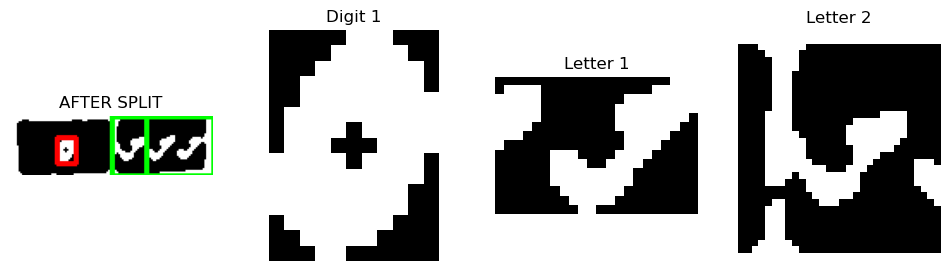

==== 0314_final.png ====


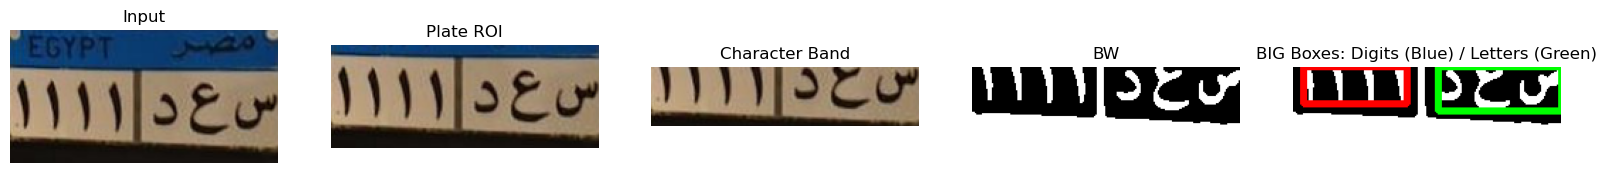

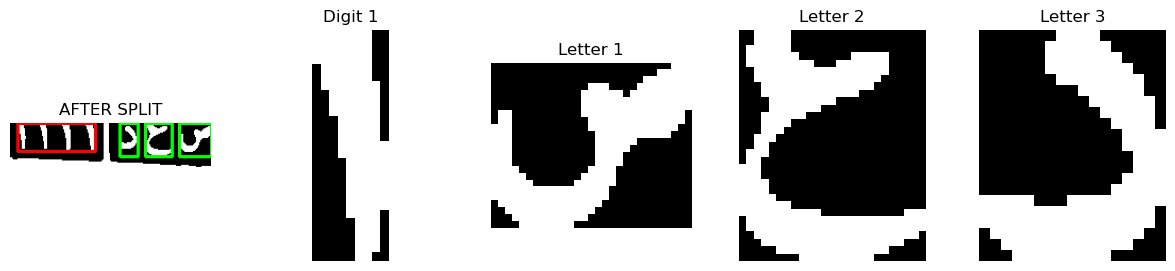

==== 0315_final.png ====


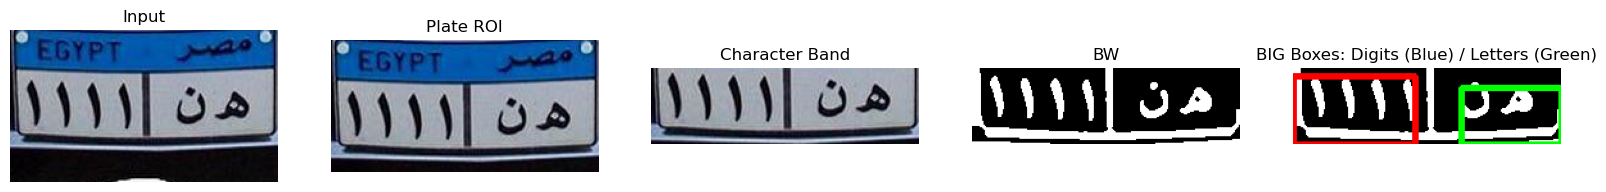

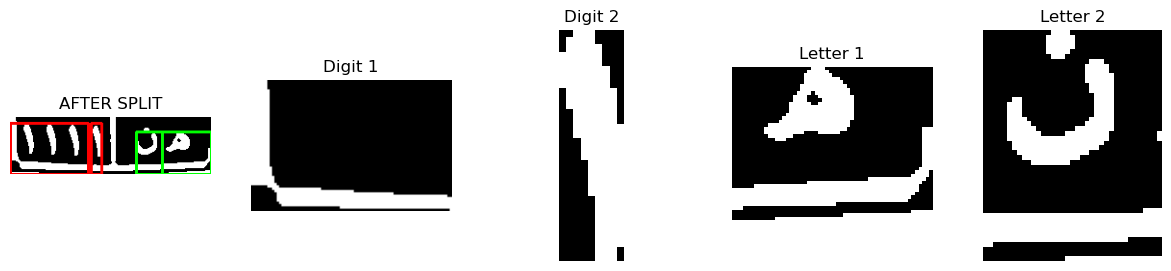

==== 0316_final.png ====


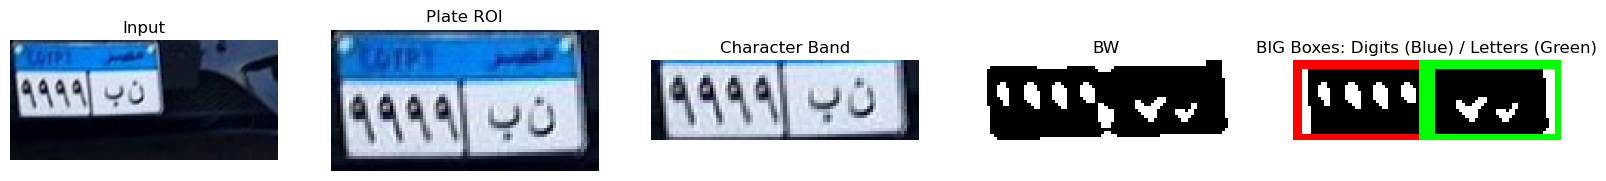

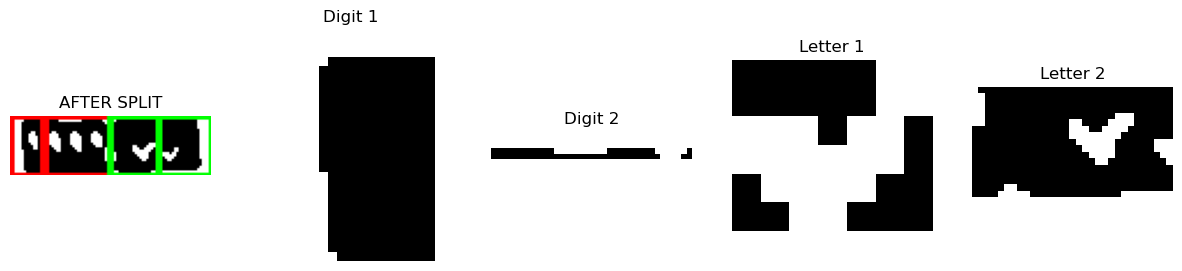

==== 0317_final.png ====


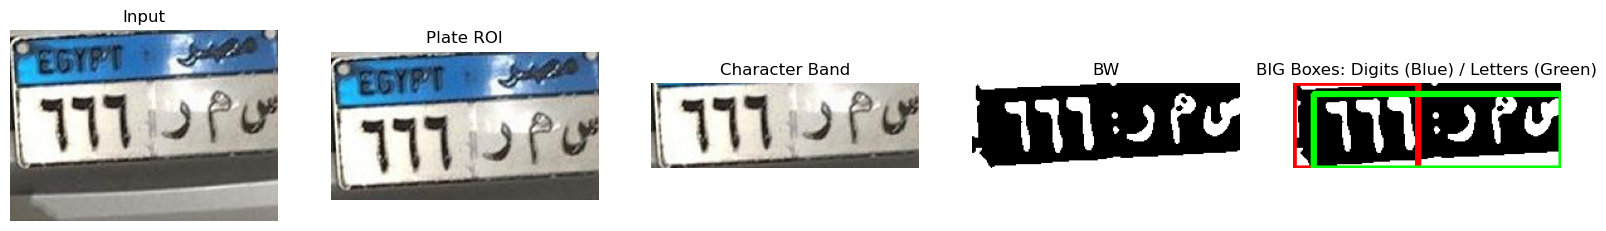

In [ ]:
'''
FORTNITE SEGMENT
'''


"""
FORT SEGMENT (Robust)
- Shows BIG boxes (digits / letters) first
- Splits into individual characters
- Produces tight-cropped characters (no internal frames/bars)
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt


# ============================================================
# VISUALIZATION
# ============================================================
def show_images(images, titles=None, figsize_scale=4):
    n = len(images)
    if titles is None:
        titles = [f"({i})" for i in range(n)]
    plt.figure(figsize=(figsize_scale * n, figsize_scale))
    for i, (img, t) in enumerate(zip(images, titles)):
        plt.subplot(1, n, i + 1)
        if img.ndim == 2:
            plt.imshow(img, cmap="gray")
        else:
            plt.imshow(img)
        plt.title(t)
        plt.axis("off")
    plt.show()


# ============================================================
# 1) PLATE ROI EXTRACTION (ROBUST)
# ============================================================
def extract_plate_roi(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 9, 60, 60)

    edges = cv2.Canny(gray, 80, 200)
    edges = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))

    cnts, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return img_bgr

    cnt = max(cnts, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)

    pad = int(0.03 * max(w, h))
    H, W = img_bgr.shape[:2]

    x0 = max(0, x - pad)
    y0 = max(0, y - pad)
    x1 = min(W, x + w + pad)
    y1 = min(H, y + h + pad)

    return img_bgr[y0:y1, x0:x1]


# ============================================================
# 2) CHARACTER BAND
# ============================================================
def crop_character_band(plate):
    H = plate.shape[0]
    return plate[int(0.35 * H):int(0.93 * H), :]


# ============================================================
# 3) BINARIZATION (ARABIC SAFE) + (optional) light border cleanup
# ============================================================
def binarize_clean(region):
    gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(2.5, (8, 8))
    gray = clahe.apply(gray)
    gray = cv2.medianBlur(gray, 5)

    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Gentle close: connect strokes but don't destroy holes too much
    bw = cv2.morphologyEx(
        bw, cv2.MORPH_CLOSE,
        cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)),
        iterations=1
    )

    # Gentle open: remove pepper noise
    bw = cv2.morphologyEx(
        bw, cv2.MORPH_OPEN,
        cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)),
        iterations=1
    )

    return bw


def clean_digit(ch):
    bin_ch = (ch > 0).astype(np.uint8)
    num, labels, stats, _ = cv2.connectedComponentsWithStats(bin_ch, 8)

    if num <= 1:
        return ch

    # Keep ONLY the largest component
    areas = stats[1:, cv2.CC_STAT_AREA]
    best = 1 + np.argmax(areas)

    out = np.zeros_like(ch)
    out[labels == best] = 255

    # Optional light cleanup to remove tiny edge noise
    out = cv2.morphologyEx(
        out,
        cv2.MORPH_OPEN,
        cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)),
        iterations=1
    )

    return out




def clean_letter(ch):
    bin_ch = (ch > 0).astype(np.uint8)
    num, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_ch, 8)

    if num <= 1:
        return ch

    H, W = ch.shape

    comps = []
    for i in range(1, num):
        x, y, w, h, area = stats[i]
        cx, cy = centroids[i]

        touches_border = (
            x == 0 or y == 0 or
            x + w == W or y + h == H
        )

        comps.append({
            "i": i,
            "x": x, "y": y, "w": w, "h": h,
            "cx": cx, "cy": cy,
            "area": area,
            "touch": touches_border
        })

    # === MAIN BODY ===
    body = max(
        [c for c in comps if not c["touch"]],
        key=lambda c: c["area"],
        default=max(comps, key=lambda c: c["area"])
    )

    out = np.zeros_like(ch)
    out[labels == body["i"]] = 255

    body_bottom = body["y"] + body["h"]

    # === ATTACH DOTS + TAILS ===
    for c in comps:
        if c["i"] == body["i"]:
            continue

        dx = abs(c["cx"] - body["cx"])
        dy = c["cy"] - body_bottom

        # ----- DOTS -----
        if c["area"] < 0.4 * body["area"]:
            if dx < 0.7 * W and abs(c["cy"] - body["cy"]) < 0.9 * H:
                out[labels == c["i"]] = 255

        # ----- TAIL (ج) -----
        # below body, vertically aligned, thin stroke
        if (
            dy > 0 and
            dy < 0.6 * H and
            dx < 0.25 * W and
            c["area"] > 0.12 * body["area"]
        ):
            out[labels == c["i"]] = 255

    return out






# ============================================================
# 4) CONNECTED COMPONENTS (for initial rough detection)
# ============================================================
def get_components(bw, min_area=40):
    num, lab, stats, _ = cv2.connectedComponentsWithStats((bw > 0).astype(np.uint8), 8)
    comps = []
    H, W = bw.shape

    for i in range(1, num):
        x, y, w, h, area = stats[i]
        if area < min_area:
            continue
        # avoid taking the whole BW as a component
        if w > 0.98 * W or h > 0.98 * H:
            continue
        comps.append([x, y, x + w, y + h, area])
    return comps


# ============================================================
# 5) MERGE DOTS (ج ، ق ، ف) into nearest body
# ============================================================
def attach_dots(boxes):
    big, dots = [], []
    for b in boxes:
        x0, y0, x1, y1, a = b
        if a < 600 and (x1 - x0) < 45 and (y1 - y0) < 45:
            dots.append(b)
        else:
            big.append(b)

    for dx0, dy0, dx1, dy1, _ in dots:
        dcx = (dx0 + dx1) / 2
        dcy = (dy0 + dy1) / 2

        best = None
        best_d = 1e18
        for i, (x0, y0, x1, y1, a) in enumerate(big):
            bx = (x0 + x1) / 2
            by = (y0 + y1) / 2
            d = (dcx - bx) ** 2 + 0.7 * (dcy - by) ** 2
            if d < best_d and abs(dcx - bx) < 50:
                best_d = d
                best = i

        if best is not None:
            big[best][0] = min(big[best][0], dx0)
            big[best][1] = min(big[best][1], dy0)
            big[best][2] = max(big[best][2], dx1)
            big[best][3] = max(big[best][3], dy1)

    return big


# ============================================================
# 6) CLASSIFY by POSITION (Egyptian plate: digits left, letters right)
#    This is much more stable across your samples.
# ============================================================
def split_digits_letters_by_position(boxes, bw_width):
    mid = bw_width / 2.0
    digits, letters = [], []

    for x0, y0, x1, y1, a in boxes:
        cx = (x0 + x1) / 2.0
        if cx < mid:
            digits.append((x0, y0, x1, y1))
        else:
            letters.append((x0, y0, x1, y1))

    # sort for display / later
    digits = sorted(digits, key=lambda b: b[0])                 # L->R
    letters = sorted(letters, key=lambda b: b[0], reverse=True) # R->L
    return digits, letters


# ============================================================
# 7) UNION BOX helper
# ============================================================
def union_box(boxes):
    if not boxes:
        return None
    x0 = min(b[0] for b in boxes)
    y0 = min(b[1] for b in boxes)
    x1 = max(b[2] for b in boxes)
    y1 = max(b[3] for b in boxes)
    return (x0, y0, x1, y1)


# ============================================================
# 8) SPLIT a GROUP BOX into characters using vertical projection
#    - Works for both digits and letters
#    - Includes forced-cut fallback for "سى" type merges
# ============================================================
def split_group_into_chars(bw, group_box, min_width_px=10, valley_ratio=0.18, force_cut=True):
    x0, y0, x1, y1 = group_box
    crop = bw[y0:y1, x0:x1]
    H, W = crop.shape

    if W < 25:
        return [group_box]

    proj = np.sum(crop > 0, axis=0).astype(np.float32)

    win = max(5, W // 18)
    proj_s = np.convolve(proj, np.ones(win) / win, mode="same")

    thresh = valley_ratio * (np.percentile(proj_s, 90))
    gaps = proj_s < thresh

    segments = []
    start = None
    for i in range(W):
        if not gaps[i] and start is None:
            start = i
        if gaps[i] and start is not None:
            if i - start >= min_width_px:
                segments.append((start, i))
            start = None
    if start is not None and (W - start) >= min_width_px:
        segments.append((start, W))


    
    # Normal case: multiple segments found
    if len(segments) >= 2:
        return [(x0 + s, y0, x0 + e, y1) for (s, e) in segments]
    



    # Fallback: force a cut for wide merged group (like سى)
    if force_cut and (W > 1.25 * H):
        L = int(0.35 * W)
        R = int(0.65 * W)
        cut = L + int(np.argmin(proj_s[L:R]))

        if 10 < cut < W - 10:
            left = (x0, y0, x0 + cut, y1)
            right = (x0 + cut, y0, x1, y1)

            lp = np.sum(crop[:, :cut] > 0)
            rp = np.sum(crop[:, cut:] > 0)
            total = np.sum(crop > 0) + 1e-9

            if lp > 0.12 * total and rp > 0.12 * total:
                return [left, right]

    return [group_box]


# ============================================================
# 9) CHARACTER CLEANING:
#    Keep the largest component that DOES NOT touch the crop border.
#    This removes the "frame bars" and random border blobs.
# ============================================================
def best_component_smart(ch):
    bin_ch = (ch > 0).astype(np.uint8)
    num, labels, stats, _ = cv2.connectedComponentsWithStats(bin_ch, 8)

    if num <= 1:
        return ch

    H, W = ch.shape

    components = []
    for lab in range(1, num):
        x, y, w, h, area = stats[lab]
        cx = x + w / 2
        cy = y + h / 2

        # border-touch check (frame / bars)
        touches_border = (
            x == 0 or y == 0 or
            x + w == W or y + h == H
        )

        components.append({
            "lab": lab,
            "area": area,
            "cx": cx,
            "cy": cy,
            "touches_border": touches_border
        })

    # 1) find MAIN body (largest non-border component)
    bodies = [c for c in components if not c["touches_border"]]
    if not bodies:
        bodies = components

    main = max(bodies, key=lambda c: c["area"])

    out = np.zeros_like(ch)
    out[labels == main["lab"]] = 255

    # 2) attach DOTS near main body
    for c in components:
        if c["lab"] == main["lab"]:
            continue

        # dot heuristic
        if c["area"] < 0.35 * main["area"]:
            dx = abs(c["cx"] - main["cx"])
            dy = abs(c["cy"] - main["cy"])

            if dx < 0.6 * W and dy < 0.8 * H:
                out[labels == c["lab"]] = 255

    return out




def tight_crop(ch):
    ys, xs = np.where(ch > 0)
    if len(xs) == 0:
        return ch
    return ch[ys.min():ys.max() + 1, xs.min():xs.max() + 1]


def normalize_to_square(ch, out_size=64, pad=4):
    ch = tight_crop(ch)
    h, w = ch.shape
    if h == 0 or w == 0:
        return np.zeros((out_size, out_size), dtype=np.uint8)

    scale = (out_size - 2 * pad) / max(h, w)
    nh, nw = max(1, int(h * scale)), max(1, int(w * scale))
    ch_rs = cv2.resize(ch, (nw, nh), interpolation=cv2.INTER_AREA)

    canvas = np.zeros((out_size, out_size), dtype=np.uint8)
    y0 = (out_size - nh) // 2
    x0 = (out_size - nw) // 2
    canvas[y0:y0 + nh, x0:x0 + nw] = ch_rs
    return canvas


def extract_chars_tight_and_norm(bw, boxes, kind, pad_box=4, out_size=64):
    tight_list = []
    norm_list = []
    H, W = bw.shape

    for (x0, y0, x1, y1) in boxes:
        x0p = max(0, x0 - pad_box)
        y0p = max(0, y0 - pad_box)
        x1p = min(W, x1 + pad_box)
        y1p = min(H, y1 + pad_box)

        ch = bw[y0p:y1p, x0p:x1p].copy()

        if kind == "digit":
            ch2 = clean_digit(ch)
        else:
            ch2 = clean_letter(ch)

        ch2 = tight_crop(ch2)

        tight_list.append(ch2)
        norm_list.append(normalize_to_square(ch2, out_size=out_size))

    return tight_list, norm_list



# ============================================================
# 10) MAIN PIPELINE
# ============================================================
def split_iteratively(bw, boxes, max_iters=3):
    out = boxes[:]
    for _ in range(max_iters):
        new = []
        changed = False
        for b in out:
            parts = split_group_into_chars(bw, b, force_cut=False)
            if len(parts) > 1:
                changed = True
                new.extend(parts)
            else:
                new.append(b)
        out = new
        if not changed:
            break
    return out





def segment_egypt_plate_chars(img_bgr, debug=True):
    plate = extract_plate_roi(img_bgr)
    band = crop_character_band(plate)
    bw = binarize_clean(band)

    comps = get_components(bw, min_area=40)
    #comps = attach_dots(comps)
    digits_tmp, letters_tmp = split_digits_letters_by_position(comps, bw.shape[1])

    letters_tmp = attach_dots([
        [b[0], b[1], b[2], b[3], (b[2]-b[0])*(b[3]-b[1])]
        for b in letters_tmp
    ])


    # rebuild comps
    comps = [(x0,y0,x1,y1,(x1-x0)*(y1-y0)) for (x0,y0,x1,y1) in digits_tmp] + letters_tmp







    digits_raw, letters_raw = split_digits_letters_by_position(comps, bw.shape[1])

    # BIG BOXES (what you want to show first)
    big_digit_box = union_box(digits_raw)
    big_letter_box = union_box(letters_raw)

    # If one side is empty due to weird thresholding, fallback to using position-based halves
    if big_digit_box is None:
        big_digit_box = (0, 0, bw.shape[1] // 2, bw.shape[0])
    if big_letter_box is None:
        big_letter_box = (bw.shape[1] // 2, 0, bw.shape[1], bw.shape[0])

    # Split each BIG box into individual characters
    digits_boxes = split_iteratively(bw, [big_digit_box])
    letters_boxes = split_group_into_chars(bw, big_letter_box, min_width_px=10, valley_ratio=0.18, force_cut=True)

    
    # Sort for reading
    digits_boxes = sorted(digits_boxes, key=lambda b: b[0])                 # L->R
    letters_boxes = sorted(letters_boxes, key=lambda b: b[0], reverse=True) # R->L

    # Extract tight + normalized
    digits_tight, digits_norm = extract_chars_tight_and_norm(
        bw, digits_boxes, kind="digit", pad_box=5
    )

    letters_tight, letters_norm = extract_chars_tight_and_norm(
        bw, letters_boxes, kind="letter", pad_box=5
    )



    if debug:
        # View 1: pipeline overview + BIG boxes
        vis_groups = cv2.cvtColor(bw, cv2.COLOR_GRAY2RGB)

        x0, y0, x1, y1 = big_digit_box
        cv2.rectangle(vis_groups, (x0, y0), (x1, y1), (255, 0, 0), 3)

        x0, y0, x1, y1 = big_letter_box
        cv2.rectangle(vis_groups, (x0, y0), (x1, y1), (0, 255, 0), 3)

        show_images(
            [
                cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB),
                cv2.cvtColor(plate, cv2.COLOR_BGR2RGB),
                cv2.cvtColor(band, cv2.COLOR_BGR2RGB),
                bw,
                vis_groups,
            ],
            ["Input", "Plate ROI", "Character Band", "BW", "BIG Boxes: Digits (Blue) / Letters (Green)"],
            figsize_scale=4,
        )

        # View 2: individual boxes after split
        vis_split = cv2.cvtColor(bw, cv2.COLOR_GRAY2RGB)
        for x0, y0, x1, y1 in digits_boxes:
            cv2.rectangle(vis_split, (x0, y0), (x1, y1), (255, 0, 0), 2)
        for x0, y0, x1, y1 in letters_boxes:
            cv2.rectangle(vis_split, (x0, y0), (x1, y1), (0, 255, 0), 2)

        '''
        show_images([vis_split], ["AFTER SPLIT: Individual Boxes"], figsize_scale=6)
  
        # View 3: tight crops (this is what you want visually)
        if digits_tight:
            show_images(digits_tight, [f"Digit {i+1}" for i in range(len(digits_tight))], figsize_scale=4)
        if letters_tight:
            show_images(letters_tight, [f"Letter {i+1}" for i in range(len(letters_tight))], figsize_scale=4)
        '''


        # ------------------------------------------------------------
        # COMBINED ROW:
        # [ AFTER SPLIT | Digits... | Letters... ]
        # ------------------------------------------------------------

        row2_images = []
        row2_titles = []

        # 1) AFTER SPLIT visualization
        row2_images.append(vis_split)
        row2_titles.append("AFTER SPLIT")

        # 2) Digits (left → right)
        for i, d in enumerate(digits_tight):
            row2_images.append(d)
            row2_titles.append(f"Digit {i+1}")

        # 3) Letters (right → left already sorted)
        for i, l in enumerate(letters_tight):
            row2_images.append(l)
            row2_titles.append(f"Letter {i+1}")

        show_images(
            row2_images,
            row2_titles,
            figsize_scale=3
        )



    # Return both (tight for viewing, norm for recognition)
    return {
        "bw": bw,
        "digits_boxes": digits_boxes,
        "letters_boxes": letters_boxes,
        "digits_tight": digits_tight,
        "letters_tight": letters_tight,
        "digits_norm64": digits_norm,
        "letters_norm64": letters_norm,
    }


# =========================
# RUN (single sample)
# =========================
# img_bgr = cropped_Plate4   # example
# out = segment_egypt_plate_chars(img_bgr, debug=True)

# =========================
# RUN (all samples)
# =========================
# for i in range(1, 40):
#     name = f"cropped_Plate{i}"
#     if name in globals():
#         print("====", name, "====")
#         segment_egypt_plate_chars(globals()[name], debug=True)





#images = [cropped_Plate4, cropped_Plate7, cropped_Plate8, cropped_Plate10, cropped_Plate12, cropped_Plate5, cropped_Plate9, cropped_Plate11]
#images = [cropped_Plate1, cropped_Plate2, cropped_Plate3, cropped_Plate4, cropped_Plate5, cropped_Plate6, cropped_Plate7, cropped_Plate8, cropped_Plate9, cropped_Plate10, cropped_Plate11, cropped_Plate12, cropped_Plate13, cropped_Plate14, cropped_Plate15, cropped_Plate16, cropped_Plate17, cropped_Plate18, cropped_Plate19, cropped_Plate20, cropped_Plate21, cropped_Plate22, cropped_Plate23, cropped_Plate24, cropped_Plate25, cropped_Plate26, cropped_Plate27, cropped_Plate28, cropped_Plate29, cropped_Plate30, cropped_Plate31, cropped_Plate32, cropped_Plate33, cropped_Plate34, cropped_Plate37, cropped_Plate38, cropped_Plate39]

'''
images = [
    globals()[f"cropped_Plate{i}"]
    for i in range(1, 40)
    if f"cropped_Plate{i}" in globals()
]




for i, img in enumerate(images, start=1):
    print(f"==== PLATE {i} ====")
    segment_egypt_plate_chars(img, debug=True)

'''


def load_images_from_folder(folder_path):
    images = []
    names = []

    for fname in sorted(os.listdir(folder_path)):
        if fname.lower().endswith((".jpg", ".png", ".jpeg", ".bmp")):
            path = os.path.join(folder_path, fname)
            img = cv2.imread(path)
            if img is not None:
                images.append(img)
                names.append(fname)

    return images, names

# =========================
# RUN (from folder)
# =========================

folder = r"Localization Test/FinalCrops"   # adjust if needed

images, names = load_images_from_folder(folder)

for img, name in zip(images, names):
    print(f"==== {name} ====")
    segment_egypt_plate_chars(img, debug=True)









# =========================
# RUN
# =========================
####img_bgr = cropped_Plate12   # change

#work: 4, 7, 8, 10, 12
#dont: 5, 9, 11
#digits, letters = segment_egypt_plate_chars(img_bgr, debug=True)
####out = segment_egypt_plate_chars(img_bgr, debug=True)

# Run all samples if you have cropped_Plate1..cropped_Plate39 in globals()
# for i in range(1, 40):
#     name = f"cropped_Plate{i}"
#     if name in globals():
#         print("====", name, "====")
#         segment_egypt_plate_chars(globals()[name], debug=False)



'''
FORTNITE SEGMENT
'''

In [ ]:
'''
MAAW NEW SEG
'''


import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import os
import glob


def extract_plate(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 80, 200)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    cnts, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key=cv2.contourArea)

    x,y,w,h = cv2.boundingRect(cnt)
    return img[y:y+h, x:x+w]


def crop_digits_letters_region(plate):
    h, w = plate.shape[:2]

    # Egyptian plate layout: bottom ~65% contains digits + letters
    y0 = int(0.35 * h)
    y1 = int(0.95 * h)

    return plate[y0:y1, :]


#

def binarize_for_split(region_bgr):
    gray = cv2.cvtColor(region_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN,
                          cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))
    return bw


def split_digits_letters(region_bgr):
    H, W = region_bgr.shape[:2]
    bw = binarize_for_split(region_bgr)

    # --- 1) Detect vertical separator line (strongest vertical structure) ---
    # Kernel عمودي طويل يلقط الخط الفاصل
    kH = max(15, int(0.7 * H))
    vert_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, kH))
    vert = cv2.morphologyEx(bw, cv2.MORPH_OPEN, vert_kernel)

    col_strength = np.sum(vert > 0, axis=0).astype(np.float32)

    # نبحث قريب من منتصف اللوحة فقط
    left = int(0.30 * W)
    right = int(0.80 * W)

    x_sep = left + int(np.argmax(col_strength[left:right]))
    sep_strength = col_strength[x_sep]

    # --- 2) Fallback: valley split (لو مفيش خط فاصل واضح) ---
    if sep_strength < 0.20 * H:  # لو الخط ضعيف
        col_sum = np.sum(bw > 0, axis=0).astype(np.float32)
        # smoothing
        win = max(15, W // 30)
        col_sum_s = np.convolve(col_sum, np.ones(win)/win, mode="same")

        left = int(0.35 * W)
        right = int(0.75 * W)
        x_sep = left + int(np.argmin(col_sum_s[left:right]))

    # قص حوالين الفاصل عشان ما يدخلش مع أي جانب
    pad = 4
    x_sep = max(10, min(W - 10, x_sep))

    digits = region_bgr[:, :max(0, x_sep - pad)]
    letters = region_bgr[:, min(W, x_sep + pad):]
    return digits, letters


#





def touches_border(x0, y0, x1, y1, W, H, margin=2):
    return (x0 <= margin) or (y0 <= margin) or (x1 >= W - margin) or (y1 >= H - margin)

#11
def binarize(region_bgr):
    gray = cv2.cvtColor(region_bgr, cv2.COLOR_BGR2GRAY)

    # Contrast boost WITHOUT exploding noise
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    # Median blur kills texture noise but keeps strokes
    gray = cv2.medianBlur(gray, 5)

    # Global threshold (stable for plates)
    _, bw = cv2.threshold(
        gray, 0, 255,
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    # Remove pepper noise only
    bw = cv2.morphologyEx(
        bw, cv2.MORPH_OPEN,
        cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    )

    return bw


def binarize_letters(region_bgr):
    gray = cv2.cvtColor(region_bgr, cv2.COLOR_BGR2GRAY)

    # mild contrast boost (don't overdo it)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    # small median (3) keeps dots better than 5
    gray = cv2.medianBlur(gray, 3)

    # OTSU is more stable than adaptive here
    bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    return bw


def build_group_mask_letters(bw):
    # specifically tuned to reconnect ج tail
    bw_g = cv2.morphologyEx(
        bw, cv2.MORPH_CLOSE,
        cv2.getStructuringElement(cv2.MORPH_RECT, (5,3))
    )
    bw_g = cv2.dilate(
        bw_g,
        cv2.getStructuringElement(cv2.MORPH_RECT, (3,5)),
        iterations=1
    )
    return bw_g




def merge_close_letter_boxes(boxes, H):
    """
    Merge boxes that are likely parts of the same Arabic letter (fixes ج split).
    Rule: merge if x-overlap is decent OR x-gap small, and y ranges are close/overlapping.
    """
    if not boxes:
        return boxes

    boxes = sorted(boxes, key=lambda b: b[0])
    merged = [list(boxes[0])]

    for x0,y0,x1,y1 in boxes[1:]:
        px0,py0,px1,py1 = merged[-1]

        # overlaps / gaps
        x_overlap = max(0, min(px1, x1) - max(px0, x0))
        x_gap = max(0, x0 - px1)

        # vertical relation
        y_overlap = max(0, min(py1, y1) - max(py0, y0))
        y_gap = max(0, max(y0 - py1, py0 - y1))

        # thresholds (tuned for plate letters)
        close_in_x = (x_overlap > 0) or (x_gap < 0.06 * (px1 - px0 + x1 - x0))
        close_in_y = (y_overlap > 0) or (y_gap < 0.18 * H)

        if close_in_x and close_in_y:
            merged[-1][0] = min(px0, x0)
            merged[-1][1] = min(py0, y0)
            merged[-1][2] = max(px1, x1)
            merged[-1][3] = max(py1, y1)
        else:
            merged.append([x0,y0,x1,y1])

    return [tuple(b) for b in merged]


def find_letter_boxes_and_dots(bw, bw_group):
    H, W = bw.shape
    labeled = label(bw_group)

    big_boxes = []
    candidate_small = []  # dot candidates

    for r in regionprops(labeled):
        y0, x0, y1, x1 = r.bbox
        h = y1 - y0
        w = x1 - x0
        area = r.area

        if touches_border(x0, y0, x1, y1, W, H, margin=2):
            continue

        # DOTS: keep them generous (so ف dot doesn't vanish)
        if 20 <= area <= 400 and h <= 0.35 * H and w <= 0.35 * W:
            # roughly dot-ish (avoid long strokes)
            ar = w / max(h, 1)
            if 0.4 <= ar <= 2.5:
                candidate_small.append((x0, y0, x1, y1))
                continue

        # LETTER BODY (relaxed so we don't drop ج)
        if area < 120:
            continue
        if h < 0.16 * H:
            continue
        if w < 0.02 * W:
            continue

        big_boxes.append((x0, y0, x1, y1))

    big_boxes = merge_close_letter_boxes(big_boxes, H)
    big_boxes = sorted(big_boxes, key=lambda b: b[0])

    return big_boxes, candidate_small

def recover_missing_fa(letter_boxes, dot_boxes, H):
    """
    If a dot exists with no nearby letter body,
    create a synthetic body box under it (for ف).
    """
    recovered = list(letter_boxes)

    for dx0, dy0, dx1, dy1 in dot_boxes:
        dcy = 0.5 * (dy0 + dy1)

        attached = False
        for x0,y0,x1,y1 in letter_boxes:
            if x0 - 10 <= (dx0+dx1)/2 <= x1 + 10:
                attached = True
                break

        if not attached:
            # Create a virtual body under the dot
            body_h = int(0.35 * H)
            recovered.append((
                dx0 - 10,
                int(dcy),
                dx1 + 10,
                min(H, int(dcy + body_h))
            ))

    return recovered


def attach_dots_to_boxes(letter_boxes, dot_boxes):
    merged = [list(b) for b in letter_boxes]

    for dx0, dy0, dx1, dy1 in dot_boxes:
        dcx = 0.5 * (dx0 + dx1)
        dcy = 0.5 * (dy0 + dy1)

        best_i = None
        best_score = 1e18

        for i, (x0,y0,x1,y1) in enumerate(merged):
            # dot should be horizontally near the letter
            if dcx < x0 - 15 or dcx > x1 + 15:
                continue

            # prefer dots above upper-half of the letter (ف/ق), but don't hard-reject
            # score: distance with extra penalty if dot is too low
            bx = 0.5 * (x0 + x1)
            by = 0.5 * (y0 + y1)

            penalty_low = 0.0
            if dcy > by:  # dot below center is unlikely
                penalty_low = 2000.0

            score = (dcx - bx)**2 + 0.7*(dcy - by)**2 + penalty_low

            if score < best_score:
                best_score = score
                best_i = i

        if best_i is not None:
            merged[best_i][0] = min(merged[best_i][0], dx0)
            merged[best_i][1] = min(merged[best_i][1], dy0)
            merged[best_i][2] = max(merged[best_i][2], dx1)
            merged[best_i][3] = max(merged[best_i][3], dy1)

    return [tuple(b) for b in merged]


def get_components_letters(region_bgr):
    bw = binarize_letters(region_bgr)          # extraction mask (keeps holes/dots)
    bw_group = build_group_mask_letters(bw)    # grouping mask (connects ج)

    big_boxes, dot_boxes = find_letter_boxes_and_dots(bw, bw_group)
    
    boxes = attach_dots_to_boxes(big_boxes, dot_boxes)
    boxes = recover_missing_fa(boxes, dot_boxes, bw.shape[0])

    boxes = merge_close_letter_boxes(sorted(boxes, key=lambda b: b[0]), bw.shape[0])
    boxes = sorted(boxes, key=lambda b: b[0])

    return bw, boxes




def get_letter_boxes_and_dots(bw):
    H, W = bw.shape

    # group mask: connect broken pieces a bit, but don’t destroy holes in the ORIGINAL bw
    bw_group = cv2.dilate(
        bw, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 5)), iterations=1
    )
    # small close to reconnect weak gaps (helps ج) but still mild
    bw_group = cv2.morphologyEx(
        bw_group, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    )

    labeled = label(bw_group)

    big_boxes = []
    small_boxes = []  # dots / small fragments

    for r in regionprops(labeled):
        y0, x0, y1, x1 = r.bbox
        h = y1 - y0
        w = x1 - x0
        area = r.area

        if touches_border(x0, y0, x1, y1, W, H, margin=2):
            continue

        # classify small components (dots)
        is_dot = (
            40 < area < 180 and           # real dots only
            h < 0.22 * H and
            w < 0.22 * W and
            0.6 < (w / max(h, 1)) < 1.6   # circular-ish
        )


        if is_dot:
            small_boxes.append((x0, y0, x1, y1))
            continue


        # relaxed constraints for letters (so ج doesn’t get chopped)
        if area < 120:
            continue
        if h < 0.18 * H:
            continue
        if w < 0.02 * W:
            continue

        big_boxes.append((x0, y0, x1, y1))

    big_boxes = sorted(big_boxes, key=lambda b: b[0])
    return big_boxes, small_boxes



def attach_dots_to_letter_boxes(big_boxes, small_boxes):
    merged = [list(b) for b in big_boxes]

    for sx0, sy0, sx1, sy1 in small_boxes:
        scx = 0.5 * (sx0 + sx1)
        scy = 0.5 * (sy0 + sy1)

        for i, (x0, y0, x1, y1) in enumerate(merged):
            # Dot must be horizontally inside letter
            if not (x0 - 10 <= scx <= x1 + 10):
                continue

            # Dot must be ABOVE letter body (ف, ق)
            if sy1 > y0:
                continue

            # Attach dot
            merged[i][0] = min(merged[i][0], sx0)
            merged[i][1] = min(merged[i][1], sy0)
            merged[i][2] = max(merged[i][2], sx1)
            merged[i][3] = max(merged[i][3], sy1)
            break

    return [tuple(b) for b in merged]













def get_components(region_bgr, kind="digits"):
    if kind == "digits":
        # Preserve thin strokes (important for ٦)
        gray = cv2.cvtColor(region_bgr, cv2.COLOR_BGR2GRAY)
        gray = cv2.medianBlur(gray, 3)   # NOT Gaussian
        _, bw = cv2.threshold(
            gray, 0, 255,
            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )
    else:
        bw = binarize(region_bgr)

    H, W = bw.shape

    # --- mask للتجميع فقط ---
    if kind == "letters":
        big_boxes, small_boxes = get_letter_boxes_and_dots(bw)
        boxes = attach_dots_to_letter_boxes(big_boxes, small_boxes)
        boxes = sorted(boxes, key=lambda b: b[0])
        return bw, boxes
    else:
        # digits: ممكن close صغير جدًا لو فيه انقطاع، أو سيبه bw_group=bw
        bw_group = cv2.morphologyEx(
            bw, cv2.MORPH_CLOSE,
            cv2.getStructuringElement(cv2.MORPH_RECT, (3,5))
        )

        min_area = 90        # was too aggressive
        min_h_ratio = 0.22   # allow shorter digits
        min_w_ratio = 0.02
        min_aspect = 0.07

    labeled = label(bw_group)
    boxes = []

    for r in regionprops(labeled):
        if r.area < min_area:
            continue

        y0, x0, y1, x1 = r.bbox
        h = y1 - y0
        w = x1 - x0

        # تجاهل أي شيء بيلمس الإطار (زي إطار اللوحة)
        if touches_border(x0, y0, x1, y1, W, H, margin=2):
            continue

        if h < min_h_ratio * H:
            continue
        if w < min_w_ratio * W:
            continue

        aspect = w / float(h)
        if aspect < min_aspect:
            continue

        boxes.append((x0, y0, x1, y1))

    boxes = sorted(boxes, key=lambda b: b[0])

    # رجّع الاتنين: الأصلي + البوكسات
    return bw, boxes


def extract_chars_from_mask(mask_bw, boxes, reverse=False, pad=2):
    # نقص من الـ mask الأصلي (مش bw_group) علشان holes تفضل موجودة
    boxes = sorted(boxes, key=lambda b: b[0], reverse=reverse)
    chars = []
    H, W = mask_bw.shape

    for x0,y0,x1,y1 in boxes:
        x0 = max(0, x0 - pad); y0 = max(0, y0 - pad)
        x1 = min(W, x1 + pad); y1 = min(H, y1 + pad)
        chars.append(mask_bw[y0:y1, x0:x1])

    return chars

#11


def draw_boxes(mask, boxes):
    out = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    for x0,y0,x1,y1 in boxes:
        cv2.rectangle(out,(x0,y0),(x1,y1),(255,0,0),2)
    return out




def trim_borders(img, px=6):
    h, w = img.shape[:2]
    return img[px:h-px, px:w-px]



#img_bgr = cropped_Plate1
#img_bgr = cropped_Plate2
#img_bgr = cropped_Plate3
#img_bgr = cropped_Plate4 #DONE
#img_bgr = cropped_Plate5
#img_bgr = cropped_Plate6
#img_bgr = cropped_Plate7
#img_bgr = cropped_Plate8
#img_bgr = cropped_Plate9
#img_bgr = cropped_Plate10
#img_bgr = cropped_Plate11
#img_bgr = cropped_Plate12
#img_bgr = cropped_Plate13
#img_bgr = cropped_Plate14
#img_bgr = cropped_Plate15
#img_bgr = cropped_Plate16
#img_bgr = cropped_Plate17
#img_bgr = cropped_Plate18
#img_bgr = cropped_Plate19
#img_bgr = cropped_Plate20
#img_bgr = cropped_Plate21
#img_bgr = cropped_Plate22
#img_bgr = cropped_Plate23
#img_bgr = cropped_Plate24
#img_bgr = cropped_Plate25
#img_bgr = cropped_Plate26
#img_bgr = cropped_Plate27
#img_bgr = cropped_Plate28
#img_bgr = cropped_Plate29
#img_bgr = cropped_Plate30
#img_bgr = cropped_Plate31
#img_bgr = cropped_Plate32
#img_bgr = cropped_Plate33
#img_bgr = cropped_Plate34
#img_bgr = cropped_Plate37
#img_bgr = cropped_Plate38
#img_bgr = cropped_Plate39

##########################################LOOOOOOOOOOP


def process_one_plate(img_bgr, plate_name="plate", save=True, show=True):
    """
    Process ONE Egyptian plate image end-to-end
    """

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    plate = extract_plate(img_bgr)

    dl_region = crop_digits_letters_region(plate)
    dl_region = trim_borders(dl_region, px=4)

    # Split digits / letters
    digits_region, letters_region = split_digits_letters(dl_region)

    # Extract components
    d_mask, d_boxes = get_components(digits_region, kind="digits")
    l_mask, l_boxes = get_components_letters(letters_region)

    # Keep at most 4 digits
    if len(d_boxes) > 4:
        d_boxes = sorted(
            d_boxes,
            key=lambda b: (b[2]-b[0])*(b[3]-b[1]),
            reverse=True
        )[:4]
        d_boxes = sorted(d_boxes, key=lambda b: b[0])

    # Keep at most 3 letters
    if len(l_boxes) > 3:
        l_boxes = sorted(
            l_boxes,
            key=lambda b: (b[2]-b[0])*(b[3]-b[1]),
            reverse=True
        )[:3]
        l_boxes = sorted(l_boxes, key=lambda b: b[0])

    digits  = extract_chars_from_mask(d_mask, d_boxes, reverse=False)
    letters = extract_chars_from_mask(l_mask, l_boxes, reverse=True)

    # ---------- SAVE ----------
    if save:
        BASE_OUT_DIR = "output_chars"
        DIGITS_DIR = os.path.join(BASE_OUT_DIR, "digits", plate_name)
        LETTERS_DIR = os.path.join(BASE_OUT_DIR, "letters", plate_name)

        os.makedirs(DIGITS_DIR, exist_ok=True)
        os.makedirs(LETTERS_DIR, exist_ok=True)

        TARGET_SIZE = (150, 150)

        for i, d in enumerate(digits):
            d_resized = cv2.resize(d, TARGET_SIZE, interpolation=cv2.INTER_AREA)
            cv2.imwrite(os.path.join(DIGITS_DIR, f"digit_{i}.png"), d_resized)

        for i, l in enumerate(letters):
            l_resized = cv2.resize(l, TARGET_SIZE, interpolation=cv2.INTER_AREA)
            cv2.imwrite(os.path.join(LETTERS_DIR, f"letter_{i}.png"), l_resized)

    # ---------- VISUALIZE ----------
    if show:
        d_boxes_img = draw_boxes(d_mask, d_boxes)
        l_boxes_img = draw_boxes(l_mask, l_boxes)

        show_images(
            [
                img_rgb,
                cv2.cvtColor(plate, cv2.COLOR_BGR2RGB),
                cv2.cvtColor(dl_region, cv2.COLOR_BGR2RGB),
                cv2.cvtColor(digits_region, cv2.COLOR_BGR2RGB),
                cv2.cvtColor(letters_region, cv2.COLOR_BGR2RGB),
            ],
            ["Original", "Plate Crop", "Digits+Letters", "Digits Region", "Letters Region"]
        )

        show_images([d_mask, l_mask], ["Digits Mask", "Letters Mask"])
        show_images([d_boxes_img, l_boxes_img], ["Digits Boxes", "Letters Boxes"])

        if digits:
            show_images(digits, [f"Digit {i+1}" for i in range(len(digits))])
        if letters:
            show_images(letters, [f"Letter {i+1}" for i in range(len(letters))])

    return {
        "digits": digits,
        "letters": letters,
        "d_boxes": d_boxes,
        "l_boxes": l_boxes
    }






'''
images = [
    globals()[f"cropped_Plate{i}"]
    for i in range(1, 40)
    if f"cropped_Plate{i}" in globals()
]

for i, img in enumerate(images, start=1):
    print(f"\n===== Processing Plate {i} =====")
    process_one_plate(
        img,
        plate_name=f"plate_{i}",
        save=True,
        show=True
    )
'''


def load_images_from_folder(folder_path):
    images = []
    names = []

    for fname in sorted(os.listdir(folder_path)):
        if fname.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
            path = os.path.join(folder_path, fname)
            img = cv2.imread(path)
            if img is not None:
                images.append(img)
                names.append(os.path.splitext(fname)[0])  # name without extension

    return images, names


# =========================
# RUN FROM FOLDER
# =========================

INPUT_FOLDER = r"Localization Test/FinalCrops"   # change if needed

images, names = load_images_from_folder(INPUT_FOLDER)

for img, name in zip(images, names):
    print(f"\n===== Processing {name} =====")
    process_one_plate(
        img,
        plate_name=name,   # used for output folder naming
        save=True,
        show=True
    )





#############################################LOOOOOOOOOOOOP






'''#REMOVE TO FIX






img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plate = extract_plate(img_bgr)

dl_region = crop_digits_letters_region(plate)
dl_region = trim_borders(dl_region, px=4)

# FINAL robust split
digits_region, letters_region = split_digits_letters(dl_region)

d_mask, d_boxes = get_components(digits_region, kind="digits")
l_mask, l_boxes = get_components_letters(letters_region)




# Keep at most 4 digits: choose by area (largest blobs)
if len(d_boxes) > 4:
    d_boxes = sorted(d_boxes, key=lambda b: (b[2]-b[0])*(b[3]-b[1]), reverse=True)[:4]
    d_boxes = sorted(d_boxes, key=lambda b: b[0])

# Keep at most 3 letters: choose by area (largest blobs)
if len(l_boxes) > 3:
    l_boxes = sorted(l_boxes, key=lambda b: (b[2]-b[0])*(b[3]-b[1]), reverse=True)[:3]
    l_boxes = sorted(l_boxes, key=lambda b: b[0])





BASE_OUT_DIR = "output_chars"
#BASE_OUT_DIR = "Image-Processing-Project"
DIGITS_DIR = os.path.join(BASE_OUT_DIR, "digits")
LETTERS_DIR = os.path.join(BASE_OUT_DIR, "letters")

os.makedirs(DIGITS_DIR, exist_ok=True)
os.makedirs(LETTERS_DIR, exist_ok=True)

def clear_old_files(folder, pattern):
    for f in glob.glob(os.path.join(folder, pattern)):
        os.remove(f)

# Clear previous results
clear_old_files(DIGITS_DIR, "digit_*.png")
clear_old_files(LETTERS_DIR, "letter_*.png")





digits  = extract_chars_from_mask(d_mask, d_boxes, reverse=False)
letters = extract_chars_from_mask(l_mask, l_boxes, reverse=True)


TARGET_SIZE = (150, 150)

# Save digits
for i, d in enumerate(digits):
    d_resized = cv2.resize(d, TARGET_SIZE, interpolation=cv2.INTER_AREA)
    save_path = os.path.join(DIGITS_DIR, f"digit_{i}.png")
    cv2.imwrite(save_path, d_resized)

# Save letters
for i, l in enumerate(letters):
    l_resized = cv2.resize(l, TARGET_SIZE, interpolation=cv2.INTER_AREA)
    save_path = os.path.join(LETTERS_DIR, f"letter_{i}.png")
    cv2.imwrite(save_path, l_resized)





d_boxes_img = draw_boxes(d_mask, d_boxes)
l_boxes_img = draw_boxes(l_mask, l_boxes)


show_images(
    [
        img_rgb,
        cv2.cvtColor(plate, cv2.COLOR_BGR2RGB),
        cv2.cvtColor(dl_region, cv2.COLOR_BGR2RGB),
        cv2.cvtColor(digits_region, cv2.COLOR_BGR2RGB),
        cv2.cvtColor(letters_region, cv2.COLOR_BGR2RGB)
    ],
    ["Original", "Plate Crop", "Digits+Letters", "Digits Region", "Letters Region"]
)


show_images([d_mask, l_mask], ["Digits Mask", "Letters Mask"])
show_images([d_boxes_img, l_boxes_img], ["Digits Boxes", "Letters Boxes"])

show_images(digits, [f"Digit {i+1}" for i in range(len(digits))])
show_images(letters, [f"Letter {i+1}" for i in range(len(letters))])





'''#REMOVE TO FIX




'''
MAAW NEW SEG
'''

In [ ]:
'''
MAAW SEGMENTATION
'''

'''



import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb
from skimage.filters import threshold_otsu
from skimage.morphology import (
    remove_small_holes,
    remove_small_objects,
    binary_closing,
    square,
)
from skimage.measure import label, regionprops
from skimage.transform import resize
from skimage.color import gray2rgb


def crop_bottom(img, top_ratio=0.40):
    h, w = img.shape[:2]
    return img[int(h * top_ratio):, :]


def split_digits_letters(bottom):
    h, w = bottom.shape[:2]
    mid = w // 2
    return bottom[:, :mid], bottom[:, mid:]


def get_mask(region):
    gray = rgb2gray(region)

    T = threshold_otsu(gray)
    mask = gray < T

    mask = remove_small_objects(mask, 25)

    return mask






def touches_border(r0, c0, r1, c1, H, W, margin_ratio=0.005):
    mr = int(margin_ratio * H)
    mc = int(margin_ratio * W)

    if r0 <= mr: return True        # top
    if c0 <= mc: return True        # left
    if r1 >= H - mr: return True    # bottom
    if c1 >= W - mc: return True    # right

    return False



def extract_digits(digits_region, max_chars=4, debug=False):
    H0, W0 = digits_region.shape[:2]
    border_ratio = 0.04
    by = int(border_ratio * H0)
    bx = int(border_ratio * W0)
    sub = digits_region[by:H0 - by, bx:W0 - bx]
    
    mask = get_mask(sub)
    H, W = mask.shape
    
    def remove_frame_components(mask):
        H, W = mask.shape
        lbl = label(mask)

        for p in regionprops(lbl):
            r0, c0, r1, c1 = p.bbox
            h = r1 - r0
            w = c1 - c0

            wr = w / (W + 1e-6)
            hr = h / (H + 1e-6)

            near_edge = (r0 < 0.20 * H) or (r1 > 0.80 * H) #very wide, thin, near top or bottom

            if near_edge and wr > 0.75 and hr < 0.12:
                mask[lbl == p.label] = 0

        return mask

    mask = remove_frame_components(mask)
    
    def touches_top_or_bottom(r0, r1, H, margin=2):
        return r0 <= margin or r1 >= H - margin

    def is_horizontal_frame(h, w, H, W, r0, r1):
        very_wide = w > 0.65 * W
        very_thin = h < 0.12 * H
        near_edge = r0 < 0.15 * H or r1 > 0.85 * H
        return very_wide and very_thin and near_edge



    lbl = label(mask)

    candidates = []
    for p in regionprops(lbl):
        r0, c0, r1, c1 = p.bbox

        if touches_top_or_bottom(r0, r1, H):
            continue

        h = r1 - r0
        w = c1 - c0
        area = p.area
        wr = w / W
        ar = area / (H * W)

        if is_horizontal_frame(h, w, H, W, r0, r1):
            continue

        if wr < 0.035 or wr > 0.75:
            continue

        if ar < 0.001:
            continue

        candidates.append({"bbox": [r0, c0, r1, c1], "area": area})

    candidates.sort(key=lambda c: c["bbox"][1])


    merged = []
    for c in candidates:
        if not merged:
            merged.append(c)
            continue

        r0, c0, r1, c1 = c["bbox"]
        r0m, c0m, r1m, c1m = merged[-1]["bbox"]

        overlap_x = min(c1, c1m) - max(c0, c0m)
        overlap_y = min(r1, r1m) - max(r0, r0m)

        #only merge if they overlap in X and Y or very close vertically
        vertical_gap = max(r0, r0m) - min(r1, r1m) #negative means it overlaps

        if overlap_x > 0 and (overlap_y > 0 or vertical_gap < 0.08 * H):
            merged[-1]["bbox"] = [
                min(r0, r0m), min(c0, c0m),
                max(r1, r1m), max(c1, c1m)
            ]
        else:
            merged.append(c)

    boxed_mask = gray2rgb(mask.astype(np.uint8) * 255)

    chars = []
    for m in merged:
        r0, c0, r1, c1 = m["bbox"]
        if (r1 - r0) < 0.22 * H:
            continue

        boxed_mask[r0:r1, [c0, c1-1]] = [255, 0, 0]
        boxed_mask[[r0, r1-1], c0:c1] = [255, 0, 0]

        crop = resize(mask[r0:r1, c0:c1].astype(float), (40, 40))
        chars.append((c0 + bx, crop))

    chars.sort(key=lambda x: x[0])

    if debug:
        return [c for _, c in chars][:max_chars], mask, boxed_mask
    else:
        return [c for _, c in chars][:max_chars]



def extract_letters(letters_region, max_chars=3, debug=False):
    H0, W0 = letters_region.shape[:2]
    by = int(0.04 * H0)
    bx = int(0.04 * W0)
    sub = letters_region[by:H0 - by, bx:W0 - bx]

    mask = get_mask(sub)
    H, W = mask.shape
    lbl = label(mask)

    boxed_mask = gray2rgb(mask.astype(np.uint8) * 255)

    big_blobs = []   #letter body
    small_blobs = [] #dots


    for p in regionprops(lbl):
        r0, c0, r1, c1 = p.bbox

        if touches_border(r0, c0, r1, c1, H, W, margin_ratio=0.02):
            continue
    
        h = r1 - r0
        w = c1 - c0
        area = p.area
        cy = p.centroid[0] / H
        wr = w / W
        ar = area / (H * W)

        #dot (area < 0.015)
        if ar < 0.015:
            small_blobs.append((r0, c0, r1, c1))
            continue

        #main letter filtering
        if wr < 0.08 or wr > 0.75:
            continue
        if ar > 0.22:
            continue
        if cy > 0.75:
            continue

        big_blobs.append([r0, c0, r1, c1])


    for dr0, dc0, dr1, dc1 in small_blobs:
        dc = (dc0 + dc1) / 2
        dr = (dr0 + dr1) / 2

        best_i = -1
        best_dx = 1e9

        for i, box in enumerate(big_blobs):
            r0, c0, r1, c1 = box
            bc = (c0 + c1) / 2
            br = (r0 + r1) / 2

            dx = abs(dc - bc)
            dy = abs(dr - br)

            #vertically and horizontally closest
            if dx < best_dx and dy < 120:
                best_dx = dx
                best_i = i

        #attach dot to nearest valid letter ONLY
        if best_i != -1:
            box = big_blobs[best_i]
            box[0] = min(box[0], dr0)
            box[1] = min(box[1], dc0)
            box[2] = max(box[2], dr1)
            box[3] = max(box[3], dc1)


    big_blobs.sort(key=lambda b: b[1])


    #new
    # ---------- MERGE BROKEN LETTER BODIES (e.g. س) ----------
    merged = []
    for box in sorted(big_blobs, key=lambda b: b[1]):
        if not merged:
            merged.append(box)
            continue

        r0, c0, r1, c1 = box
        pr0, pc0, pr1, pc1 = merged[-1]

        # horizontal gap
        gap = c0 - pc1

        # vertical overlap
        overlap = min(r1, pr1) - max(r0, pr0)

        if gap < 0.15 * W and overlap > 0.3 * min(r1 - r0, pr1 - pr0):
            # merge
            merged[-1] = [
                min(r0, pr0),
                min(c0, pc0),
                max(r1, pr1),
                max(c1, pc1)
            ]
        else:
            merged.append(box)

    big_blobs = merged

    #new





    chars = []
    for r0, c0, r1, c1 in big_blobs:
        boxed_mask[r0:r1, [c0, c1-1]] = [255, 0, 0]
        boxed_mask[[r0, r1-1], c0:c1] = [255, 0, 0]

        crop = resize(mask[r0:r1, c0:c1].astype(float), (40, 40))
        chars.append((c0 + bx, crop))

    if debug:
        return [c for _, c in chars][:max_chars], mask, boxed_mask
    else:
        return [c for _, c in chars][:max_chars]



def process_plate(img):
    bottom = crop_bottom(img)
    digits_region, letters_region = split_digits_letters(bottom)

    digits, d_mask, d_boxes = extract_digits(digits_region, debug=True)
    letters, l_mask, l_boxes = extract_letters(letters_region, debug=True)

    return digits_region, letters_region, digits, letters, d_mask, d_boxes, l_mask, l_boxes


img22 = imread('Q1.jpg')
#img22 = imread('Dataset/Buses & government vehicles.png')
#img22 = imread('Dataset/Diplomatic vehicles.png')
#img22 = imread('Dataset/image.png')
#img22 = imread('Dataset/Limousines & tourist buses.png')
#img22 = imread('Dataset/Police vehicles.png')
# img22 = rgba2rgb(imread('Dataset/Private vehicles & motorcycles.png'))
#img22 = rgba2rgb(imread('Dataset/Taxis.png'))
#img22 = imread('Dataset/Trucks.png')
#img22 = imread('Dataset/Vehicles with unpaid customs.png')

#etsh cropped tests########################
# img22 = cropped_Plate1
# img22 = cropped_Plate2 #blur problem
#img22 = rgba2rgb(imread('Q1C.png'))
# img22 = cropped_Plate3 #blur problem
# img22 = cropped_Plate5 #FIXED frame counting as letter from left
# img22 = cropped_Plate11 #FIXED digit border on top detected  
# img22 = cropped_Plate12 #FIXED border in digit detected
# img22 = cropped_Plate13 #FIXED border detected as letter
#img22 = cropped_Plate15 #blur problem
#img22 = cropped_Plate111 ##
#img22 = cropped_Plate112 #blur problem
#img22 = cropped_Plate113 #blur problem
#img22 = cropped_Plate115 ##
#img22 = cropped_Plate1111 #hard angle
#img22 = cropped_Plate1112 #hard angle
#img22 = cropped_Plate1113 #blur problem
#img22 = cropped_Plate1115 #blur
#img22 = cropped_Plate11113 #blur
#img22 = cropped_Plate11114 ##
#img22 = cropped_Plate11115 ##
#img22 = cropped_Plate11116 ##
#img22 = cropped_Plate11117 ##

#etsh cropped tests########################




import os

def clear_previous_outputs():
    files = [
        "digit_0.png", "digit_1.png", "digit_2.png", "digit_3.png", "digit_4.png", "letter_0.png", "letter_1.png", "letter_2.png"
    ]

    for f in files:
        if os.path.exists(f):
            os.remove(f)


def save_characters(digits, letters):
    #digits
    for i, img in enumerate(digits):
        out = (img * 255).astype(np.uint8) if img.dtype != np.uint8 else img
        cv2.imwrite(f"digit_{i}.png", out)

    #letters
    for i, img in enumerate(letters):
        out = (img * 255).astype(np.uint8) if img.dtype != np.uint8 else img
        cv2.imwrite(f"letter_{i}.png", out)


clear_previous_outputs()

d_reg, l_reg, digits, letters, d_mask, d_boxes, l_mask, l_boxes = process_plate(img22)






show_images([d_reg, l_reg], ["Digits Region", "Letters Region"])

show_images([d_mask, l_mask], ["Digits Mask", "Letters Mask"])

show_images([d_boxes, l_boxes], ["Digits Mask + Boxes", "Letters Mask + Boxes"])

digit_titles = [f"Digit {i}" for i in range(len(digits))]
show_images(digits, digit_titles)

letter_titles = [f"Letter {i}" for i in range(len(letters))]
show_images(letters, letter_titles)


save_characters(digits,letters)


#RUN LOOP

for i in range(1, 40):
    img = globals()[f"cropped_Plate{i}"]

    (
        d_reg, l_reg,
        digits, letters,
        d_mask, d_boxes,
        l_mask, l_boxes
    ) = process_plate(img)

    show_images([d_reg, l_reg], ["Digits Region", "Letters Region"])
    show_images([d_mask, l_mask], ["Digits Mask", "Letters Mask"])
    show_images([d_boxes, l_boxes], ["Digits Mask + Boxes", "Letters Mask + Boxes"])

    digit_titles = [f"Digit {j}" for j in range(len(digits))]
    show_images(digits, digit_titles)

    letter_titles = [f"Letter {j}" for j in range(len(letters))]
    show_images(letters, letter_titles)


#RUN LOOP


'''
'''
MAAW SEGMENTATION
'''
        

In [ ]:
'''
MAAW DIGIT AND LETTER RECOGNITION
'''
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import os


english_to_arabic = {
    1: '١',
    2: '٢',
    3: '٣',
    4: '٤',
    5: '٥',
    6: '٦',
    7: '٧',
    8: '٨',
    9: '٩'
    }


def normalize_digit(img):
    img = img.copy()

    if np.mean(img) > 127:
        img = cv2.bitwise_not(img)

    ys, xs = np.where(img > 0)
    if len(xs) == 0:
        return cv2.resize(img, (64, 64))

    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()
    img = img[y0:y1+1, x0:x1+1]

    img = cv2.copyMakeBorder(img, 12, 12, 12, 12, cv2.BORDER_CONSTANT, value=0)

    img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_NEAREST)
    return img.astype(np.uint8)


def match_digit(img, refs_folder="digits_reference"):
    img = normalize_digit(img)

    scores = {}

    for d in range(1,10):
        digit_folder = os.path.join(refs_folder, str(d))
        if not os.path.exists(digit_folder):
            continue

        best_local = -1

        for fname in os.listdir(digit_folder):
            ref = cv2.imread(os.path.join(digit_folder, fname), 0)
            ref = normalize_digit(ref)

            score = ssim(img, ref)
            best_local = max(best_local, score)

        scores[d] = best_local

    best_digit = max(scores, key=scores.get)

    return best_digit

final_digits_english = []
final_digits_arabic  = []

for d in digits:
    d_img = d.astype(np.uint8) 
    digit = match_digit(d_img)

    final_digits_english.append(str(digit))
    final_digits_arabic.append(english_to_arabic[digit])

print("Plate Digits In English:", "".join(final_digits_english))
print("Plate Digits In Arabic: ", "".join(final_digits_arabic))



letter_id_to_arabic = {
    1: 'أ',
    2: 'ب',
    3: 'ج',
    4: 'د',
    5: 'ر',
    6: 'ز',
    7: 'س',
    8: 'ص',
    9: 'ض',
    10: 'ط',
    11: 'ع',
    12: 'ف',
    13: 'ق',
    14: 'ك',
    15: 'ل',
    16: 'م',
    17: 'ن',
    18: 'ه',
    19: 'و',
    20: 'ي',
    21: 'ى'
}


def normalize_letter(img):
    img = img.copy()

    if np.mean(img) > 127:
        img = cv2.bitwise_not(img)

    ys, xs = np.where(img > 0)
    if len(xs) == 0:
        return cv2.resize(img, (64, 64))

    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()
    img = img[y0:y1+1, x0:x1+1]

    img = cv2.copyMakeBorder(
        img, 12, 12, 12, 12,
        cv2.BORDER_CONSTANT, value=0
    )

    img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_NEAREST)
    return img.astype(np.uint8)



def match_letter(img, refs_folder="letters_reference"):
    img = normalize_letter(img)

    scores = {}

    for letter_id in range(1, 22):
        letter_folder = os.path.join(refs_folder, str(letter_id))
        if not os.path.exists(letter_folder):
            continue

        best_local = -1

        for fname in os.listdir(letter_folder):
            ref = cv2.imread(os.path.join(letter_folder, fname), 0)
            if ref is None:
                continue

            ref = normalize_letter(ref)
            score = ssim(img, ref)
            best_local = max(best_local, score)

        scores[letter_id] = best_local

    best_letter_id = max(scores, key=scores.get)
    return best_letter_id


final_letters_arabic = []

for l in letters:
    l_img = l.astype(np.uint8)   
    letter_id = match_letter(l_img)


    final_letters_arabic.append(letter_id_to_arabic[letter_id])

final_plate_letters = " ".join(final_letters_arabic[::-1])

print("Plate Letters: ", final_plate_letters)



'''
MAAW DIGIT AND LETTER RECOGNITION
'''

In [ ]:
import pytesseract
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os
import easyocr
os.environ['TESSDATA_PREFIX'] = os.path.abspath("Dataset")
# os.environ.pop('TESSDATA_PREFIX', None)
def add_padding(img, pad=10):
    return cv2.copyMakeBorder(
        img, pad, pad, pad, pad,
        borderType=cv2.BORDER_CONSTANT,
        value=255
    )

def add_paddingblack(img, pad=50):
    return cv2.copyMakeBorder(
        img, pad, pad, pad, pad,
        borderType=cv2.BORDER_CONSTANT,
        value=0
    )


def pad_for_easyocr(img):
    h, w = img.shape
    new_img = np.zeros((h, w*3), dtype=np.uint8)  # black background
    new_img[:, w:w*2] = img  # center the character
    return new_img


def recognize_arabic_digit(image_path, show_preprocessed=False):
    """
    Recognize a single Arabic digit from an image.
    
    Args:
        image_path (str): Path to image file.
        show_preprocessed (bool): If True, shows the binary preprocessed image.
    
    Returns:
        str: Detected Arabic digit or empty string if not recognized.
    """
    
    # 1. Load image
    img = io.imread(image_path)
    # img=add_paddingblack(img)
    # img=pad_for_easyocr(img)
    
    # img=add_padding(img)
    # img=d_mask
    if img.dtype == bool:
        img = (img * 255).astype(np.uint8)

    # # Ensure grayscale, not weird format
    # if len(img.shape) == 2:
    #     img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    # # 2. Convert to grayscale if needed
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
    
    # # 3. Resize image up to help OCR
    # gray = cv2.resize(gray, None, fx=5, fy=5, interpolation=cv2.INTER_LINEAR)
    
    # # 4. Smooth image to reduce noise
    # blur = cv2.GaussianBlur(gray, (3,3), 0)
    
    # # 5. Threshold to get binary image
    # _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # # 6. Invert if background is dark
    # if np.mean(thresh) < 127:
    #     thresh = cv2.bitwise_not(thresh)
    
    # # Optional: show preprocessed image
    if show_preprocessed:
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
    
    # 7. Configure Tesseract for single character + Arabic digits only
    # config = f'--oem 3 --psm 10 -c tessedit_char_whitelist={ARABIC_DIGITS}'
    
    # 8. Run OCR
    # text = pytesseract.image_to_string(thresh, lang='ara')

    reader = easyocr.Reader(['ar'])
    results = reader.readtext(img)
    texts = [text for bbox, text, prob in results]


    # 9. Clean result
    # text = text.strip()
    return texts

# Example usage:
digit = recognize_arabic_digit("letter_0.png", show_preprocessed=True)
print("Detected Arabic digit EASYOCR:", repr(digit))
# print("Detected Arabic digit:", repr(digit))


In [ ]:
import easyocr
import cv2
import numpy as np

reader = easyocr.Reader(['ar'], gpu=False)  # make this global or at module level

def prepare_for_easyocr_char(img):
    """
    img: numpy array (grayscale or RGB) containing ONE character.
    Returns a padded, upscaled image suitable for EasyOCR.
    """

    # If bool -> uint8
    if img.dtype == bool:
        img = (img * 255).astype(np.uint8)

    # Convert to grayscale
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img = img.astype(np.uint8)

    # Normalize range
    if img.max() <= 1:
        img = (img * 255).astype(np.uint8)

    # Binarize a bit to stabilize
    _, img = cv2.threshold(img, 0, 255,
                           cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Make sure text is dark on light (helps EasyOCR)
    if img.mean() < 127:      # mostly dark => likely white on black
        img = 255 - img       # invert to black text on white

    # ---- FIX #1: add margin so glyph doesn't touch borders ----
    border = 20
    img = cv2.copyMakeBorder(
        img, border, border, border, border,
        borderType=cv2.BORDER_CONSTANT,
        value=255  # white background
    )

    # ---- FIX #2: upscale ----
    img = cv2.resize(img, None, fx=5, fy=5,
                     interpolation=cv2.INTER_LINEAR)

    return img


def recognize_single_char_easyocr(image_path, show=False):
    # load from file
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    prep = prepare_for_easyocr_char(img)

    if show:
        import matplotlib.pyplot as plt
        plt.imshow(prep, cmap='gray')
        plt.axis('off'); plt.show()

    # detail=0 -> just texts; paragraph=False so it doesn't merge things
    texts = reader.readtext(prep, detail=0, paragraph=False)

    return texts[0] if texts else ""

digit0 = recognize_single_char_easyocr("clean_digits.png", show=True)
letter0 = recognize_single_char_easyocr("clean_letters.png", show=True)
print("digit_0:", repr(digit0))
print("letter_0:", repr(letter0))


In [ ]:
'''
MAAW FORTNITE BATTLE ROYALE
'''

import numpy as np
import matplotlib.pyplot as plt
import cv2                         ### <<< you were using cv2 in save_characters

from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb
from skimage.filters import threshold_otsu
from skimage.morphology import (
    remove_small_holes,
    remove_small_objects,
    binary_closing,
    square,
)
from skimage.measure import label, regionprops
from skimage.transform import resize
from skimage.color import gray2rgb


# ---------------------------------------------------
# 1) SIMPLE GEOMETRIC UTILITIES
# ---------------------------------------------------

def crop_bottom(img, top_ratio=0.40):
    """
    Keep the lower part of the plate (digits + letters).
    top_ratio is the fraction of height we cut from the top.
    """
    h, w = img.shape[:2]
    return img[int(h * top_ratio):, :]


def split_digits_letters(bottom):
    """
    Egyptian plate: digits on the left half, letters on the right half.
    """
    h, w = bottom.shape[:2]
    mid = w // 2
    return bottom[:, :mid], bottom[:, mid:]


def get_mask(region):
    gray = rgb2gray(region)
    T = threshold_otsu(gray)
    mask = gray < T

    # ✅ KEEP holes & dots (light cleaning only)
    mask = remove_small_objects(mask, 25)
    return mask


# ---------------------------------------------------
# Helper: create a crop that is friendly for OCR
# ---------------------------------------------------
def make_ocr_char_crop(gray_sub, r0, c0, r1, c1,
                       pad=3, scale=3):
    """
    gray_sub : grayscale version of sub-image (0–1)
    (r0,c0,r1,c1) : bbox in sub coordinates
    pad : extra pixels around character
    scale : upscaling factor (so text is not tiny)
    """
    H, W = gray_sub.shape

    rr0 = max(r0 - pad, 0)
    cc0 = max(c0 - pad, 0)
    rr1 = min(r1 + pad, H)
    cc1 = min(c1 + pad, W)

    crop = gray_sub[rr0:rr1, cc0:cc1]        # 0–1 float from rgb2gray

    # upscale (don’t DOWNsize to 40×40)
    h, w = crop.shape
    crop = resize(crop, (int(h * scale), int(w * scale)),
                  anti_aliasing=True)

    return crop   # still float 0–1


# ---------------------------------------------------
# 2) DIGITS EXTRACTION
# ---------------------------------------------------

def touches_border(r0, c0, r1, c1, H, W, margin_ratio=0.005):
    mr = int(margin_ratio * H)
    mc = int(margin_ratio * W)

    if r0 <= mr: return True        # top
    if c0 <= mc: return True        # left
    if r1 >= H - mr: return True    # bottom
    if c1 >= W - mc: return True    # right

    return False


def extract_digits(digits_region, max_chars=4, debug=False):
    H0, W0 = digits_region.shape[:2]
    border_ratio = 0.04
    by = int(border_ratio * H0)
    bx = int(border_ratio * W0)
    sub = digits_region[by:H0 - by, bx:W0 - bx]

    # segmentation is done on mask
    mask = get_mask(sub)
    gray_sub = rgb2gray(sub)          ### <<< NEW: grayscale for OCR crops
    H, W = mask.shape

    lbl = label(mask)

    candidates = []
    for p in regionprops(lbl):
        r0, c0, r1, c1 = p.bbox

        touches = touches_border(r0, c0, r1, c1, H, W, margin_ratio=0.01)
        if touches:
            h = r1 - r0
            w = c1 - c0
            ar = p.area / (H * W)
            # ✅ only reject if it looks like a FRAME, not a digit
            if h > 0.9 * H or w < 0.02 * W or ar < 0.002:
                continue

        h = r1 - r0
        w = c1 - c0
        area = p.area
        wr = w / W
        ar = area / (H * W)

        if wr < 0.035 or wr > 0.75:
            continue
        if ar < 0.001:
            continue

        candidates.append({"bbox": [r0, c0, r1, c1], "area": area})

    # sort left → right
    candidates.sort(key=lambda c: c["bbox"][1])

    # merge overlapping boxes
    merged = []
    for c in candidates:
        if not merged:
            merged.append(c)
            continue

        r0, c0, r1, c1 = c["bbox"]
        r0m, c0m, r1m, c1m = merged[-1]["bbox"]
        overlap_x = min(c1, c1m) - max(c0, c0m)

        if overlap_x > 0:
            merged[-1]["bbox"] = [
                min(r0, r0m), min(c0, c0m),
                max(r1, r1m), max(c1, c1m)
            ]
        else:
            merged.append(c)

    boxed_mask = gray2rgb(mask.astype(np.uint8) * 255)

    chars = []
    for m in merged:
        r0, c0, r1, c1 = m["bbox"]
        if (r1 - r0) < 0.22 * H:
            continue

        # draw box for debug
        boxed_mask[r0:r1, [c0, c1-1]] = [255, 0, 0]
        boxed_mask[[r0, r1-1], c0:c1] = [255, 0, 0]

        # <<< OLD:
        # crop = resize(mask[r0:r1, c0:c1].astype(float), (40, 40))
        # chars.append((c0 + bx, crop))

        # >>> NEW: OCR-friendly grayscale crop with padding + upscaling
        crop = make_ocr_char_crop(gray_sub, r0, c0, r1, c1,
                                  pad=3, scale=3)
        chars.append((c0 + bx, crop))

    chars.sort(key=lambda x: x[0])

    if debug:
        return [c for _, c in chars][:max_chars], mask, boxed_mask
    else:
        return [c for _, c in chars][:max_chars]


# ---------------------------------------------------
# 3) LETTERS EXTRACTION
# ---------------------------------------------------

def extract_letters(letters_region, max_chars=3, debug=False):
    H0, W0 = letters_region.shape[:2]
    by = int(0.04 * H0)
    bx = int(0.04 * W0)
    sub = letters_region[by:H0 - by, bx:W0 - bx]

    mask = get_mask(sub)
    gray_sub = rgb2gray(sub)            ### <<< NEW: grayscale for OCR crops
    H, W = mask.shape
    lbl = label(mask)

    boxed_mask = gray2rgb(mask.astype(np.uint8) * 255)

    big_blobs = []   # main letter bodies
    small_blobs = [] # dots

    # -----------------------------
    # 1) SPLIT BIG BLOBS & DOTS
    # -----------------------------
    for p in regionprops(lbl):
        r0, c0, r1, c1 = p.bbox

        if touches_border(r0, c0, r1, c1, H, W, margin_ratio=0.02):
            continue

        h = r1 - r0
        w = c1 - c0
        area = p.area
        cy = p.centroid[0] / H
        wr = w / W
        ar = area / (H * W)

        # 👉 DOT = any small area < 0.015
        if ar < 0.015:
            small_blobs.append((r0, c0, r1, c1))
            continue

        # 👉 MAIN LETTER FILTER (no lower area limit now)
        if wr < 0.08 or wr > 0.75:
            continue
        if ar > 0.22:
            continue
        if cy > 0.75:
            continue

        big_blobs.append([r0, c0, r1, c1])

    # -----------------------------------------
    # 2) ATTACH EACH DOT TO NEAREST LETTER BOX
    # -----------------------------------------
    for dr0, dc0, dr1, dc1 in small_blobs:
        dc = (dc0 + dc1) / 2
        dr = (dr0 + dr1) / 2

        best_i = -1
        best_dx = 1e9

        for i, box in enumerate(big_blobs):
            r0, c0, r1, c1 = box
            bc = (c0 + c1) / 2
            br = (r0 + r1) / 2

            dx = abs(dc - bc)
            dy = abs(dr - br)

            # ✅ must be vertically close AND horizontally closest
            if dx < best_dx and dy < 120:
                best_dx = dx
                best_i = i

        # ✅ attach dot ONLY to the nearest valid letter
        if best_i != -1:
            box = big_blobs[best_i]
            box[0] = min(box[0], dr0)
            box[1] = min(box[1], dc0)
            box[2] = max(box[2], dr1)
            box[3] = max(box[3], dc1)

    # -----------------------------------------
    # 3) SORT & CROP FINAL LETTERS
    # -----------------------------------------
    big_blobs.sort(key=lambda b: b[1])

    chars = []
    for r0, c0, r1, c1 in big_blobs:
        boxed_mask[r0:r1, [c0, c1-1]] = [255, 0, 0]
        boxed_mask[[r0, r1-1], c0:c1] = [255, 0, 0]

        # <<< OLD:
        # crop = resize(mask[r0:r1, c0:c1].astype(float), (40, 40))
        # chars.append((c0 + bx, crop))

        # >>> NEW: grayscale + padding + upscaling
        crop = make_ocr_char_crop(gray_sub, r0, c0, r1, c1,
                                  pad=3, scale=3)
        chars.append((c0 + bx, crop))

    if debug:
        return [c for _, c in chars][:max_chars], mask, boxed_mask
    else:
        return [c for _, c in chars][:max_chars]


# ---------------------------------------------------
# 4) FULL PIPELINE FOR ONE IMAGE
# ---------------------------------------------------
def process_plate(img):
    bottom = crop_bottom(img)
    digits_region, letters_region = split_digits_letters(bottom)

    digits, d_mask, d_boxes = extract_digits(digits_region, debug=True)
    letters, l_mask, l_boxes = extract_letters(letters_region, debug=True)

    return digits_region, letters_region, digits, letters, d_mask, d_boxes, l_mask, l_boxes


# Choose your plate image
img22 = imread('Dataset/Limousines & tourist buses.png')

def save_characters(digits, letters):
    # digits / letters are floats 0–1 → uint8 0–255
    for i, img in enumerate(digits):
        out = (img * 255).astype(np.uint8)
        cv2.imwrite(f"digit_{i}.png", out)

    for i, img in enumerate(letters):
        out = (img * 255).astype(np.uint8)
        cv2.imwrite(f"letter_{i}.png", out)


d_reg, l_reg, digits, letters, d_mask, d_boxes, l_mask, l_boxes = process_plate(img22)

# (show_images assumed defined elsewhere)
show_images([d_reg, l_reg], ["Digits Region", "Letters Region"])
show_images([d_mask, l_mask], ["Digits Mask", "Letters Mask"])
show_images([d_boxes, l_boxes], ["Digits Mask + Boxes", "Letters Mask + Boxes"])

digit_titles = [f"Digit {i}" for i in range(len(digits))]
show_images(digits, digit_titles)

letter_titles = [f"Letter {i}" for i in range(len(letters))]
show_images(letters, letter_titles)

save_characters(digits, letters)
